**A/B Test Analysis (Online Store)**

Собраны результаты двух А-Б-тестирований (recommender_system_test и interface_eu_test) онлайн магазина. Group A является treatment-группой, Group B - control-группой. Необходимо интерпретировать результаты А-Б-тестирования. Датасет - https://www.kaggle.com/datasets/ellanihill/ab-test-data-online-store

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math as mth
from scipy import stats as st
import plotly.express as px
from tqdm import tqdm

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Подгружаем датасеты:

In [3]:
marketing = pd.read_csv('ab_project_marketing_events_us.csv', sep=',', dtype={'device': 'category'}, parse_dates=['start_dt', 'finish_dt'])
newusers = pd.read_csv('final_ab_new_users_upd_us.csv', sep=',', parse_dates=['first_date'])
events = pd.read_csv('final_ab_events_upd_us.csv', sep=',', parse_dates=['event_dt'])
participants = pd.read_csv('final_ab_participants_upd_us.csv', sep=',')

# Первичный анализ даных

## Marketing

Описание данных таблицы: Marketing — the calendar of marketing events for 2020

    1) name — the name of the marketing event
    2) regions — regions where the ad campaign will be heldё
    3) start_dt — campaign start date
    4) finish_dt — campaign end date

In [4]:
marketing

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


## Participants

Описание данных таблицы: participants — all users who signed up in the online store from December 7 to 21, 2020

    1)user_id
    2)first_date — sign-up date
    3)region
    4)device — device used to sign up

In [5]:
participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
14520,1D302F8688B91781,B,interface_eu_test
14521,3DE51B726983B657,A,interface_eu_test
14522,F501F79D332BE86C,A,interface_eu_test
14523,63FBE257B05F2245,A,interface_eu_test


In [6]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


Проверяем, что пользователи разбиты на группы таким образом, чтобы каждый пользователь принадлежал лишь к одной группе в каждом тесте:

In [7]:
participants1=participants.drop('group', axis=1)
participants1

,user_id,ab_test
0,D1ABA3E2887B6A73,recommender_system_test
1,A7A3664BD6242119,recommender_system_test
2,DABC14FDDFADD29E,recommender_system_test
3,04988C5DF189632E,recommender_system_test
4,4FF2998A348C484F,recommender_system_test
...,...,...
14520,1D302F8688B91781,interface_eu_test
14521,3DE51B726983B657,interface_eu_test
14522,F501F79D332BE86C,interface_eu_test
14523,63FBE257B05F2245,interface_eu_test


Так как у нас нет дупликатов, то разбиение корректное:

In [8]:
participants1.duplicated().sum()

0

Посмотрим, какое количество пользователей участвовало в одном тесте, а какое - сразу в двух:

In [9]:
participants['user_id'].value_counts().value_counts()

1    12751
2      887
Name: user_id, dtype: int64

Количество пользователей в каждой группе каждого теста:

In [10]:
participants.groupby(['ab_test', 'group'])['user_id'].count()

ab_test                  group
interface_eu_test        A        5467
                         B        5383
recommender_system_test  A        2747
                         B         928
Name: user_id, dtype: int64

## Newusers

Описание таблицы : newusers — table containing test participants
    
    1)user_id
    2)ab_test — test name
    3)group — the test group the user belonged to


In [11]:
newusers

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
58698,1DB53B933257165D,2020-12-20,EU,Android
58699,538643EB4527ED03,2020-12-20,EU,Mac
58700,7ADEE837D5D8CBBD,2020-12-20,EU,PC
58701,1C7D23927835213F,2020-12-20,EU,iPhone


In [12]:
newusers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


Нет повторных регистраций пользователей:

In [13]:
newusers['user_id'].duplicated().sum()

0

Видим, что большинство аудитории сайта из Европы:

[Text(0, 0, '73.9247'),
 Text(0, 0, '15.4183'),
 Text(0, 0, '5.32511'),
 Text(0, 0, '5.33193')]

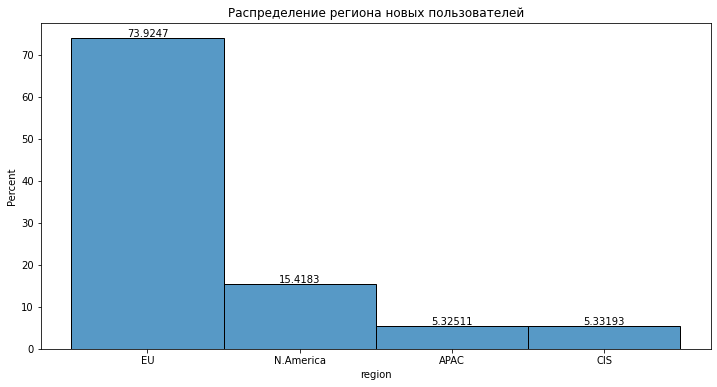

In [14]:
pylab.figure(figsize(12, 6))
plt.title('Распределение региона новых пользователей')
ax=sns.histplot(newusers['region'], discrete=True, stat='percent')
ax.bar_label (ax.containers [ 0 ])

Видим, что сайтом больше пользуются с мобильного устройства(Android и Iphone), однако это кажется естественным-наличие мобильного телефона более частое явление, чем наличие компьютера или ноутбука:

[Text(0, 0, '25.2883'),
 Text(0, 0, '44.5616'),
 Text(0, 0, '20.2749'),
 Text(0, 0, '9.87513')]

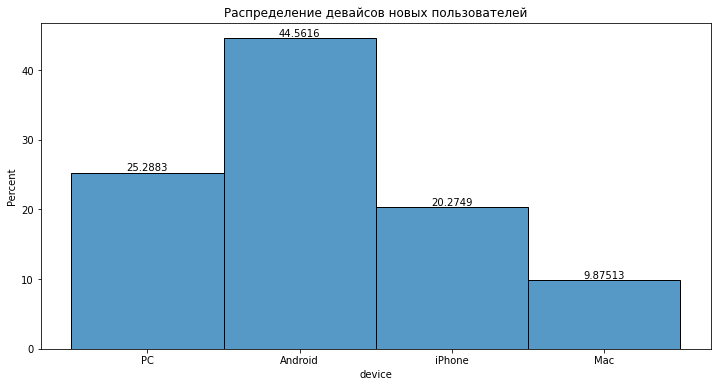

In [15]:
pylab.figure(figsize(12, 6))
plt.title('Распределение девайсов новых пользователей')
ax=sns.histplot(newusers['device'], discrete=True, stat='percent')
ax.bar_label (ax.containers [ 0 ])

Распределение дат подписок обладает "сезонностью", то есть большинство подписок совершенны в понедельник (07.12.2020, 14.12.2020, 21.12.2020), куда меньше подписок сделаны в будние дни, наименьшее количество подписок в выходные дни:

[Text(0, 0, '5291'),
 Text(0, 0, '3017'),
 Text(0, 0, '2010'),
 Text(0, 0, '2784'),
 Text(0, 0, '2226'),
 Text(0, 0, '3591'),
 Text(0, 0, '4181'),
 Text(0, 0, '5448'),
 Text(0, 0, '2924'),
 Text(0, 0, '2093'),
 Text(0, 0, '2940'),
 Text(0, 0, '3238'),
 Text(0, 0, '3480'),
 Text(0, 0, '4140'),
 Text(0, 0, '6077'),
 Text(0, 0, '3083'),
 Text(0, 0, '2180')]

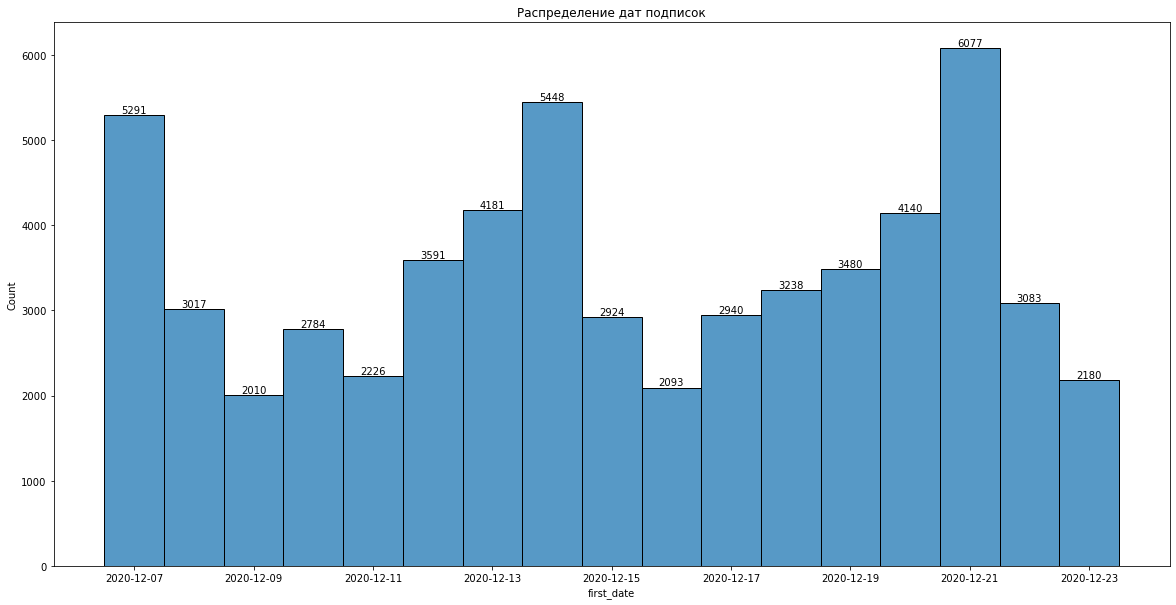

In [16]:
pylab.figure(figsize(20, 10))
plt.title('Распределение дат подписок')
ax=sns.histplot(newusers['first_date'], discrete=True)
ax.bar_label (ax.containers [ 0 ])

Создадим таблицу users, где будут все записи о принадлежности каждого пользователя к участию в тесте (название теста и группа, в случае неучастия в тестировании group=non_tested и ab_test=non_tested.

Примечание:Все пользователи записаны единожды в таблицу, за исключением 887 пользователей, которые участвуют сразу в двух тестах (они дважды записаны в таблицу: информация о принадлежности к группе в каждом из тестов)

In [17]:
users=newusers.merge(participants, how='outer', on='user_id')
users=users.fillna('non_tested')
users

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,F1C668619DFE6E65,2020-12-07,N.America,Android,non_tested,non_tested
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
3,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone,non_tested,non_tested
...,...,...,...,...,...,...
59585,1DB53B933257165D,2020-12-20,EU,Android,non_tested,non_tested
59586,538643EB4527ED03,2020-12-20,EU,Mac,non_tested,non_tested
59587,7ADEE837D5D8CBBD,2020-12-20,EU,PC,non_tested,non_tested
59588,1C7D23927835213F,2020-12-20,EU,iPhone,B,interface_eu_test


[Text(0, 0, '6.16714'), Text(0, 0, '75.6251'), Text(0, 0, '18.2078')]

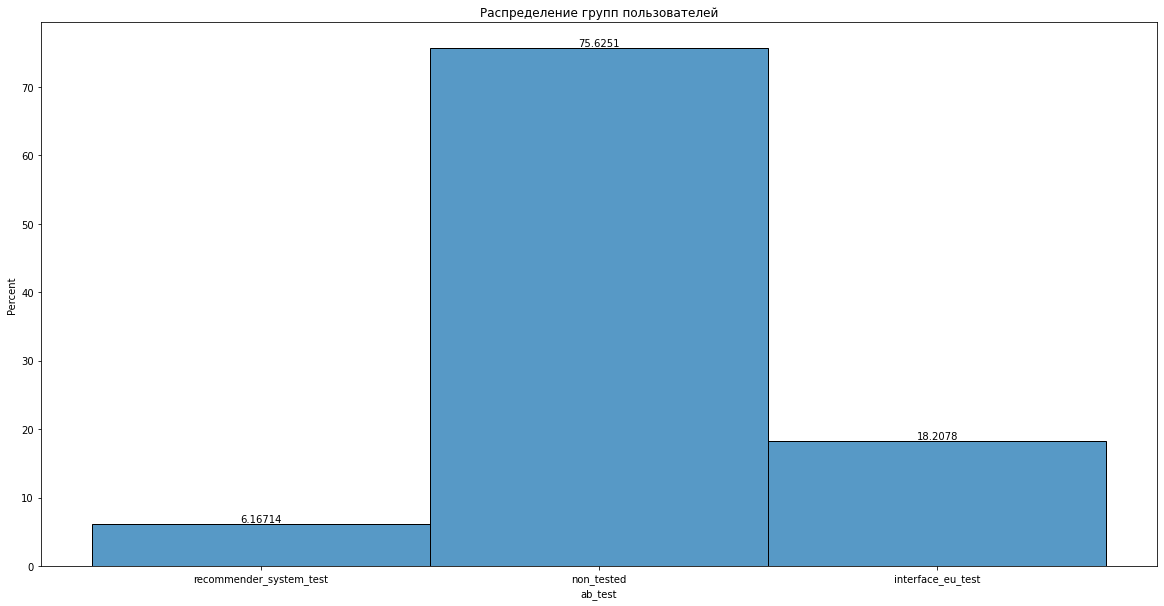

In [18]:
pylab.figure(figsize(20, 10))
plt.title('Распределение групп пользователей')
ax=sns.histplot(users['ab_test'], stat='percent')
ax.bar_label (ax.containers [ 0 ])

Количество уникальных пользователей, совершивших подписку:

In [19]:
users['user_id'].nunique()

58703

Все участники recommender_system_test:

In [20]:
recommender_system_contestants=users[users['ab_test']=='recommender_system_test']
recommender_system_contestants

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
19,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test
23,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test
39,4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test
40,29C92313A98B1176,2020-12-07,APAC,Android,B,recommender_system_test
...,...,...,...,...,...,...
59538,3CA972F86411CF13,2020-12-20,EU,PC,A,recommender_system_test
59542,A09DFE27D4CFF8E8,2020-12-20,EU,Android,B,recommender_system_test
59551,0F7D49FC184EDCDE,2020-12-20,EU,PC,A,recommender_system_test
59567,574ACBC674BC385D,2020-12-20,EU,Mac,A,recommender_system_test


Нет дупликатов user_id:

In [21]:
recommender_system_contestants['user_id'].duplicated().sum()

0

Все участники interface_eu_test:

In [22]:
interface_eu_contestants=users[users['ab_test']=='interface_eu_test']
interface_eu_contestants

,user_id,first_date,region,device,group,ab_test
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
3,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
13,5BE017E9C8CC42F8,2020-12-07,EU,Android,B,interface_eu_test
17,96F27A054B191457,2020-12-07,EU,iPhone,B,interface_eu_test
20,DD4352CDCF8C3D57,2020-12-07,EU,Android,A,interface_eu_test
...,...,...,...,...,...,...
59554,EF80B4EA44F7B607,2020-12-20,EU,Android,A,interface_eu_test
59571,27007FC1A9B62FC5,2020-12-20,EU,iPhone,B,interface_eu_test
59577,75F25D4DADA37ABB,2020-12-20,EU,Android,B,interface_eu_test
59578,2C29721DDDA76B2A,2020-12-20,EU,iPhone,B,interface_eu_test


Нет дупликатов user_id:

In [23]:
interface_eu_contestants['user_id'].duplicated().sum()

0

Список пользователей, не участвующих ни в одном из тестов:

In [24]:
non_tested_users=users[users['ab_test']=='non_tested']
non_tested_users

,user_id,first_date,region,device,group,ab_test
1,F1C668619DFE6E65,2020-12-07,N.America,Android,non_tested,non_tested
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone,non_tested,non_tested
5,137119F5A9E69421,2020-12-07,N.America,iPhone,non_tested,non_tested
6,62F0C741CC42D0CC,2020-12-07,APAC,iPhone,non_tested,non_tested
7,8942E64218C9A1ED,2020-12-07,EU,PC,non_tested,non_tested
...,...,...,...,...,...,...
59584,F4BEEB17FEF0D52A,2020-12-20,EU,PC,non_tested,non_tested
59585,1DB53B933257165D,2020-12-20,EU,Android,non_tested,non_tested
59586,538643EB4527ED03,2020-12-20,EU,Mac,non_tested,non_tested
59587,7ADEE837D5D8CBBD,2020-12-20,EU,PC,non_tested,non_tested


Нет дупликатов user_id:

In [25]:
non_tested_users['user_id'].duplicated().sum()

0

Важно, чтобы выборка участников каждой группы теста была репрезентативна по типу девайса и региону, то есть в каждой группе должны быть примерно одинаковые доли пользователей определенного типа девайса или определенного региона:

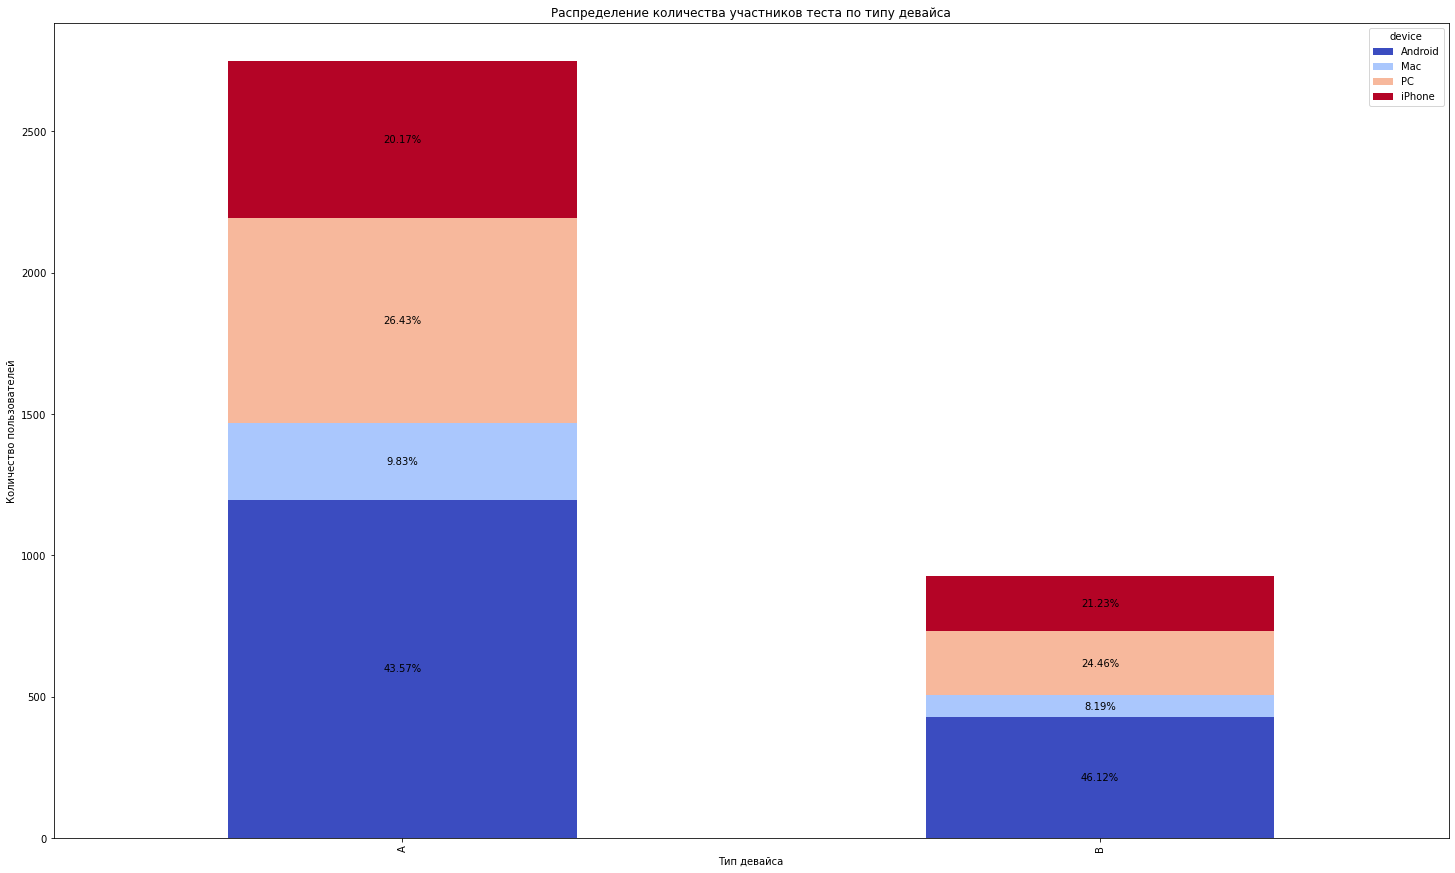

In [26]:
ax=recommender_system_contestants.pivot_table(values='user_id', index='group', columns='device', aggfunc='count').plot.bar(figsize=(25, 15), stacked=True, legend=True, cmap='coolwarm')
labels=[]
for c in ax.containers: 
    labels.append([v.get_height() if v.get_height() > 0 else '' for v in c])
labels1=[[0, 0], [0, 0], [0, 0],[0, 0]]
s1=[0]*2
for i in range(2):
    for j in range(4):
        s1[i]=s1[i]+labels[j][i]
for i in range(2):
    for j in range(4):
        labels1[j][i]=str(round(labels[j][i]/s1[i]*100,2))+'%'
i=-1
for c in ax.containers:
    i=i+1
    ax.bar_label(c, labels=labels1[i], label_type='center')
plt.title('Распределение количества участников теста по типу девайса')
plt.xlabel('Тип девайса')
plt.ylabel('Количество пользователей')
plt.show()

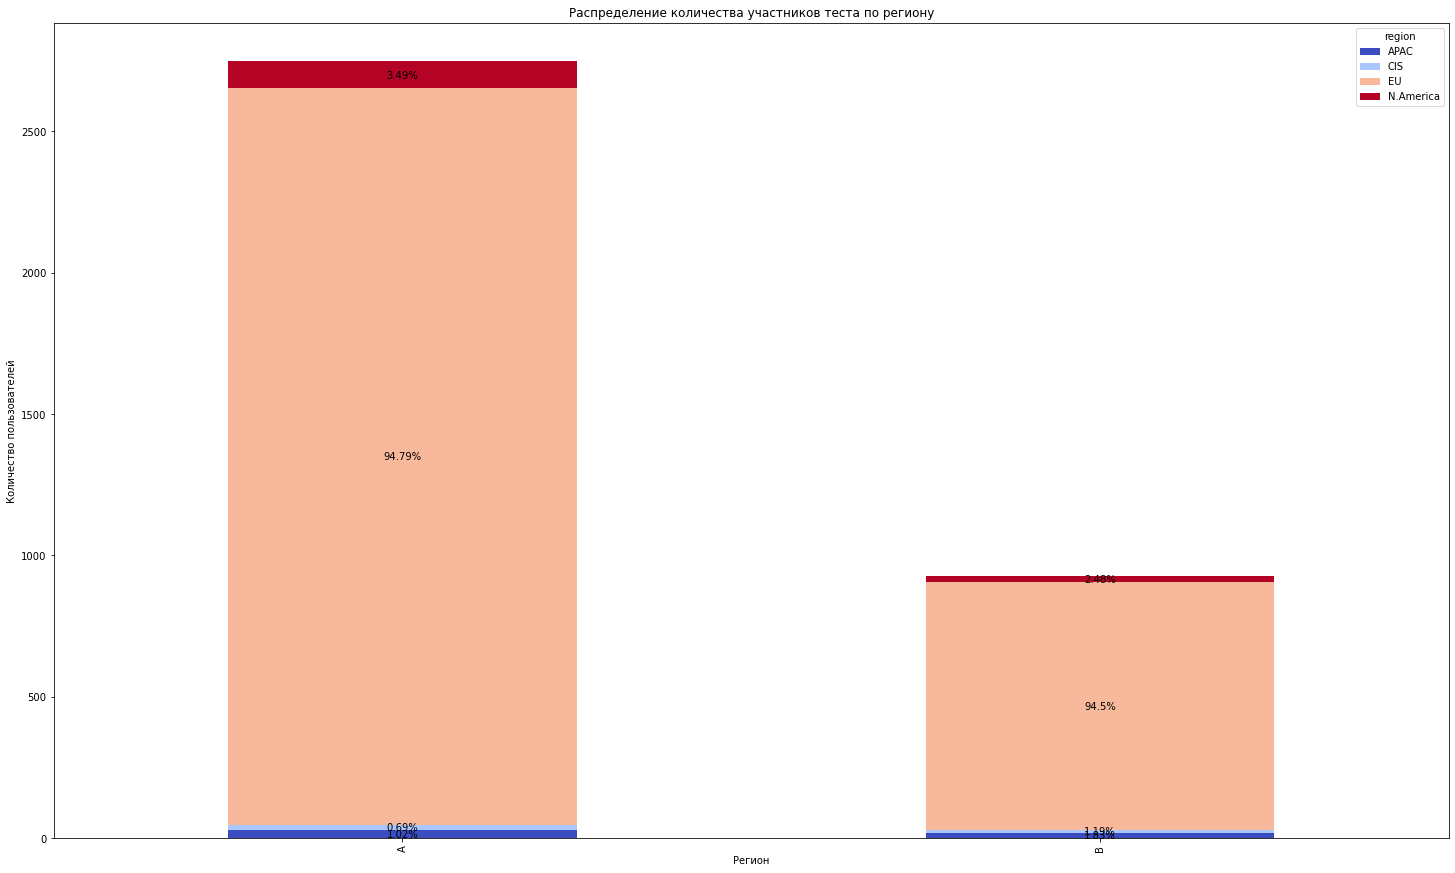

In [27]:
ax=recommender_system_contestants.pivot_table(values='user_id', index='group', columns='region', aggfunc='count').plot.bar(figsize=(25, 15), stacked=True, legend=True, cmap='coolwarm')
labels=[]
for c in ax.containers: 
    labels.append([v.get_height() if v.get_height() > 0 else '' for v in c])
labels1=[[0, 0], [0, 0], [0, 0],[0, 0]]
s1=[0]*2
for i in range(2):
    for j in range(4):
        s1[i]=s1[i]+labels[j][i]
for i in range(2):
    for j in range(4):
        labels1[j][i]=str(round(labels[j][i]/s1[i]*100,2))+'%'
i=-1
for c in ax.containers:
    i=i+1
    ax.bar_label(c, labels=labels1[i], label_type='center')
plt.title('Распределение количества участников теста по региону')
plt.xlabel('Регион')
plt.ylabel('Количество пользователей')
plt.show()

Выборка участников каждой группы recommender_system_test репрезентативна по типу девайса и региону

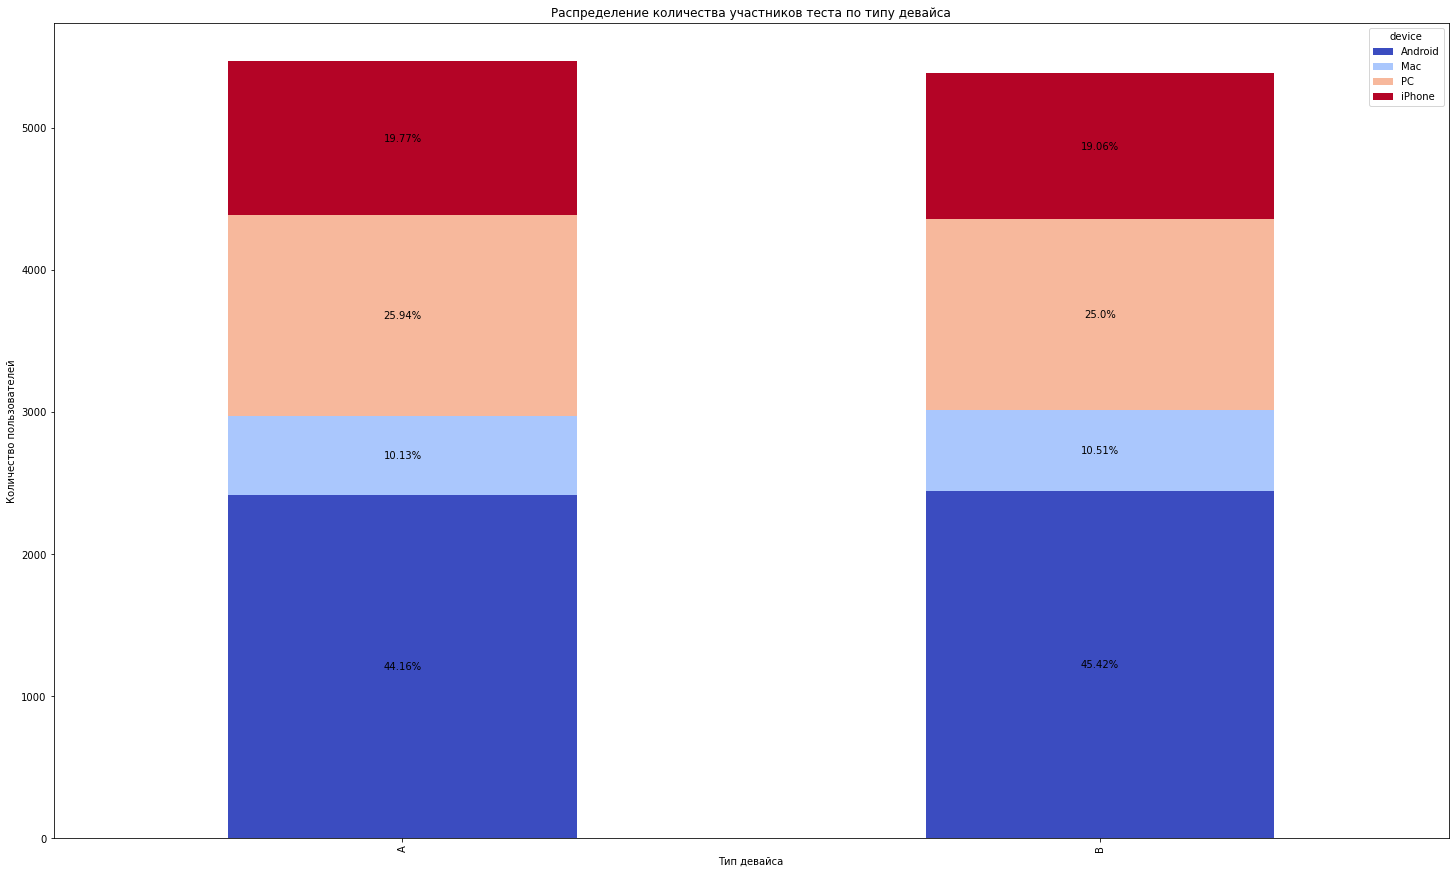

In [28]:
ax=interface_eu_contestants.pivot_table(values='user_id', index='group', columns='device', aggfunc='count').plot.bar(figsize=(25, 15), stacked=True, legend=True, cmap='coolwarm')
labels=[]
for c in ax.containers: 
    labels.append([v.get_height() if v.get_height() > 0 else '' for v in c])
labels1=[[0, 0], [0, 0], [0, 0],[0, 0]]
s1=[0]*2
for i in range(2):
    for j in range(4):
        s1[i]=s1[i]+labels[j][i]
for i in range(2):
    for j in range(4):
        labels1[j][i]=str(round(labels[j][i]/s1[i]*100,2))+'%'
i=-1
for c in ax.containers:
    i=i+1
    ax.bar_label(c, labels=labels1[i], label_type='center')
plt.title('Распределение количества участников теста по типу девайса')
plt.xlabel('Тип девайса')
plt.ylabel('Количество пользователей')
plt.show()

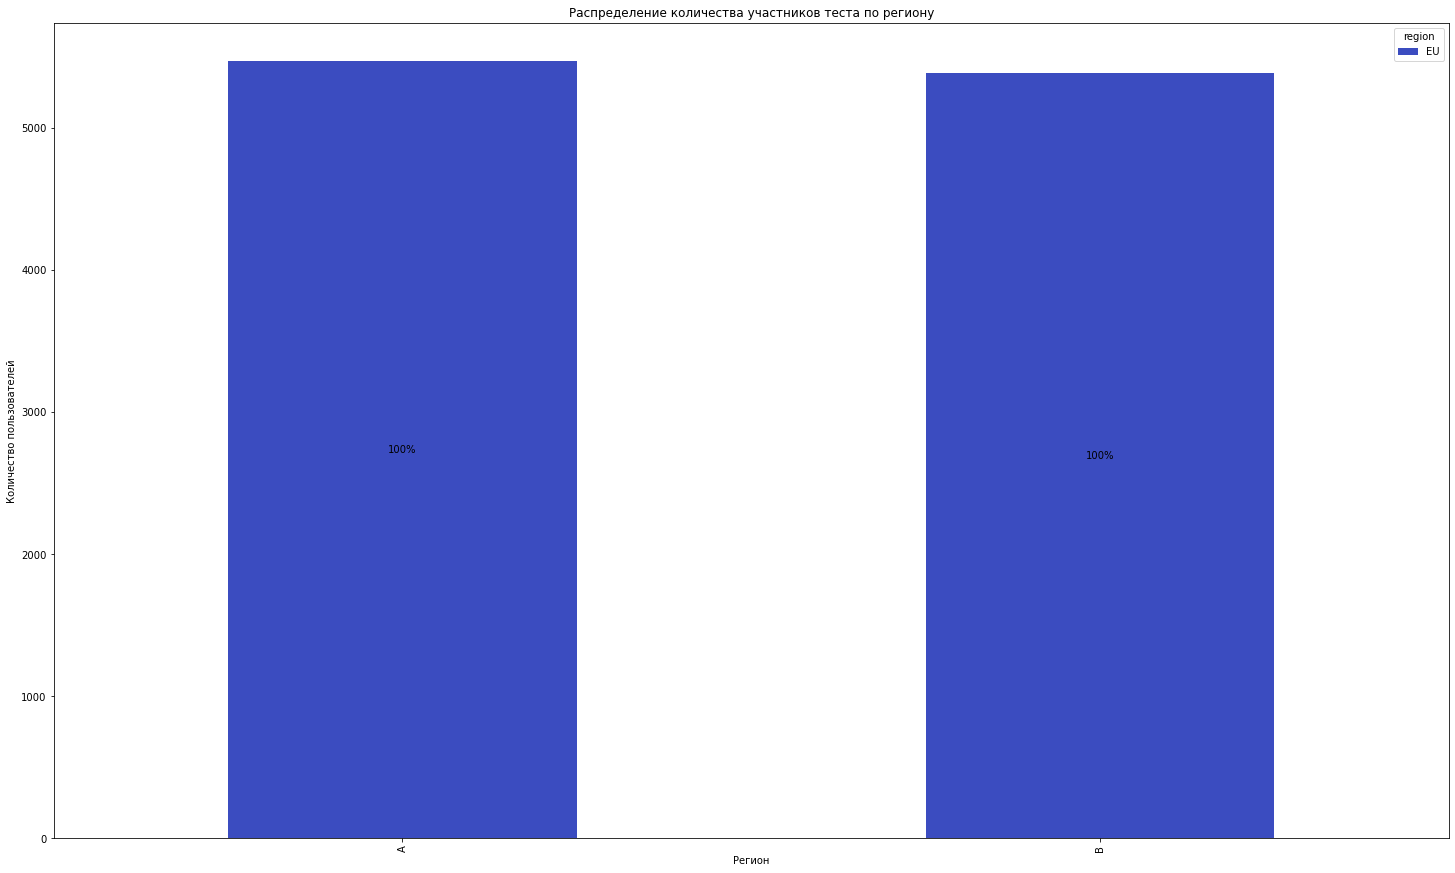

In [29]:
ax=interface_eu_contestants.pivot_table(values='user_id', index='group', columns='region', aggfunc='count').plot.bar(figsize=(25, 15), stacked=True, legend=True, cmap='coolwarm')
labels1=[['100%', '100%']]
i=-1
for c in ax.containers:
    i=i+1
    ax.bar_label(c, labels=labels1[i], label_type='center')
plt.title('Распределение количества участников теста по региону')
plt.xlabel('Регион')
plt.ylabel('Количество пользователей')
plt.show()

Выборка участников каждой группы interface_eu_test репрезентативна по типу девайса и региону

## Events

Описание таблицы: events — all events of the new users within the period from December 7, 2020 to January 1, 2021

    1)user_id
    2)event_dt — event date and time
    3)event_name — event type name
    4)details — additional data on the event (for instance, the order total in USD for purchase events)


In [30]:
events

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


Количество уникальных пользователей, совершивших хотя бы одно из действий на сайте (login, product_page, product_cart, purchase):
Замечание: количество уникальных пользователей, совершивших хотя бы одно из действий равно числу уникальных пользователей, совершивших подписку. Следовательно, каждый пользователь, соверший подписку совершил хотя бы одно действие на сайте.

In [31]:
events['user_id'].nunique()

58703

In [32]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB


Нет дупликатов действий:

In [33]:
events.duplicated().sum()

0

Отсортируем действия по дате и построим гистограмму распределения количества действий по пользователям:

In [34]:
events=events.sort_values('event_dt')
events

,user_id,event_dt,event_name,details
756,EB2D1E4A76B38E24,2020-12-07 00:00:33,purchase,9.99
243582,EB2D1E4A76B38E24,2020-12-07 00:00:33,login,NaN
121935,EB2D1E4A76B38E24,2020-12-07 00:00:34,product_page,NaN
121862,821D82C2BB74CBB2,2020-12-07 00:00:35,product_page,NaN
243463,821D82C2BB74CBB2,2020-12-07 00:00:35,login,NaN
...,...,...,...,...
241277,07C004DB8325E140,2020-12-30 22:39:43,product_page,NaN
423742,CE065914C815ADF6,2020-12-30 23:02:44,login,NaN
60306,CE065914C815ADF6,2020-12-30 23:02:44,purchase,9.99
423750,E0E5446B78A6520B,2020-12-30 23:36:30,login,NaN


Видно, что распределение суммарного количества действий пользователей похоже на логнормальное распределение с "длинным хвотом"(есть выбросы). Также можно сделать удивительное наблюдение, что все простые числа, большие 3, имеют малую высоту бина. Это значит, что у очень небольшого количества пользователей суммарное количество действий является простым числом, большим 3. Это можно интерпретировать следующим образом: всего у нас 4 возможных различных действия. Человек склонен к когнитивой легкости (повторяемости определенных действий), поэтому можно предположить, что человек за один заход на сайт (за одну сессию) делает определенную последовательность действий (определенное количество действий), поэтому весьма вероятно, что суммарное количество действий будет сложным числом.

[Text(0, 0, '759'),
 Text(0, 0, '4703'),
 Text(0, 0, '4669'),
 Text(0, 0, '8876'),
 Text(0, 0, '946'),
 Text(0, 0, '13109'),
 Text(0, 0, '145'),
 Text(0, 0, '6491'),
 Text(0, 0, '5822'),
 Text(0, 0, '2467'),
 Text(0, 0, '102'),
 Text(0, 0, '6017'),
 Text(0, 0, '26'),
 Text(0, 0, '277'),
 Text(0, 0, '1825'),
 Text(0, 0, '899'),
 Text(0, 0, '35'),
 Text(0, 0, '670'),
 Text(0, 0, '18'),
 Text(0, 0, '422'),
 Text(0, 0, '178'),
 Text(0, 0, '1'),
 Text(0, 0, '6'),
 Text(0, 0, '173'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '12'),
 Text(0, 0, '46'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '2'),
 Text(0, 0, '6'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '1')]

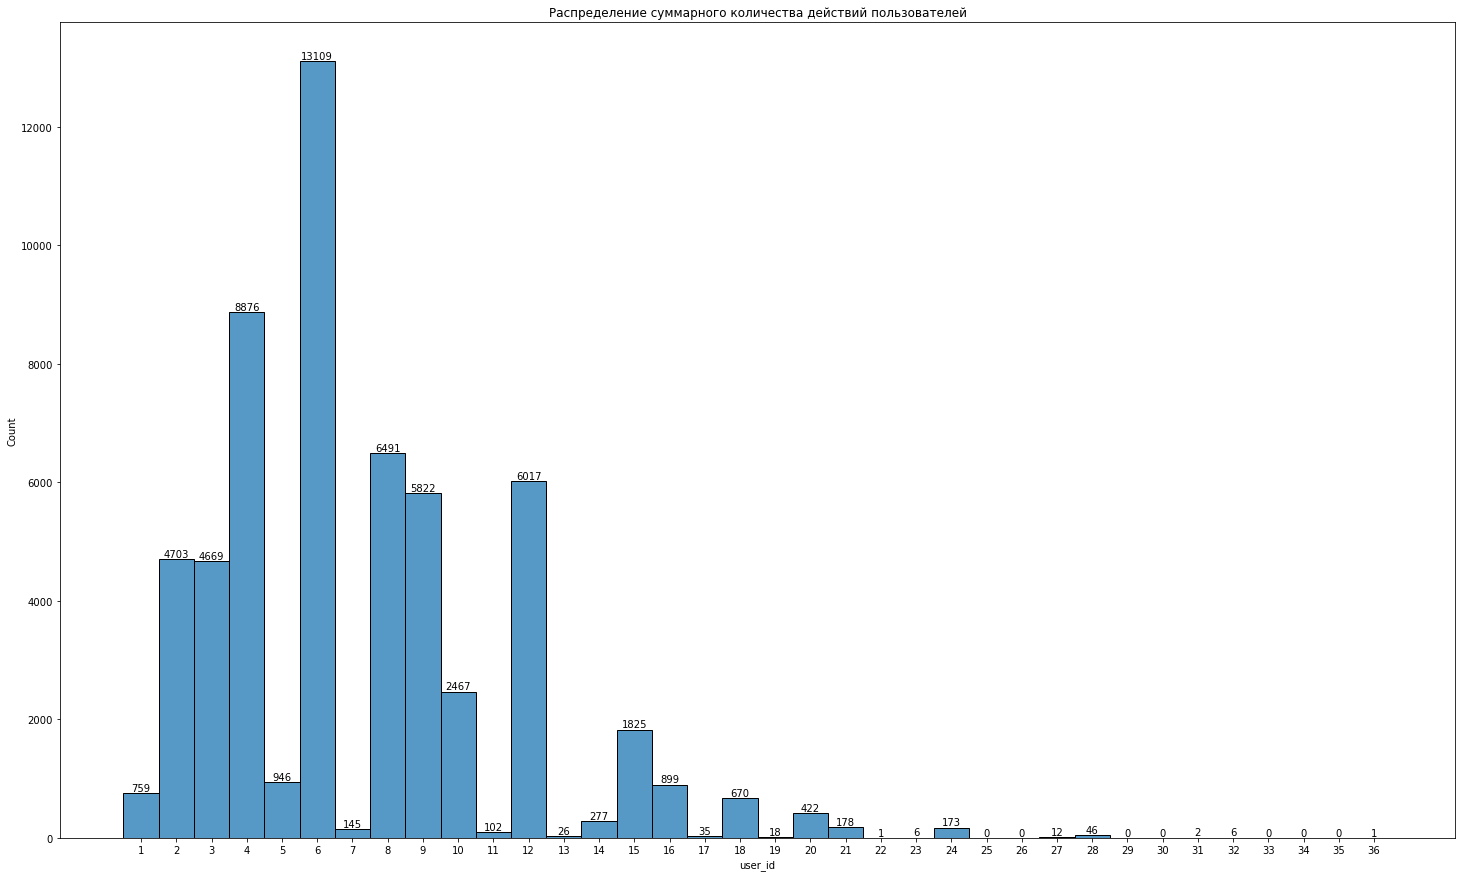

In [35]:
pylab.figure(figsize(25, 15))
plt.title('Распределение суммарного количества действий пользователей')
plt.xticks(range(1,37))
ax=sns.histplot(events['user_id'].value_counts(), discrete=True)
ax.bar_label (ax.containers [ 0 ])

Видим, что самое частое действие - логин. При этом действие покупки является более частым действием, чем заход в продуктовую корзину. Вероятно, есть быстрый способ совершить покупку, перейдя по ссылке и  не заходя в корзину. Поэтому у нас нет определенной воронки, по которой мы могли бы посчитать конверсию из предыдущего действия в следующее. Мы можем лишь посчитать конверсию из подписки в покупку.

[Text(0, 0, '60314'),
 Text(0, 0, '182465'),
 Text(0, 0, '120862'),
 Text(0, 0, '60120')]

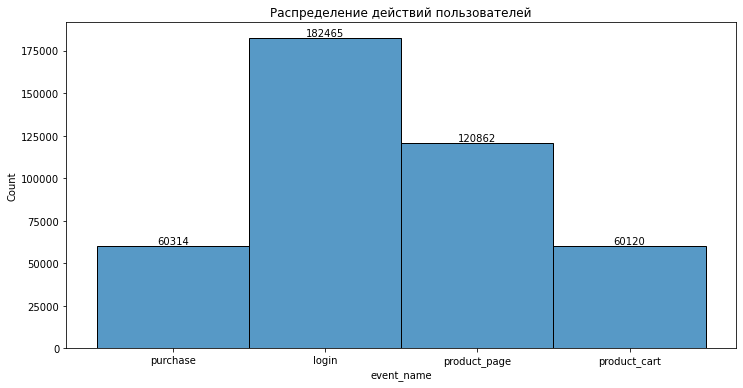

In [36]:
pylab.figure(figsize(12, 6))
plt.title('Распределение действий пользователей')
ax=sns.histplot(events['event_name'], discrete=True)
ax.bar_label (ax.containers [ 0 ])

У нас всего 4 возможных суммы покупки на сайте, распределение по которым приведено ниже:

In [37]:
events['details'].value_counts()

4.99      44579
9.99       9158
99.99      5405
499.99     1172
Name: details, dtype: int64

Посмотрим гистограммы распределения пользователей по региону, типу девайса и действию в разрезе по участию в тестах:

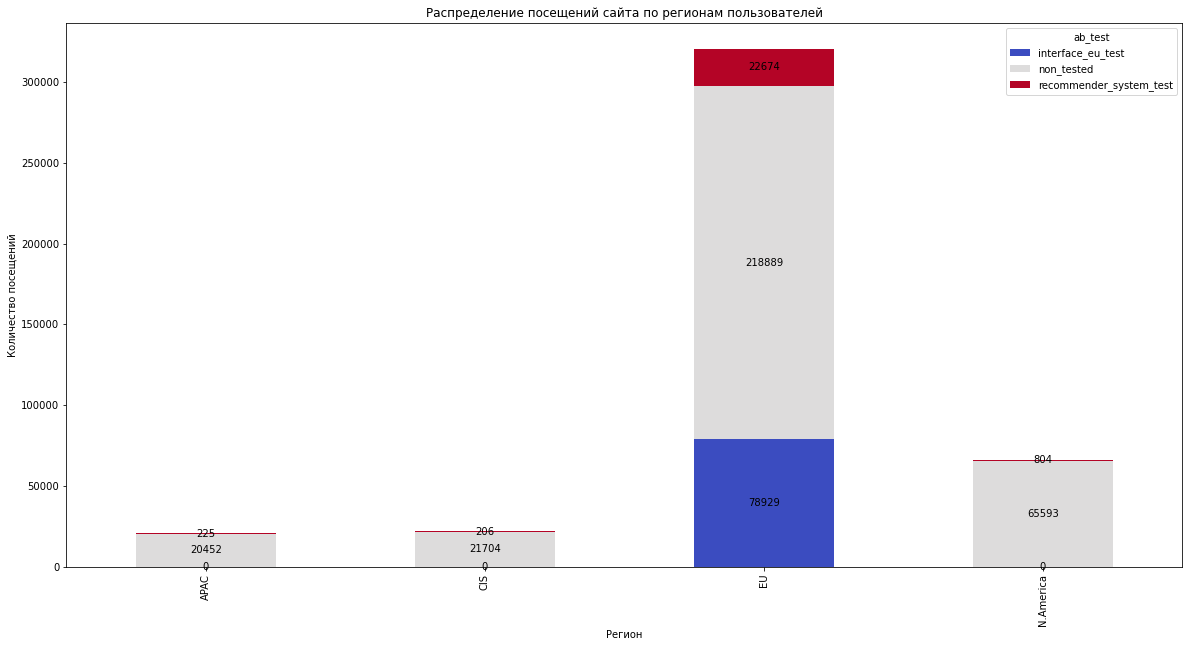

In [38]:
events0=events.merge(users, on='user_id')
ax=events0.pivot_table(values='user_id', index='region', columns='ab_test', aggfunc='count').plot.bar(figsize=(20, 10), stacked=True, legend=True, cmap='coolwarm')
for c in ax.containers: 
    ax.bar_label(c, label_type='center')
plt.title('Распределение посещений сайта по регионам пользователей')
plt.xlabel('Регион')
plt.ylabel('Количество посещений')
plt.show()

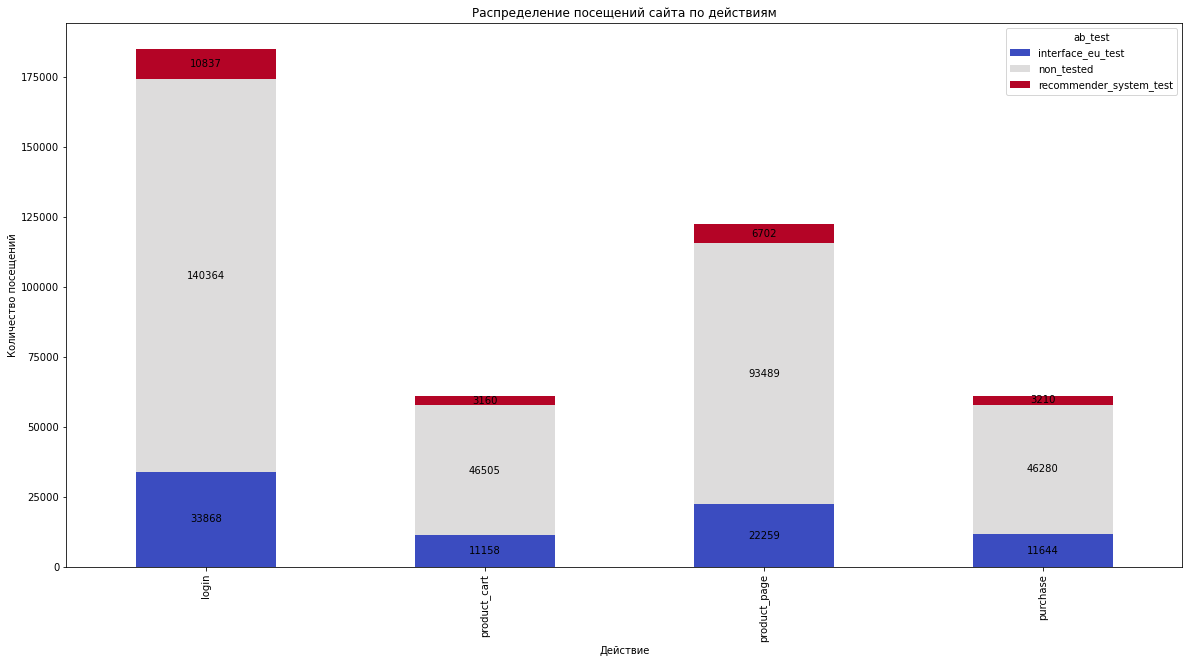

In [39]:
ax=events0.pivot_table(values='user_id', index='event_name', columns='ab_test', aggfunc='count').plot.bar(figsize=(20, 10), stacked=True, legend=True, cmap='coolwarm')
for c in ax.containers: 
    ax.bar_label(c, label_type='center')
plt.title('Распределение посещений сайта по действиям')
plt.xlabel('Действие')
plt.ylabel('Количество посещений')
plt.show()

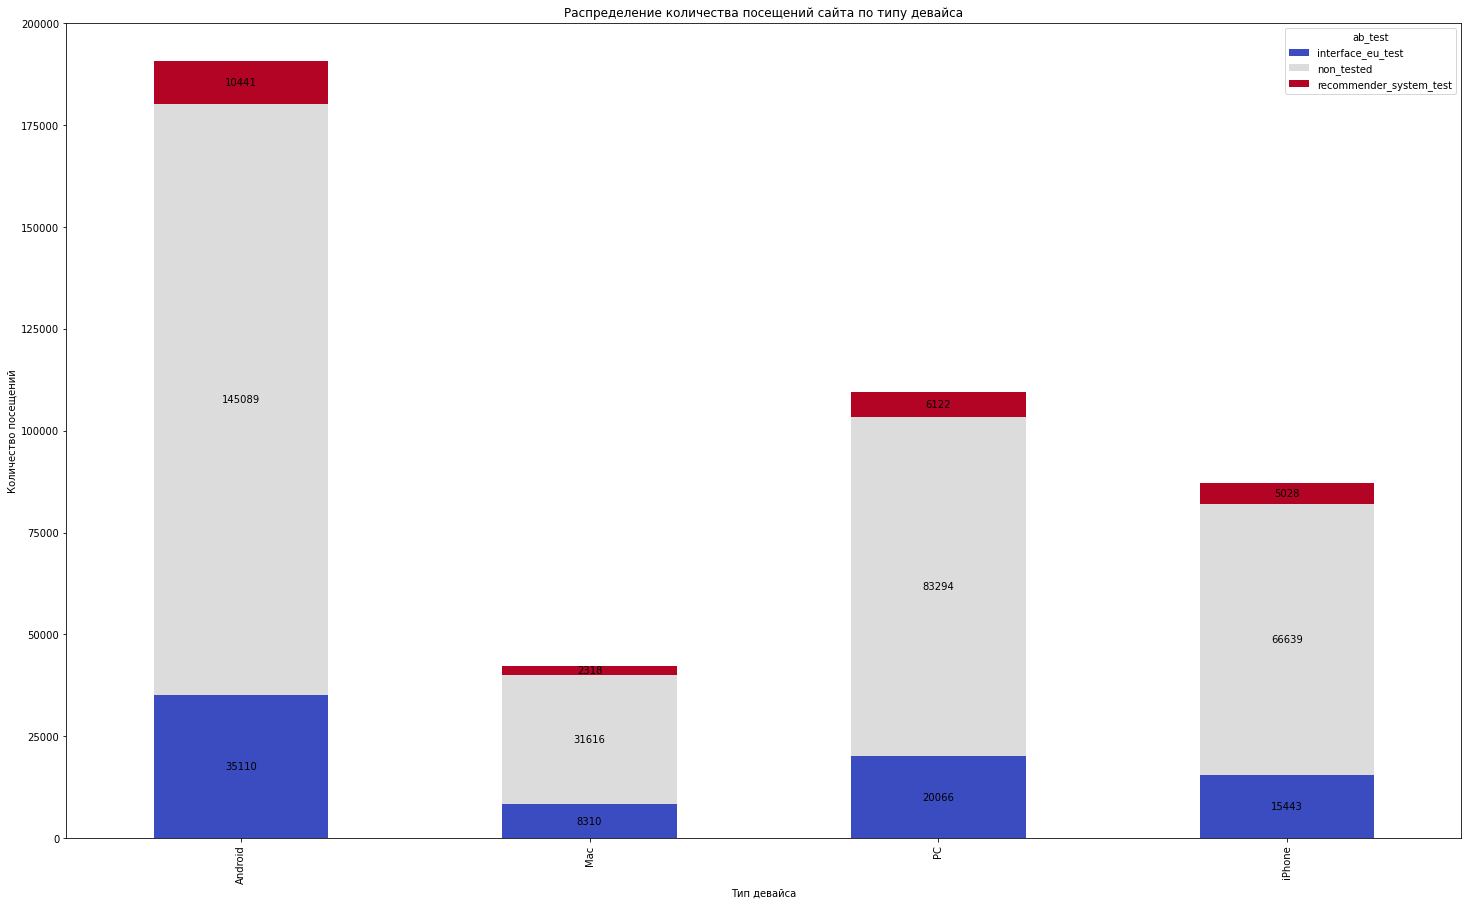

In [40]:
ax=events0.pivot_table(values='user_id', index='device', columns='ab_test', aggfunc='count').plot.bar(figsize=(25, 15), stacked=True, legend=True, cmap='coolwarm')
for c in ax.containers: 
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, label_type='center')
plt.title('Распределение количества посещений сайта по типу девайса')
plt.xlabel('Тип девайса')
plt.ylabel('Количество посещений')
plt.show()

Посчитаем частоту каждого действия для каждого пользователя:

In [41]:
events_total=pd.DataFrame(pd.pivot_table(events, values='event_dt', index='user_id', columns='event_name',
                          aggfunc='count')).reset_index()
events_total=events_total.fillna(0)
events_total=events_total[['user_id', 'login', 'product_page', 'product_cart', 'purchase']]
events_total

event_name,user_id,login,product_page,product_cart,purchase
0,0001710F4DDB1D1B,2.0,2.0,2.0,0.0
1,000199F1887AE5E6,4.0,4.0,4.0,4.0
2,0002499E372175C7,3.0,3.0,0.0,3.0
3,0002CE61FF2C4011,4.0,4.0,4.0,0.0
4,000456437D0EFFE1,2.0,2.0,0.0,0.0
...,...,...,...,...,...
58698,FFF7A7BAF44FE9B4,2.0,0.0,0.0,0.0
58699,FFF8FDBE2FE99C91,4.0,4.0,0.0,4.0
58700,FFF91B6C5431F375,4.0,0.0,4.0,0.0
58701,FFFAB034A09DCC28,2.0,2.0,0.0,0.0


Создадим таблицу recommender_system_events, в которой будут отображены все действия участников recommender_system_test:

In [42]:
recommender_system_events=events.merge(recommender_system_contestants, on='user_id')
recommender_system_events

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
0,894A2506B3A50D03,2020-12-07 00:05:57,login,NaN,2020-12-07,EU,Android,B,recommender_system_test
1,894A2506B3A50D03,2020-12-07 00:05:57,product_page,NaN,2020-12-07,EU,Android,B,recommender_system_test
2,894A2506B3A50D03,2020-12-08 17:56:16,login,NaN,2020-12-07,EU,Android,B,recommender_system_test
3,894A2506B3A50D03,2020-12-08 17:56:17,product_page,NaN,2020-12-07,EU,Android,B,recommender_system_test
4,894A2506B3A50D03,2020-12-10 22:02:24,login,NaN,2020-12-07,EU,Android,B,recommender_system_test
...,...,...,...,...,...,...,...,...,...
23904,9D8E1DFF5B436455,2020-12-28 10:23:30,login,NaN,2020-12-21,N.America,Android,A,recommender_system_test
23905,9D8E1DFF5B436455,2020-12-28 10:23:31,product_page,NaN,2020-12-21,N.America,Android,A,recommender_system_test
23906,3288BEE68559CC59,2020-12-21 23:58:57,login,NaN,2020-12-21,EU,PC,B,recommender_system_test
23907,3288BEE68559CC59,2020-12-21 23:58:57,product_page,NaN,2020-12-21,EU,PC,B,recommender_system_test


Создадим таблицы recommender_system_events_a и recommender_system_events_b, в которых будут отображены все действия участников из группы a и b соответственно:

In [43]:
recommender_system_events_a=recommender_system_events[recommender_system_events['group']=='A']
recommender_system_events_a

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
14,4A55475E078F40DC,2020-12-07 00:14:01,login,NaN,2020-12-07,EU,Android,A,recommender_system_test
15,4A55475E078F40DC,2020-12-07 00:14:01,purchase,9.99,2020-12-07,EU,Android,A,recommender_system_test
16,4A55475E078F40DC,2020-12-13 19:37:44,login,NaN,2020-12-07,EU,Android,A,recommender_system_test
17,4A55475E078F40DC,2020-12-13 19:37:44,purchase,4.99,2020-12-07,EU,Android,A,recommender_system_test
18,20996AEF74602821,2020-12-07 00:16:00,purchase,9.99,2020-12-07,EU,Android,A,recommender_system_test
...,...,...,...,...,...,...,...,...,...
23901,9D8E1DFF5B436455,2020-12-23 00:36:43,product_page,NaN,2020-12-21,N.America,Android,A,recommender_system_test
23902,9D8E1DFF5B436455,2020-12-26 00:43:40,login,NaN,2020-12-21,N.America,Android,A,recommender_system_test
23903,9D8E1DFF5B436455,2020-12-26 00:43:40,product_page,NaN,2020-12-21,N.America,Android,A,recommender_system_test
23904,9D8E1DFF5B436455,2020-12-28 10:23:30,login,NaN,2020-12-21,N.America,Android,A,recommender_system_test


In [44]:
recommender_system_events_b=recommender_system_events[recommender_system_events['group']=='B']
recommender_system_events_b

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
0,894A2506B3A50D03,2020-12-07 00:05:57,login,NaN,2020-12-07,EU,Android,B,recommender_system_test
1,894A2506B3A50D03,2020-12-07 00:05:57,product_page,NaN,2020-12-07,EU,Android,B,recommender_system_test
2,894A2506B3A50D03,2020-12-08 17:56:16,login,NaN,2020-12-07,EU,Android,B,recommender_system_test
3,894A2506B3A50D03,2020-12-08 17:56:17,product_page,NaN,2020-12-07,EU,Android,B,recommender_system_test
4,894A2506B3A50D03,2020-12-10 22:02:24,login,NaN,2020-12-07,EU,Android,B,recommender_system_test
...,...,...,...,...,...,...,...,...,...
23856,94FF90F8FBAB959D,2020-12-21 23:31:48,purchase,4.99,2020-12-21,EU,Android,B,recommender_system_test
23857,94FF90F8FBAB959D,2020-12-21 23:31:49,product_page,NaN,2020-12-21,EU,Android,B,recommender_system_test
23906,3288BEE68559CC59,2020-12-21 23:58:57,login,NaN,2020-12-21,EU,PC,B,recommender_system_test
23907,3288BEE68559CC59,2020-12-21 23:58:57,product_page,NaN,2020-12-21,EU,PC,B,recommender_system_test


Создадим таблицу interface_eu_events, в которой будут отображены все действия участников interface_eu_test:

In [45]:
interface_eu_events=events.merge(interface_eu_contestants, on='user_id')
interface_eu_events

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
0,B13A53A1EB2038EE,2020-12-07 00:02:48,login,NaN,2020-12-07,EU,PC,A,interface_eu_test
1,B13A53A1EB2038EE,2020-12-08 03:48:35,login,NaN,2020-12-07,EU,PC,A,interface_eu_test
2,B13A53A1EB2038EE,2020-12-12 04:25:23,login,NaN,2020-12-07,EU,PC,A,interface_eu_test
3,4C4BA430AAA820F8,2020-12-07 00:03:18,login,NaN,2020-12-07,EU,PC,A,interface_eu_test
4,4C4BA430AAA820F8,2020-12-07 00:03:19,product_page,NaN,2020-12-07,EU,PC,A,interface_eu_test
...,...,...,...,...,...,...,...,...,...
78924,16CCB1C8C4DCF1AF,2020-12-23 23:54:19,login,NaN,2020-12-23,EU,Mac,B,interface_eu_test
78925,337CF51CF67A9304,2020-12-23 23:55:18,login,NaN,2020-12-23,EU,PC,B,interface_eu_test
78926,337CF51CF67A9304,2020-12-24 07:01:04,login,NaN,2020-12-23,EU,PC,B,interface_eu_test
78927,2DDC948BD76ABC57,2020-12-24 21:57:11,login,NaN,2020-12-07,EU,iPhone,A,interface_eu_test


Создадим таблицы interface_eu_events_a и interface_eu_events_и, в которых будут отображены все действия участников из группы a и b соответственно:

In [46]:
interface_eu_events_a=interface_eu_events[interface_eu_events['group']=='A']
interface_eu_events_a

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
0,B13A53A1EB2038EE,2020-12-07 00:02:48,login,NaN,2020-12-07,EU,PC,A,interface_eu_test
1,B13A53A1EB2038EE,2020-12-08 03:48:35,login,NaN,2020-12-07,EU,PC,A,interface_eu_test
2,B13A53A1EB2038EE,2020-12-12 04:25:23,login,NaN,2020-12-07,EU,PC,A,interface_eu_test
3,4C4BA430AAA820F8,2020-12-07 00:03:18,login,NaN,2020-12-07,EU,PC,A,interface_eu_test
4,4C4BA430AAA820F8,2020-12-07 00:03:19,product_page,NaN,2020-12-07,EU,PC,A,interface_eu_test
...,...,...,...,...,...,...,...,...,...
78921,38CA3A3C4FE3FEFD,2020-12-24 05:46:41,product_page,NaN,2020-12-23,EU,iPhone,A,interface_eu_test
78922,B1D88FBD4BA58E1B,2020-12-23 23:50:45,login,NaN,2020-12-23,EU,Android,A,interface_eu_test
78923,B1D88FBD4BA58E1B,2020-12-23 23:50:46,product_page,NaN,2020-12-23,EU,Android,A,interface_eu_test
78927,2DDC948BD76ABC57,2020-12-24 21:57:11,login,NaN,2020-12-07,EU,iPhone,A,interface_eu_test


In [47]:
interface_eu_events_b=interface_eu_events[interface_eu_events['group']=='B']
interface_eu_events_b

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
9,4B7C59A60FE1DA69,2020-12-07 00:03:51,login,NaN,2020-12-07,EU,Android,B,interface_eu_test
10,4B7C59A60FE1DA69,2020-12-07 00:03:54,product_cart,NaN,2020-12-07,EU,Android,B,interface_eu_test
11,4B7C59A60FE1DA69,2020-12-09 04:45:47,login,NaN,2020-12-07,EU,Android,B,interface_eu_test
12,4B7C59A60FE1DA69,2020-12-09 04:45:48,product_cart,NaN,2020-12-07,EU,Android,B,interface_eu_test
13,4B7C59A60FE1DA69,2020-12-13 21:02:56,product_cart,NaN,2020-12-07,EU,Android,B,interface_eu_test
...,...,...,...,...,...,...,...,...,...
78908,85ECB8DE3B7740FA,2020-12-23 23:41:23,product_page,NaN,2020-12-23,EU,Android,B,interface_eu_test
78909,5C7DE51C220CC064,2020-12-23 23:42:09,login,NaN,2020-12-23,EU,iPhone,B,interface_eu_test
78924,16CCB1C8C4DCF1AF,2020-12-23 23:54:19,login,NaN,2020-12-23,EU,Mac,B,interface_eu_test
78925,337CF51CF67A9304,2020-12-23 23:55:18,login,NaN,2020-12-23,EU,PC,B,interface_eu_test


Создадим таблицу non_tested_events, в которой будут отображены все действия участников, не участвующих в тестировании:

In [48]:
non_tested_events=events.merge(non_tested_users, on='user_id')
non_tested_events

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
0,EB2D1E4A76B38E24,2020-12-07 00:00:33,purchase,9.99,2020-12-07,EU,Android,non_tested,non_tested
1,EB2D1E4A76B38E24,2020-12-07 00:00:33,login,NaN,2020-12-07,EU,Android,non_tested,non_tested
2,EB2D1E4A76B38E24,2020-12-07 00:00:34,product_page,NaN,2020-12-07,EU,Android,non_tested,non_tested
3,EB2D1E4A76B38E24,2020-12-11 22:16:52,purchase,99.99,2020-12-07,EU,Android,non_tested,non_tested
4,EB2D1E4A76B38E24,2020-12-11 22:16:52,login,NaN,2020-12-07,EU,Android,non_tested,non_tested
...,...,...,...,...,...,...,...,...,...
326633,0D9B8D7DF6D8AFE2,2020-12-28 03:37:23,product_page,NaN,2020-12-07,EU,Android,non_tested,non_tested
326634,0D9B8D7DF6D8AFE2,2020-12-28 03:37:23,login,NaN,2020-12-07,EU,Android,non_tested,non_tested
326635,870CA5DC783E379C,2020-12-29 09:03:53,product_cart,NaN,2020-12-07,N.America,PC,non_tested,non_tested
326636,870CA5DC783E379C,2020-12-29 09:03:53,login,NaN,2020-12-07,N.America,PC,non_tested,non_tested


# Продуктовые метрики

Будем считать все продуктовые метрики для 6 групп пользователей:

    1)all users
    2)non-tested users
    3)recommender_system group A
    4)recommender_system group B
    5)interface_eu group A
    6)interface_eu group B

## DAU

Посчитаем уникальное количество пользователей, заходивших на сайт(сделавших хотя бы одно действие), для каждого дня:

### all users

In [49]:
events1=pd.DataFrame(copy(events), columns=events.columns)
events1['date']=events1['event_dt'].apply(lambda x: x.day)

In [50]:
dau = pd.DataFrame(events1.groupby(['date'])['user_id'].nunique()).reset_index()
dau.columns=['date', 'number_of_users']
dau=dau.sort_values('date')
dau=dau.reset_index(drop=True)
x=[0]*len(dau)
for i in range(len(dau)):
    x[i]=(dau['date'][i]>=newusers['first_date'].apply(lambda j:j.day)).sum()
dau['sign']=x
dau

,date,number_of_users,sign
0,7,5031,5291
1,8,5496,8308
2,9,5227,10318
3,10,6045,13102
4,11,6000,15328
5,12,7562,18919
6,13,9020,23100
7,14,11254,28548
8,15,10083,31472
9,16,9004,33565


Видно, что наибольшую активность пользователи проявляют в понедельник (14.12.2020 и 21.12.2020), аналогично с днями подписки. Однако по сравнению с днями подписки, здесь действий в выходные дни не меньше, чем в будний день на этой недели, кроме понедельника. Это можно объяснить тем, что с 7.12.2020 до 21.12.2020 график возрастает, за исключением спада 15.12.2020 и 16.12.2020. Становится больше пользователей, следовательно увеличивается количество ежедневных пользователей. Когда же количество пользователй перестало увеличиваться с 23.12.2020(последний день подписок), количество активных пользователей стало уменьшаться из-за оттока пользователей:

/Users/sergeyvikulin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


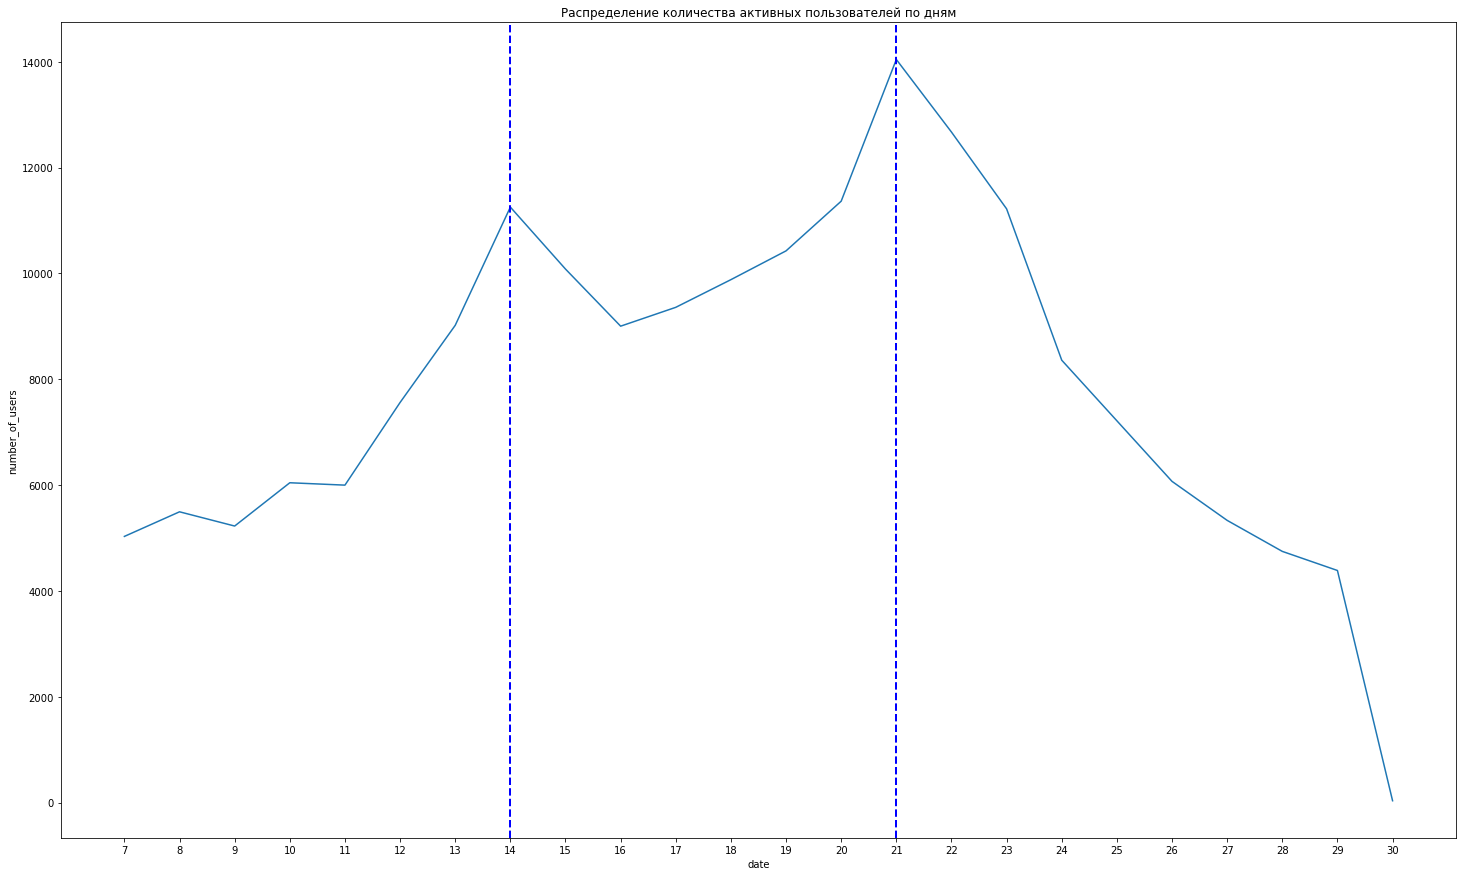

In [51]:
pylab.figure(figsize(25, 15))
plt.title('Распределение количества активных пользователей по дням')
plt.xticks(range(7,31))
ax=sns.lineplot(dau['date'], dau['number_of_users'])
plt.axvline(14, color='blue', linestyle="--", lw=2)
plt.axvline(21, color='blue', linestyle="--", lw=2)

Средний DAU:

In [52]:
dau['number_of_users'].mean()

7940.521739130435

Средняя доля пользователей, активных в день N:

In [53]:
mean(dau['number_of_users']/dau['sign'])

0.3000956345071904

### non-tested users

In [54]:
events1=pd.DataFrame(copy(non_tested_events), columns=non_tested_events.columns)
events1['date']=events1['event_dt'].apply(lambda x: x.day)

In [55]:
dau0 = pd.DataFrame(events1.groupby(['date'])['user_id'].nunique()).reset_index()
dau0.columns=['date', 'number_of_users']
dau0=dau0.sort_values('date')
dau0=dau0.reset_index(drop=True)
x=[0]*len(dau0)
for i in range(len(dau0)):
    x[i]=(dau0['date'][i]>=non_tested_users['first_date'].apply(lambda j:j.day)).sum()
dau0['sign']=x
dau0

,date,number_of_users,sign
0,7,3873,4080
1,8,4280,6440
2,9,3962,7933
3,10,4751,10154
4,11,4685,11878
5,12,5863,14658
6,13,7144,18030
7,14,8714,22133
8,15,7758,24331
9,16,6802,25832


График для пользователей, не участвующих в тестах, очень сильно похож на график для всех пользователей:

/Users/sergeyvikulin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


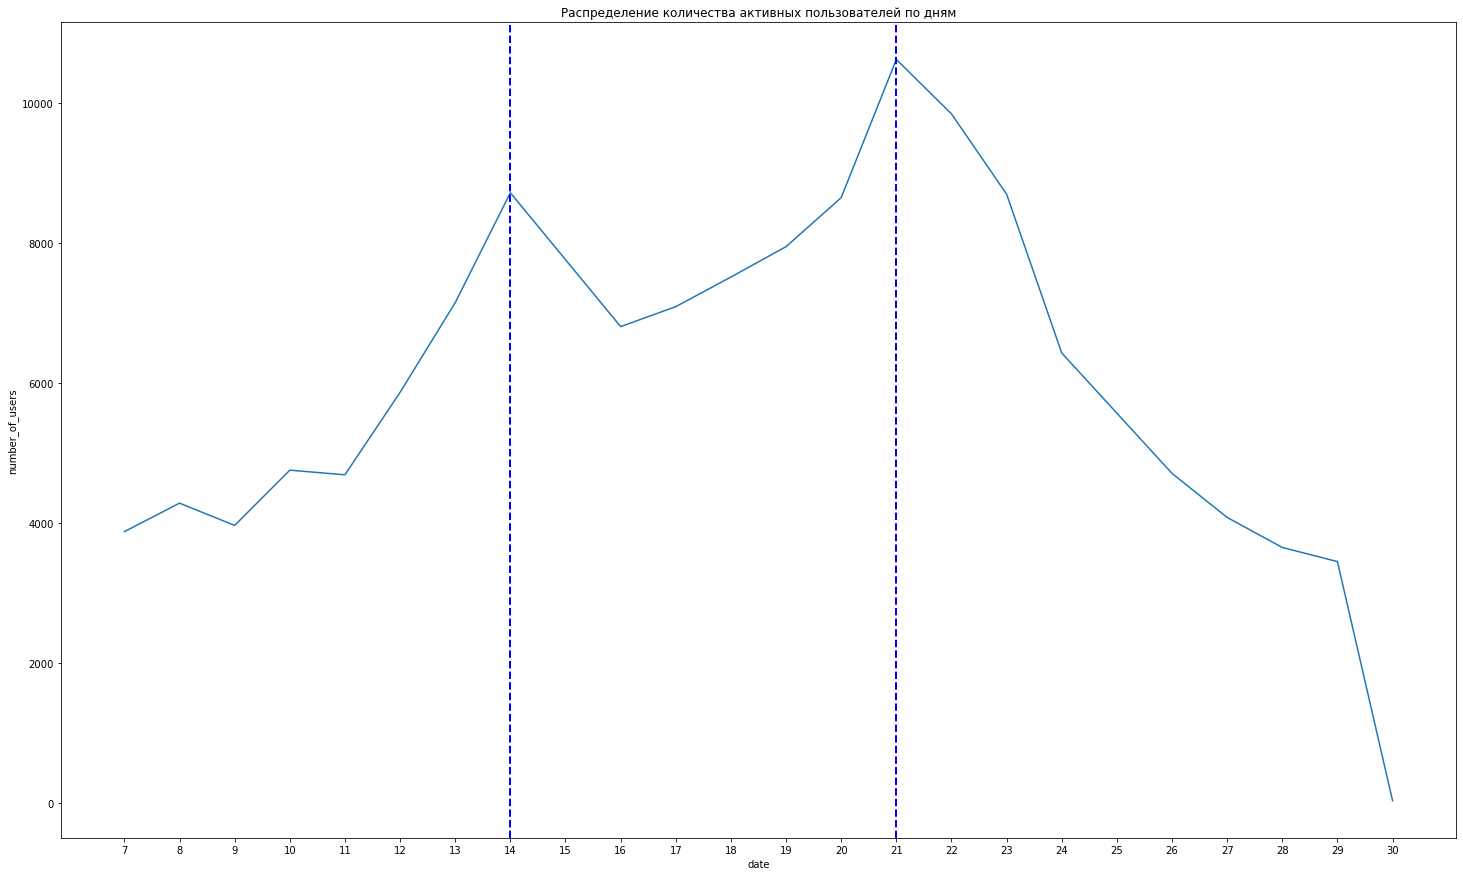

In [56]:
pylab.figure(figsize(25, 15))
plt.title('Распределение количества активных пользователей по дням')
plt.xticks(range(7,31))
ax=sns.lineplot(dau0['date'], dau0['number_of_users'])
plt.axvline(14, color='blue', linestyle="--", lw=2)
plt.axvline(21, color='blue', linestyle="--", lw=2)

Средний DAU:

In [57]:
dau0['number_of_users'].mean()

6108.565217391304

Средняя доля пользователей, активных в день N:

In [58]:
mean(dau0['number_of_users']/dau0['sign'])

0.3000543489044027

### recommender_system group A

In [59]:
events1=pd.DataFrame(copy(recommender_system_events_a), columns=recommender_system_events_a.columns)
events1['date']=events1['event_dt'].apply(lambda x: x.day)

In [60]:
dau1 = pd.DataFrame(events1.groupby(['date'])['user_id'].nunique()).reset_index()
dau1.columns=['date', 'number_of_users']
dau1=dau1.sort_values('date')
dau1=dau1.reset_index(drop=True)
x=[0]*len(dau1)
for i in range(len(dau1)):
    x[i]=(dau1['date'][i]>=recommender_system_contestants[recommender_system_contestants['group']=='A']['first_date'].
          apply(lambda j:j.day)).sum()
dau1['sign']=x
dau1

,date,number_of_users,sign
0,7,154,163
1,8,160,261
2,9,178,343
3,10,165,409
4,11,185,501
5,12,174,565
6,13,164,621
7,14,488,1008
8,15,473,1216
9,16,471,1385


Для пользователей из recommender_system group A количество ежедневных пользователей резко увеличилось после 13.12.2020, возрастало до 21.12.2020 и затем резко стало падать:

/Users/sergeyvikulin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


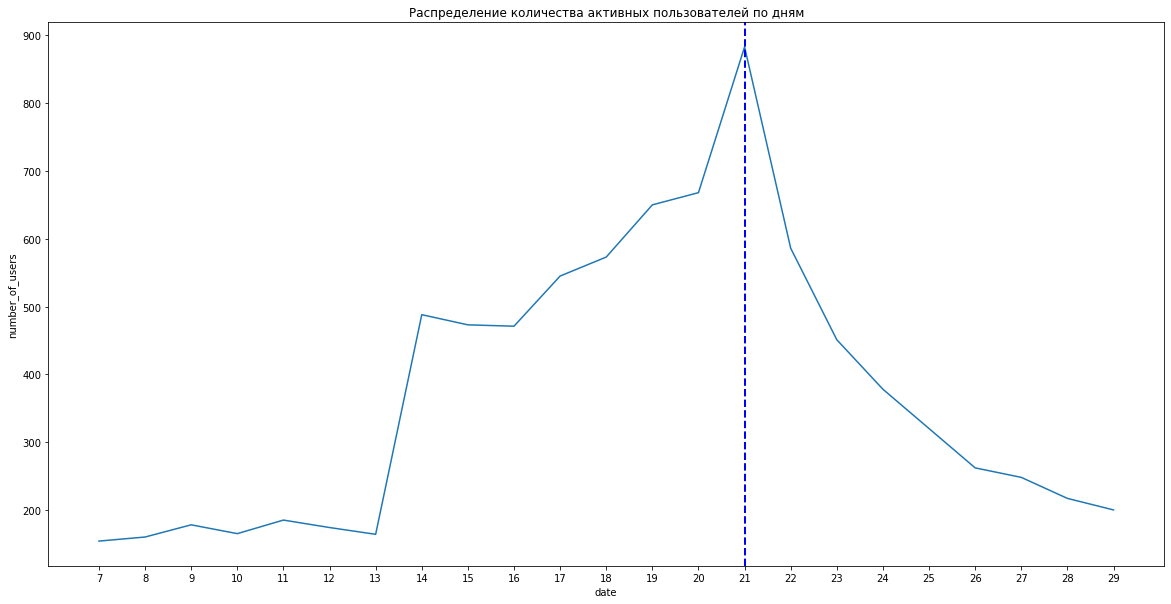

In [61]:
pylab.figure(figsize(20, 10))
plt.title('Распределение количества активных пользователей по дням')
plt.xticks(range(7,30))
ax=sns.lineplot(dau1['date'], dau1['number_of_users'])
plt.axvline(21, color='blue', linestyle="--", lw=2)

Средний DAU:

In [62]:
dau1['number_of_users'].mean()

376.04545454545456

Средняя доля пользователей, активных в день N:

In [63]:
mean(dau1['number_of_users']/dau1['sign'])

0.32127964643640977

### recommender_system group B

In [64]:
events1=pd.DataFrame(copy(recommender_system_events_b), columns=recommender_system_events_b.columns)
events1['date']=events1['event_dt'].apply(lambda x: x.day)

In [65]:
dau2 = pd.DataFrame(events1.groupby(['date'])['user_id'].nunique()).reset_index()
dau2.columns=['date', 'number_of_users']
dau2=dau2.sort_values('date')
dau2=dau2.reset_index(drop=True)
x=[0]*len(dau2)
for i in range(len(dau2)):
    x[i]=(dau2['date'][i]>=recommender_system_contestants[recommender_system_contestants['group']=='B']['first_date'].
          apply(lambda j:j.day)).sum()
dau2['sign']=x
dau2

,date,number_of_users,sign
0,7,173,182
1,8,120,226
2,9,172,311
3,10,131,344
4,11,89,365
5,12,106,418
6,13,87,433
7,14,131,505
8,15,116,537
9,16,172,636


Для пользователей из recommender_system group B количество ежедневных пользователей то падало, то возрастало до 21.12.2020, и затем резко стало падать. Скачкообразность графика можно объяснить малой выборкой recommender_system group B:

/Users/sergeyvikulin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


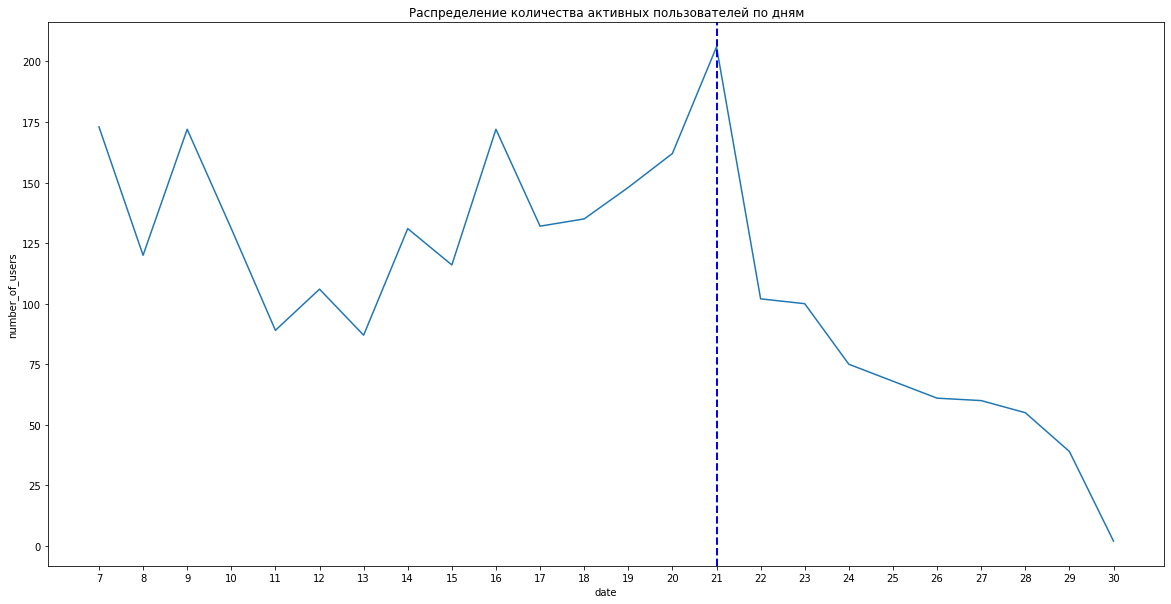

In [66]:
pylab.figure(figsize(20, 10))
plt.title('Распределение количества активных пользователей по дням')
plt.xticks(range(7,31))
ax=sns.lineplot(dau2['date'], dau2['number_of_users'])
plt.axvline(21, color='blue', linestyle="--", lw=2)

Средний DAU:

In [67]:
dau2['number_of_users'].mean()

111.91304347826087

Средняя доля пользователей, активных в день N:

In [68]:
mean(dau2['number_of_users']/dau2['sign'])

0.23397370198896508

**Вывод**:При проведении теста DAU для recommender_system group A (376.05) более чем в три раза превышает DAU recommender_system group B (111.91), при том, что количество пользователей больше примерно в 3 раза в group A. Средняя доля пользователей, активных в день N, больше для group A (0.321>0.234)

### interface_eu group A

In [69]:
events1=pd.DataFrame(copy(interface_eu_events_a), columns=interface_eu_events_a.columns)
events1['date']=events1['event_dt'].apply(lambda x: x.day)

In [70]:
dau3 = pd.DataFrame(events1.groupby(['date'])['user_id'].nunique()).reset_index()
dau3.columns=['date', 'number_of_users']
dau3=dau3.sort_values('date')
dau3=dau3.reset_index(drop=True)
x=[0]*len(dau3)
for i in range(len(dau3)):
    x[i]=(dau3['date'][i]>=interface_eu_contestants[interface_eu_contestants['group']=='A']['first_date'].
          apply(lambda j:j.day)).sum()
dau3['sign']=x
dau3

,date,number_of_users,sign
0,7,463,484
1,8,504,755
2,9,505,962
3,10,546,1208
4,11,545,1405
5,12,771,1794
6,13,852,2186
7,14,1071,2707
8,15,947,2980
9,16,896,3178


График для пользователей из interface_eu_events group A, очень сильно похож на график для всех пользователей и отражает основные тренды генеральной совокупности:

/Users/sergeyvikulin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


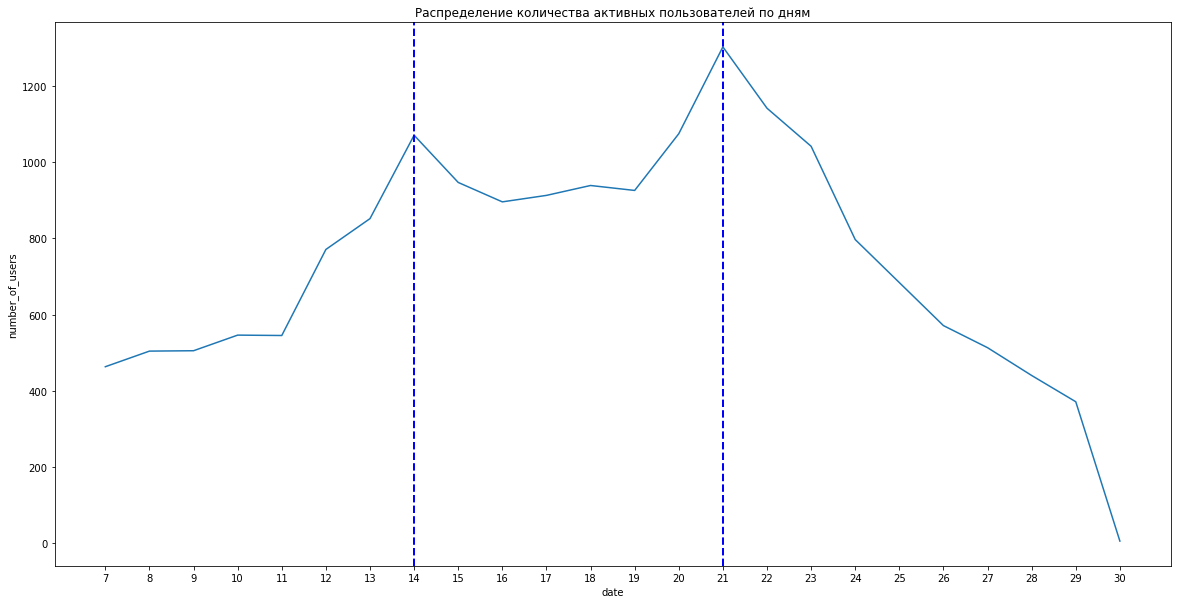

In [71]:
pylab.figure(figsize(20, 10))
plt.title('Распределение количества активных пользователей по дням')
plt.xticks(range(7,31))
ax=sns.lineplot(dau3['date'], dau3['number_of_users'])
plt.axvline(14, color='blue', linestyle="--", lw=2)
plt.axvline(21, color='blue', linestyle="--", lw=2)

Средний DAU:

In [72]:
dau3['number_of_users'].mean()

745.0869565217391

Средняя доля пользователей, активных в день N:

In [73]:
mean(dau3['number_of_users']/dau3['sign'])

0.3023726689184178

### interface_eu group B

In [74]:
events1=pd.DataFrame(copy(interface_eu_events_b), columns=interface_eu_events_b.columns)
events1['date']=events1['event_dt'].apply(lambda x: x.day)

In [75]:
dau4 = pd.DataFrame(events1.groupby(['date'])['user_id'].nunique()).reset_index()
dau4.columns=['date', 'number_of_users']
dau4=dau4.sort_values('date')
dau4=dau4.reset_index(drop=True)
x=[0]*len(dau4)
for i in range(len(dau4)):
    x[i]=(dau4['date'][i]>=interface_eu_contestants[interface_eu_contestants['group']=='B']['first_date'].
          apply(lambda j:j.day)).sum()
dau4['sign']=x
dau4

,date,number_of_users,sign
0,7,457,473
1,8,503,753
2,9,497,947
3,10,530,1184
4,11,569,1400
5,12,715,1734
6,13,838,2095
7,14,997,2568
8,15,928,2847
9,16,820,3032


График для пользователей из interface_eu_events group B, очень сильно похож на график для всех пользователей и отражает основные тренды генеральной совокупности:

/Users/sergeyvikulin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


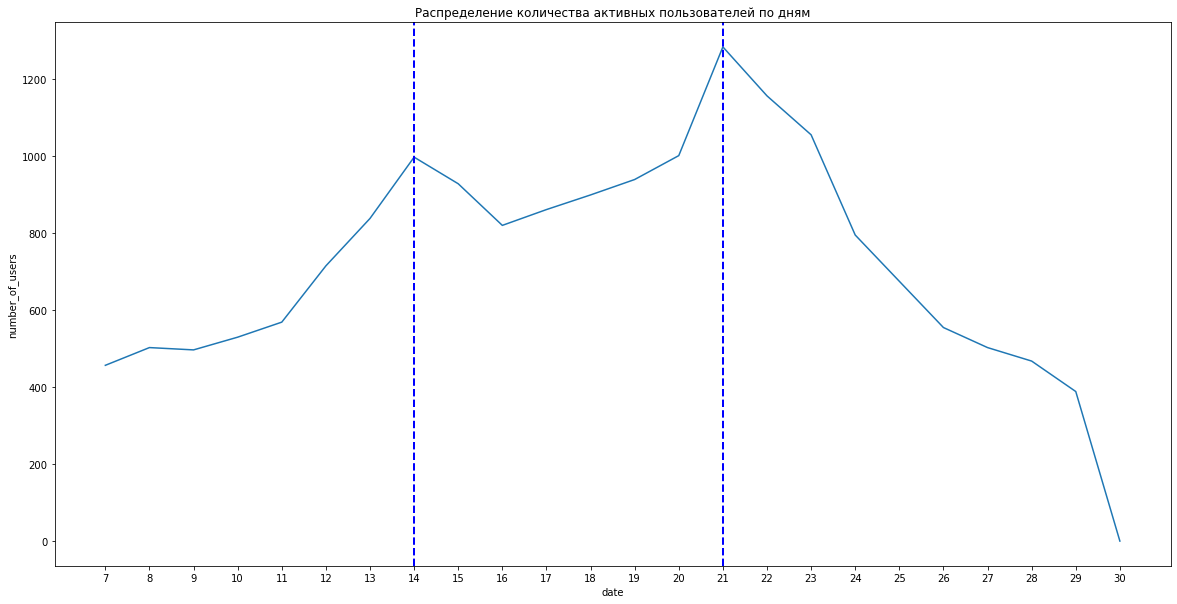

In [76]:
pylab.figure(figsize(20, 10))
plt.title('Распределение количества активных пользователей по дням')
plt.xticks(range(7,31))
ax=sns.lineplot(dau4['date'], dau4['number_of_users'])
plt.axvline(14, color='blue', linestyle="--", lw=2)
plt.axvline(21, color='blue', linestyle="--", lw=2)

Средний DAU:

In [77]:
dau4['number_of_users'].mean()

728.6521739130435

Средняя доля пользователей, активных в день N:

In [78]:
mean(dau4['number_of_users']/dau4['sign'])

0.3033572673242103

**Вывод**:При проведении теста DAU для interface_eu group A (745.09) больше DAU interface_eu group B (728.65), при том, что количество пользователей чуть больше в group A. Средняя доля пользователей, активных в день N, чуть больше для group B (0.302<0.303)

## WAU

Посчитаем уникальное количество пользователей, заходивших на сайт(сделавших хотя бы одно действие), для каждой недели, начиная с 07.12.2020:

Обозначим начало каждой недели:

In [79]:
i=dau['date'].min()
k=datetime.date(2020,12,i)
wau_dates=[]
while k<datetime.date(2020,12,dau['date'].max()):
    wau_dates.append(k)
    k=k+datetime.timedelta(weeks=1)
wau_dates

[datetime.date(2020, 12, 7),
 datetime.date(2020, 12, 14),
 datetime.date(2020, 12, 21),
 datetime.date(2020, 12, 28)]

### all users

In [80]:
wau_number=[0]*len(wau_dates)
for i in range(1,len(wau_dates)+1):
    if i==4:
        wau_number[i-1]=events[events['event_dt'].apply(lambda x:x.date())>=wau_dates[i-1]]['user_id'].nunique()
        
    else:
        wau_number[i-1]=events[(events['event_dt'].apply(lambda x:x.date())<wau_dates[i])&
                        (events['event_dt'].apply(lambda x:x.date())>=wau_dates[i-1])]['user_id'].nunique()
wau_number

[23073, 39430, 34325, 8759]

Больше всего активных пользователей наблюдалось во вторую неделю теста:

In [81]:
wau=pd.DataFrame({'date':wau_dates, 'number_of_users':wau_number})
x=[0]*len(wau)
for i in range(1,len(wau)):
    x[i-1]=(wau['date'][i].day>newusers['first_date'].apply(lambda j:j.day)).sum()
x[3]=len(newusers)
wau['sign']=x
wau

,date,number_of_users,sign
0,2020-12-07,23073,23100
1,2020-12-14,39430,47363
2,2020-12-21,34325,58703
3,2020-12-28,8759,58703


Средний WAU:

In [82]:
mean(wau_number)

26396.75

Средняя доля активных пользователей в неделю N:

In [83]:
mean(wau['number_of_users']/wau['sign'])

0.641317345496333

### non-tested users

In [84]:
wau_number=[0]*len(wau_dates)
for i in range(1,len(wau_dates)+1):
    if i==4:
        wau_number[i-1]=non_tested_events[non_tested_events['event_dt'].apply(lambda x:x.date())>=wau_dates[i-1]]['user_id'].nunique()
        
    else:
        wau_number[i-1]=non_tested_events[(non_tested_events['event_dt'].apply(lambda x:x.date())<wau_dates[i])&
                        (non_tested_events['event_dt'].apply(lambda x:x.date())>=wau_dates[i-1])]['user_id'].nunique()
wau_number

[18008, 30161, 26352, 6794]

Больше всего активных пользователей наблюдалось во вторую неделю теста:

In [85]:
wau0=pd.DataFrame({'date':wau_dates, 'number_of_users':wau_number})
x=[0]*len(wau0)
for i in range(1,len(wau0)):
    x[i-1]=(wau0['date'][i].day>non_tested_users['first_date'].apply(lambda j:j.day)).sum()
x[3]=len(non_tested_users)
wau0['sign']=x
wau0

,date,number_of_users,sign
0,2020-12-07,18008,18030
1,2020-12-14,30161,36238
2,2020-12-21,26352,45065
3,2020-12-28,6794,45065


Средний WAU:

In [86]:
mean(wau_number)

20328.75

Средняя доля активных пользователей в неделю N:

In [87]:
mean(wau0['number_of_users']/wau0['sign'])

0.6416495713383639

### recommender_system group A

In [88]:
wau_number=[0]*len(wau_dates)
for i in range(1,len(wau_dates)+1):
    if i==4:
        wau_number[i-1]=recommender_system_events_a[recommender_system_events_a['event_dt'].apply(lambda x:x.date())>=wau_dates[i-1]]['user_id'].nunique()
        
    else:
        wau_number[i-1]=recommender_system_events_a[(recommender_system_events_a['event_dt'].apply(lambda x:x.date())<wau_dates[i])&
                        (recommender_system_events_a['event_dt'].apply(lambda x:x.date())>=wau_dates[i-1])]['user_id'].nunique()
wau_number

[621, 2044, 1656, 402]

Больше всего активных пользователей наблюдалось во вторую неделю теста:

In [89]:
wau1=pd.DataFrame({'date':wau_dates, 'number_of_users':wau_number})
x=[0]*len(wau1)
for i in range(1,len(wau1)):
    x[i-1]=(wau1['date'][i].day>
            recommender_system_contestants[recommender_system_contestants['group']=='A']['first_date'].apply(lambda j:j.day)).sum()
x[3]=len(recommender_system_contestants[recommender_system_contestants['group']=='A'])
wau1['sign']=x
wau1

,date,number_of_users,sign
0,2020-12-07,621,621
1,2020-12-14,2044,2330
2,2020-12-21,1656,2747
3,2020-12-28,402,2747


Средний WAU:

In [90]:
mean(wau_number)

1180.75

Средняя доля активных пользователей в неделю N:

In [91]:
mean(wau1['number_of_users']/wau1['sign'])

0.656608535882297

### recommender_system group B

In [92]:
wau_number=[0]*len(wau_dates)
for i in range(1,len(wau_dates)+1):
    if i==4:
        wau_number[i-1]=recommender_system_events_b[recommender_system_events_b['event_dt'].apply(lambda x:x.date())>=wau_dates[i-1]]['user_id'].nunique()
        
    else:
        wau_number[i-1]=recommender_system_events_b[(recommender_system_events_b['event_dt'].apply(lambda x:x.date())<wau_dates[i])&
                        (recommender_system_events_b['event_dt'].apply(lambda x:x.date())>=wau_dates[i-1])]['user_id'].nunique()
wau_number

[432, 614, 414, 92]

Больше всего активных пользователей наблюдалось во вторую неделю теста:

In [93]:
wau2=pd.DataFrame({'date':wau_dates, 'number_of_users':wau_number})
x=[0]*len(wau2)
for i in range(1,len(wau2)):
    x[i-1]=(wau2['date'][i].day>
            recommender_system_contestants[recommender_system_contestants['group']=='B']['first_date'].apply(lambda j:j.day)).sum()
x[3]=len(recommender_system_contestants[recommender_system_contestants['group']=='B'])
wau2['sign']=x
wau2

,date,number_of_users,sign
0,2020-12-07,432,433
1,2020-12-14,614,835
2,2020-12-21,414,928
3,2020-12-28,92,928


Средний WAU:

In [94]:
mean(wau_number)

388.0

Средняя доля активных пользователей в неделю N:

In [95]:
mean(wau2['number_of_users']/wau2['sign'])

0.5695696232962124

**Вывод**: При проведении теста WAU для recommender_system group A (1180.75) более чем в три раза превышает WAU recommender_system group B (388.0), при том, что количество пользователей больше примерно в 3 раза в group A. Средняя доля пользователей, активных в день N, больше для group A (0.657>0.57)

### interface_eu group A

In [96]:
wau_number=[0]*len(wau_dates)
for i in range(1,len(wau_dates)+1):
    if i==4:
        wau_number[i-1]=interface_eu_events_a[interface_eu_events_a['event_dt'].apply(lambda x:x.date())>=wau_dates[i-1]]['user_id'].nunique()
        
    else:
        wau_number[i-1]=interface_eu_events_a[(interface_eu_events_a['event_dt'].apply(lambda x:x.date())<wau_dates[i])&
                        (interface_eu_events_a['event_dt'].apply(lambda x:x.date())>=wau_dates[i-1])]['user_id'].nunique()
wau_number

[2184, 3670, 3192, 778]

Больше всего активных пользователей наблюдалось во вторую неделю теста:

In [97]:
wau3=pd.DataFrame({'date':wau_dates, 'number_of_users':wau_number})
x=[0]*len(wau3)
for i in range(1,len(wau3)):
    x[i-1]=(wau3['date'][i].day>
            interface_eu_contestants[interface_eu_contestants['group']=='A']['first_date'].apply(lambda j:j.day)).sum()
x[3]=len(interface_eu_contestants[interface_eu_contestants['group']=='A'])
wau3['sign']=x
wau3

,date,number_of_users,sign
0,2020-12-07,2184,2186
1,2020-12-14,3670,4406
2,2020-12-21,3192,5467
3,2020-12-28,778,5467


Средний WAU:

In [98]:
mean(wau_number)

2456.0

Средняя доля активных пользователей в неделю N:

In [99]:
mean(wau3['number_of_users']/wau3['sign'])

0.6395538453535756

### interface_eu group B

In [100]:
wau_number=[0]*len(wau_dates)
for i in range(1,len(wau_dates)+1):
    if i==4:
        wau_number[i-1]=interface_eu_events_b[interface_eu_events_b['event_dt'].apply(lambda x:x.date())>=wau_dates[i-1]]['user_id'].nunique()
        
    else:
        wau_number[i-1]=interface_eu_events_b[(interface_eu_events_b['event_dt'].apply(lambda x:x.date())<wau_dates[i])&
                        (interface_eu_events_b['event_dt'].apply(lambda x:x.date())>=wau_dates[i-1])]['user_id'].nunique()
wau_number

[2093, 3572, 3186, 826]

Больше всего активных пользователей наблюдалось во вторую неделю теста:

In [101]:
wau4=pd.DataFrame({'date':wau_dates, 'number_of_users':wau_number})
x=[0]*len(wau4)
for i in range(1,len(wau4)):
    x[i-1]=(wau4['date'][i].day>
            interface_eu_contestants[interface_eu_contestants['group']=='B']['first_date'].apply(lambda j:j.day)).sum()
x[3]=len(interface_eu_contestants[interface_eu_contestants['group']=='B'])
wau4['sign']=x
wau4

,date,number_of_users,sign
0,2020-12-07,2093,2095
1,2020-12-14,3572,4310
2,2020-12-21,3186,5383
3,2020-12-28,826,5383


Средний WAU:

In [102]:
mean(wau_number)

2419.25

Средняя доля активных пользователей в неделю N:

In [103]:
mean(wau4['number_of_users']/wau4['sign'])

0.643281238691005

**Вывод**: При проведении теста WAU для interface_eu group A (2456.0) больше WAU interface_eu group B (2419.25), при том, что количество пользователей чуть больше в group A. Средняя доля пользователей, активных в день N, чуть больше для group B (0.64<0.643)

## MAU

Посчитаем уникальное количество пользователей, заходивших на сайт(сделавших хотя бы одно действие), для единственного месяца-декабря:

Каждый зарегистрировавшийся пользователь сделал хотя бы одно действие, поэтому MAU для каждой группы равен численностью этой группы:

### all users

In [104]:
events['user_id'].nunique()

58703

### non-tested users

In [105]:
non_tested_events['user_id'].nunique()

45065

### recommender_system group A

In [106]:
recommender_system_events_a['user_id'].nunique()

2747

### recommender_system group B

In [107]:
recommender_system_events_b['user_id'].nunique()

928

**Вывод**: При проведении теста MAU для recommender_system group A больше MAU recommender_system group B, так как численность group A больше численности group B

### interface_eu group A

In [108]:
interface_eu_events_a['user_id'].nunique()

5467

### interface_eu group B

In [109]:
interface_eu_events_b['user_id'].nunique()

5383

**Вывод**: При проведении теста MAU для interface_eu group A больше MAU interface_eu group B, так как численность group A больше численности group B

## Sticky factor

Рассчитаем sticky factor-степень лояльности и вовлеченности аудитории:

### all users

Недельный Sticky factor:

In [110]:
dau['number_of_users'].mean()/wau['number_of_users'].mean()

0.30081437067557315

Месячный Sticky factor:

In [111]:
dau['number_of_users'].mean()/events['user_id'].nunique()

0.1352660296599907

### non-tested users

Недельный Sticky factor:

In [112]:
dau0['number_of_users'].mean()/wau0['number_of_users'].mean()

0.30048897336979913

Месячный Sticky factor:

In [113]:
dau0['number_of_users'].mean()/non_tested_events['user_id'].nunique()

0.1355500991321714

### recommender_system group A

Недельный Sticky factor:

In [114]:
dau1['number_of_users'].mean()/wau1['number_of_users'].mean()

0.31848016476430624

Месячный Sticky factor:

In [115]:
dau1['number_of_users'].mean()/recommender_system_events_a['user_id'].nunique()

0.1368931396233908

### recommender_system group B

Недельный Sticky factor:

In [116]:
dau2['number_of_users'].mean()/wau2['number_of_users'].mean()

0.2884356790676827

Месячный Sticky factor:

In [117]:
dau2['number_of_users'].mean()/recommender_system_events_b['user_id'].nunique()

0.12059595202398801

**Вывод**: При проведении теста Недельный Sticky factor для recommender_system group A (0.318) больше недельного Sticky factor для recommender_system group B (0.288). При проведении теста Месячный Sticky factor для recommender_system group A (0.137) больше месячного Sticky factor для recommender_system group B (0.12).

### interface_eu group A

Недельный Sticky factor:

In [118]:
dau3['number_of_users'].mean()/wau3['number_of_users'].mean()

0.3033741679648775

Месячный Sticky factor:

In [119]:
dau3['number_of_users'].mean()/interface_eu_events_a['user_id'].nunique()

0.13628808423664518

### interface_eu group B

Недельный Sticky factor:

In [120]:
dau4['number_of_users'].mean()/wau4['number_of_users'].mean()

0.3011892834196728

Месячный Sticky factor:

In [121]:
dau4['number_of_users'].mean()/interface_eu_events_b['user_id'].nunique()

0.13536172653038148

**Вывод**: При проведении теста Недельный Sticky factor для interface_eu group A (0.303) больше недельного Sticky factor для interface_eu group B (0.301).При проведении теста Месячный Sticky factor для interface_eu group A (0.136) больше месячного Sticky factor для interface_eu group B (0.135).

## ARPU

Рассчитаем среднюю выручку с пользователя, совершившего подписку:

### all users

In [122]:
revenue=pd.DataFrame(events.groupby('user_id')['details'].sum()).reset_index()
revenue

,user_id,details
0,0001710F4DDB1D1B,0.00
1,000199F1887AE5E6,114.96
2,0002499E372175C7,14.97
3,0002CE61FF2C4011,0.00
4,000456437D0EFFE1,0.00
...,...,...
58698,FFF7A7BAF44FE9B4,0.00
58699,FFF8FDBE2FE99C91,19.96
58700,FFF91B6C5431F375,0.00
58701,FFFAB034A09DCC28,0.00


ARPU:

In [123]:
revenue['details'].mean()

24.53659710746687

### non-tested users

In [124]:
revenue0=pd.DataFrame(non_tested_events.groupby('user_id')['details'].sum()).reset_index()
revenue0

,user_id,details
0,0001710F4DDB1D1B,0.00
1,000199F1887AE5E6,114.96
2,0002499E372175C7,14.97
3,000456437D0EFFE1,0.00
4,0004DAF30B04CCF1,0.00
...,...,...
45060,FFF7A7BAF44FE9B4,0.00
45061,FFF8FDBE2FE99C91,19.96
45062,FFF91B6C5431F375,0.00
45063,FFFAB034A09DCC28,0.00


ARPU:

In [125]:
revenue0['details'].mean()

24.635131476750402

### recommender_system group A

In [126]:
revenue1=pd.DataFrame(recommender_system_events_a.groupby('user_id')['details'].sum()).reset_index()
revenue1

,user_id,details
0,0010A1C096941592,24.96
1,00341D8401F0F665,0.00
2,003DF44D7589BBD4,0.00
3,00505E15A9D81546,0.00
4,006E3E4E232CE760,0.00
...,...,...
2742,FF44696E39039D29,0.00
2743,FF5A1CD38F5DD996,0.00
2744,FF5B24BCE4387F86,14.97
2745,FF825C1D791989B5,0.00


ARPU:

In [127]:
revenue1['details'].mean()

21.29215507826731

### recommender_system group B

In [128]:
revenue2=pd.DataFrame(recommender_system_events_b.groupby('user_id')['details'].sum()).reset_index()
revenue2

,user_id,details
0,001064FEAAB631A1,0.00
1,005E096DBD379BCF,104.98
2,015D1E3BB893349D,0.00
3,015FF3EC72C1F4F6,0.00
4,01B0B891CA513468,0.00
...,...,...
923,FE76759FE6BF8C68,34.95
924,FE8F9858BBE502D9,0.00
925,FEA0C585A53E7027,0.00
926,FF8CF7057415EB29,0.00


ARPU:

In [129]:
revenue2['details'].mean()

16.275161637930978

**Вывод**: При проведении теста ARPU для recommender_system group A (21.29) больше ARPU recommender_system group B (16.28)

### interface_eu group A

In [130]:
revenue3=pd.DataFrame(interface_eu_events_a.groupby('user_id')['details'].sum()).reset_index()
revenue3

,user_id,details
0,0002CE61FF2C4011,0.0
1,002412F1EB3F6E38,0.0
2,002540BE89C930FB,0.0
3,003346BB64227D0C,0.0
4,00341D8401F0F665,0.0
...,...,...
5462,FFC676CB3E0A60B8,0.0
5463,FFDA3BD9A090A179,0.0
5464,FFDC1BEFD27A66D5,0.0
5465,FFE600EEC4BA7685,0.0


ARPU:

In [131]:
revenue3['details'].mean()

26.697322114505443

### interface_eu group B

In [132]:
revenue4=pd.DataFrame(interface_eu_events_b.groupby('user_id')['details'].sum()).reset_index()
revenue4

,user_id,details
0,001064FEAAB631A1,0.00
1,001E72F50D1C48FA,0.00
2,0031F1B5E9FBF708,9.98
3,0036BE15EE4D319D,0.00
4,003F86A34B575D27,0.00
...,...,...
5378,FFE40BDB7364E966,19.97
5379,FFE5B14BD55C1C5C,0.00
5380,FFE7FC140521F5F6,19.96
5381,FFEFC0E55C1CCD4F,0.00


ARPU:

In [133]:
revenue4['details'].mean()

24.086810328813147

**Вывод**: При проведении теста ARPU для interface_eu group A (26.7) больше ARPU interface_eu group B (24.09)

## ARPPU

Рассчитаем среднюю выручку с пользователя, совершившего покупку на сайте:

### all users

In [134]:
paying_revenue=pd.DataFrame(events[events['details']>0].groupby('user_id')['details'].sum()).reset_index()
paying_revenue

,user_id,details
0,000199F1887AE5E6,114.96
1,0002499E372175C7,14.97
2,000921BDA987CB74,29.95
3,000C9C937826F4D9,99.99
4,000F1B87E2F87740,9.98
...,...,...
19563,FFE40BDB7364E966,19.97
19564,FFE7FC140521F5F6,19.96
19565,FFE95A70AA35C2FC,509.97
19566,FFF5109B2978CF53,114.96


ARPPU:

In [135]:
paying_revenue['details'].mean()

73.60853740799406

### non-tested users

In [136]:
paying_revenue0=pd.DataFrame(non_tested_events[non_tested_events['details']>0].groupby('user_id')['details'].sum()).reset_index()
paying_revenue0

,user_id,details
0,000199F1887AE5E6,114.96
1,0002499E372175C7,14.97
2,000921BDA987CB74,29.95
3,000C9C937826F4D9,99.99
4,000F1B87E2F87740,9.98
...,...,...
15000,FFDE80D2D1280A97,109.97
15001,FFE328FECAF08350,119.95
15002,FFE95A70AA35C2FC,509.97
15003,FFF5109B2978CF53,114.96


ARPPU:

In [137]:
paying_revenue0['details'].mean()

73.98748417192648

### recommender_system group A

In [138]:
paying_revenue1=pd.DataFrame(recommender_system_events_a[recommender_system_events_a['details']>0].groupby('user_id')['details'].sum()).reset_index()
paying_revenue1

,user_id,details
0,0010A1C096941592,24.96
1,0082295A41A867B5,24.95
2,00C1F5175586DFCF,19.97
3,01157AAD4401952B,999.98
4,0145A5A1EC388D99,104.98
...,...,...
867,FEC8EB9C054264BC,119.96
868,FEF5165C8A0DC6BD,14.97
869,FF2174A1AA0EAD20,9.99
870,FF4456FBA59116E3,19.96


ARPPU:

In [139]:
paying_revenue1['details'].mean()

67.07517201834897

### recommender_system group B

In [140]:
paying_revenue2=pd.DataFrame(recommender_system_events_b[recommender_system_events_b['details']>0].groupby('user_id')['details'].sum()).reset_index()
paying_revenue2

,user_id,details
0,005E096DBD379BCF,104.98
1,058CE187A2C73865,4.99
2,05DCEB320AC0EE44,14.97
3,064FE8E188AB79E1,4.99
4,0997EC1C4850B27B,514.96
...,...,...
251,FC26F4B7727C205D,14.98
252,FCA4F49B1A82FA6C,14.97
253,FCF9CA847EFA5A92,24.97
254,FD18B77214097771,9.98


ARPPU:

In [141]:
paying_revenue2['details'].mean()

58.997460937499795

**Вывод**: При проведении теста ARPPU для recommender_system group A (67.08) больше ARPPU recommender_system group B (59)

### interface_eu group A

In [142]:
paying_revenue3=pd.DataFrame(interface_eu_events_a[interface_eu_events_a['details']>0].groupby('user_id')['details'].sum()).reset_index()
paying_revenue3

,user_id,details
0,004C58ADE7CA8C4A,9.98
1,0053DD654C9513D6,14.97
2,0093130DFBF1DC6A,24.96
3,00C3BF17FD8CBFC9,29.96
4,00E8D06BF3E5A23B,14.97
...,...,...
1926,FED670E148BFA923,4.99
1927,FEF73CF9D50EBB2D,9.98
1928,FF01CE39AFA34A83,9.98
1929,FF1AF3B4FB596E23,34.96


ARPPU:

In [143]:
paying_revenue3['details'].mean()

75.58480580010422

### interface_eu group B

In [144]:
paying_revenue4=pd.DataFrame(interface_eu_events_b[interface_eu_events_b['details']>0].groupby('user_id')['details'].sum()).reset_index()
paying_revenue4

,user_id,details
0,0031F1B5E9FBF708,9.98
1,0050F43F34C955F4,499.99
2,0082295A41A867B5,24.95
3,0082A350AF0647FA,29.96
4,009F1C78D679CDEC,124.96
...,...,...
1777,FF827554725859E2,19.97
1778,FFA72985E689ABBB,214.96
1779,FFD58017F5FA2DAC,124.94
1780,FFE40BDB7364E966,19.97


ARPPU:

In [145]:
paying_revenue4['details'].mean()

72.76054994388393

**Вывод**: При проведении теста ARPPU для interface_eu group A (75.58) больше ARPPU interface_eu group B (72.76)

## Конверсия в покупку

Рассчитаем конверсию в покупку, то есть долю пользователей, совершивших покупку, из подписавшихся пользователей:

### all users

In [146]:
len(paying_revenue)/len(newusers)

0.3333390116348398

### non-tested users

In [147]:
len(paying_revenue0)/len(non_tested_users)

0.33296349717075335

### recommender_system group A

In [148]:
len(paying_revenue1)/2747

0.3174372042227885

### recommender_system group B

In [149]:
len(paying_revenue2)/928

0.27586206896551724

**Вывод**: При проведении теста конверсия в покупку для recommender_system group A (0.317) больше конверсии в покупку recommender_system group B (0.275)

### interface_eu group A

In [150]:
len(paying_revenue3)/5467

0.35321017011157857

### interface_eu group B

In [151]:
len(paying_revenue4)/5383

0.3310421697937953

**Вывод**: При проведении теста конверсия в покупку для interface_eu group A (0.353) больше конверсии в покупку interface_eu group B (0.331)

## AOV

Рассчитаем средний чек для каждого пользователя и средний чек для группы:

### all users

In [152]:
aov=pd.DataFrame(events.groupby('user_id')['details'].mean()).reset_index()
aov=aov.fillna(0)
aov

,user_id,details
0,0001710F4DDB1D1B,0.00
1,000199F1887AE5E6,28.74
2,0002499E372175C7,4.99
3,0002CE61FF2C4011,0.00
4,000456437D0EFFE1,0.00
...,...,...
58698,FFF7A7BAF44FE9B4,0.00
58699,FFF8FDBE2FE99C91,4.99
58700,FFF91B6C5431F375,0.00
58701,FFFAB034A09DCC28,0.00


AOV:

In [153]:
events['details'].mean()

23.88121928572978

### non-tested users

In [154]:
aov0=pd.DataFrame(non_tested_events.groupby('user_id')['details'].mean()).reset_index()
aov0=aov0.fillna(0)
aov0

,user_id,details
0,0001710F4DDB1D1B,0.00
1,000199F1887AE5E6,28.74
2,0002499E372175C7,4.99
3,000456437D0EFFE1,0.00
4,0004DAF30B04CCF1,0.00
...,...,...
45060,FFF7A7BAF44FE9B4,0.00
45061,FFF8FDBE2FE99C91,4.99
45062,FFF91B6C5431F375,0.00
45063,FFFAB034A09DCC28,0.00


AOV:

In [155]:
non_tested_events['details'].mean()

23.988379429551284

### recommender_system group A

In [156]:
aov1=pd.DataFrame(recommender_system_events_a.groupby('user_id')['details'].mean()).reset_index()
aov1=aov1.fillna(0)
aov1

,user_id,details
0,0010A1C096941592,6.24
1,00341D8401F0F665,0.00
2,003DF44D7589BBD4,0.00
3,00505E15A9D81546,0.00
4,006E3E4E232CE760,0.00
...,...,...
2742,FF44696E39039D29,0.00
2743,FF5A1CD38F5DD996,0.00
2744,FF5B24BCE4387F86,4.99
2745,FF825C1D791989B5,0.00


AOV:

In [157]:
recommender_system_events_a['details'].mean()

22.98214145383044

### recommender_system group B

In [158]:
aov2=pd.DataFrame(recommender_system_events_b.groupby('user_id')['details'].mean()).reset_index()
aov2=aov2.fillna(0)
aov2

,user_id,details
0,001064FEAAB631A1,0.00
1,005E096DBD379BCF,52.49
2,015D1E3BB893349D,0.00
3,015FF3EC72C1F4F6,0.00
4,01B0B891CA513468,0.00
...,...,...
923,FE76759FE6BF8C68,6.99
924,FE8F9858BBE502D9,0.00
925,FEA0C585A53E7027,0.00
926,FF8CF7057415EB29,0.00


AOV:

In [159]:
recommender_system_events_b['details'].mean()

22.711804511278018

**Вывод**: При проведении теста AOV для recommender_system group A (22.98) больше AOV recommender_system group B (22.71)

### interface_eu group A

In [160]:
aov3=pd.DataFrame(interface_eu_events_a.groupby('user_id')['details'].mean()).reset_index()
aov3=aov3.fillna(0)
aov3

,user_id,details
0,0002CE61FF2C4011,0.0
1,002412F1EB3F6E38,0.0
2,002540BE89C930FB,0.0
3,003346BB64227D0C,0.0
4,00341D8401F0F665,0.0
...,...,...
5462,FFC676CB3E0A60B8,0.0
5463,FFDA3BD9A090A179,0.0
5464,FFDC1BEFD27A66D5,0.0
5465,FFE600EEC4BA7685,0.0


AOV:

In [161]:
interface_eu_events_a['details'].mean()

24.029348040830712

### interface_eu group B

In [162]:
aov4=pd.DataFrame(interface_eu_events_b.groupby('user_id')['details'].mean()).reset_index()
aov4=aov4.fillna(0)
aov4

,user_id,details
0,001064FEAAB631A1,0.000000
1,001E72F50D1C48FA,0.000000
2,0031F1B5E9FBF708,4.990000
3,0036BE15EE4D319D,0.000000
4,003F86A34B575D27,0.000000
...,...,...
5378,FFE40BDB7364E966,6.656667
5379,FFE5B14BD55C1C5C,0.000000
5380,FFE7FC140521F5F6,4.990000
5381,FFEFC0E55C1CCD4F,0.000000


AOV:

In [163]:
interface_eu_events_b['details'].mean()

23.278150807901834

**Вывод**: При проведении теста AOV для interface_eu group A (24.02) больше AOV interface_eu group B (23.28)

## Среднее количество сессий

Будем считать одной сессией набор действий одного пользователя, для которого время между каждыми последовательными действиями не превышает 1 минуты. Посчитаем количество сессий для каждого пользователя и среднее количество сессий для группы:

### all users

In [164]:
events['before']=events.groupby('user_id')['event_dt'].shift(1)
events['before']=events['before'].fillna(events['event_dt'])
events=events.sort_values(by=['user_id', 'event_dt']).reset_index()
events

,index,user_id,event_dt,event_name,details,before
0,287825,0001710F4DDB1D1B,2020-12-14 20:20:40,login,NaN,2020-12-14 20:20:40
1,151268,0001710F4DDB1D1B,2020-12-14 20:20:41,product_page,NaN,2020-12-14 20:20:40
2,75594,0001710F4DDB1D1B,2020-12-14 20:20:42,product_cart,NaN,2020-12-14 20:20:41
3,298142,0001710F4DDB1D1B,2020-12-15 17:34:22,login,NaN,2020-12-14 20:20:42
4,158103,0001710F4DDB1D1B,2020-12-15 17:34:23,product_page,NaN,2020-12-15 17:34:22
...,...,...,...,...,...,...
423756,387380,FFFFE36C0F6E92DF,2020-12-23 05:09:13,login,NaN,2020-12-23 05:09:13
423757,108384,FFFFE36C0F6E92DF,2020-12-23 05:09:15,product_cart,NaN,2020-12-23 05:09:13
423758,405434,FFFFE36C0F6E92DF,2020-12-26 09:25:03,login,NaN,2020-12-23 05:09:15
423759,229174,FFFFE36C0F6E92DF,2020-12-26 09:25:04,product_page,NaN,2020-12-26 09:25:03


In [165]:
session=[1]*423761
for i in range(1,len(events)):
    if events['user_id'][i]==events['user_id'][i-1]:
        if (events['event_dt'][i]-events['before'][i]).total_seconds()>60:
            session[i]=session[i-1]+1
        else:
            session[i]=session[i-1]
events['session']=session
events

,index,user_id,event_dt,event_name,details,before,session
0,287825,0001710F4DDB1D1B,2020-12-14 20:20:40,login,NaN,2020-12-14 20:20:40,1
1,151268,0001710F4DDB1D1B,2020-12-14 20:20:41,product_page,NaN,2020-12-14 20:20:40,1
2,75594,0001710F4DDB1D1B,2020-12-14 20:20:42,product_cart,NaN,2020-12-14 20:20:41,1
3,298142,0001710F4DDB1D1B,2020-12-15 17:34:22,login,NaN,2020-12-14 20:20:42,2
4,158103,0001710F4DDB1D1B,2020-12-15 17:34:23,product_page,NaN,2020-12-15 17:34:22,2
...,...,...,...,...,...,...,...
423756,387380,FFFFE36C0F6E92DF,2020-12-23 05:09:13,login,NaN,2020-12-23 05:09:13,2
423757,108384,FFFFE36C0F6E92DF,2020-12-23 05:09:15,product_cart,NaN,2020-12-23 05:09:13,2
423758,405434,FFFFE36C0F6E92DF,2020-12-26 09:25:03,login,NaN,2020-12-23 05:09:15,3
423759,229174,FFFFE36C0F6E92DF,2020-12-26 09:25:04,product_page,NaN,2020-12-26 09:25:03,3


[Text(0, 0, '9.12219'),
 Text(0, 0, '25.738'),
 Text(0, 0, '30.191'),
 Text(0, 0, '20.7945'),
 Text(0, 0, '9.62472'),
 Text(0, 0, '3.3678'),
 Text(0, 0, '0.921588'),
 Text(0, 0, '0.189087'),
 Text(0, 0, '0.0425873'),
 Text(0, 0, '0.00851745')]

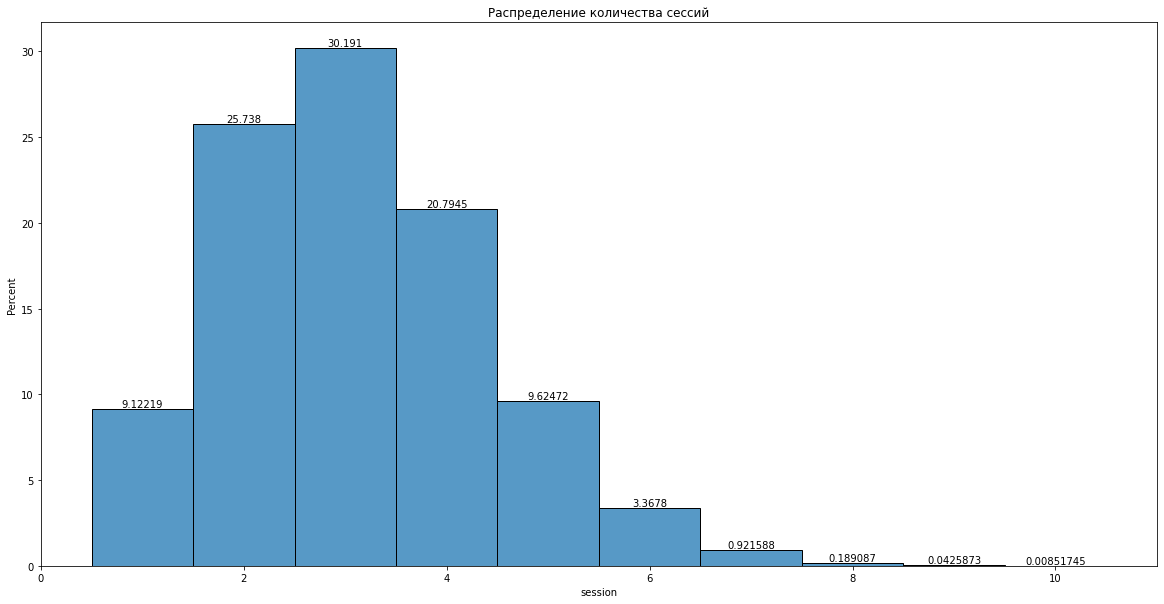

In [166]:
number_of_sessions=pd.DataFrame(events.groupby('user_id')['session'].max()).reset_index()
pylab.figure(figsize(20, 10))
plt.title('Распределение количества сессий')
ax=sns.histplot(number_of_sessions['session'], discrete=True, stat='percent')
ax.bar_label (ax.containers [ 0 ])

Среднее количество сессий:

In [167]:
number_of_sessions['session'].mean()

3.1111186821797863

### non-tested users

In [168]:
non_tested_events['before']=non_tested_events.groupby('user_id')['event_dt'].shift(1)
non_tested_events['before']=non_tested_events['before'].fillna(non_tested_events['event_dt'])
non_tested_events=non_tested_events.sort_values(by=['user_id', 'event_dt']).reset_index()
non_tested_events

,index,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,before
0,172926,0001710F4DDB1D1B,2020-12-14 20:20:40,login,NaN,2020-12-14,EU,Android,non_tested,non_tested,2020-12-14 20:20:40
1,172927,0001710F4DDB1D1B,2020-12-14 20:20:41,product_page,NaN,2020-12-14,EU,Android,non_tested,non_tested,2020-12-14 20:20:40
2,172928,0001710F4DDB1D1B,2020-12-14 20:20:42,product_cart,NaN,2020-12-14,EU,Android,non_tested,non_tested,2020-12-14 20:20:41
3,172929,0001710F4DDB1D1B,2020-12-15 17:34:22,login,NaN,2020-12-14,EU,Android,non_tested,non_tested,2020-12-14 20:20:42
4,172930,0001710F4DDB1D1B,2020-12-15 17:34:23,product_page,NaN,2020-12-14,EU,Android,non_tested,non_tested,2020-12-15 17:34:22
...,...,...,...,...,...,...,...,...,...,...,...
326633,309761,FFFFE36C0F6E92DF,2020-12-23 05:09:13,login,NaN,2020-12-22,N.America,Mac,non_tested,non_tested,2020-12-23 05:09:13
326634,309762,FFFFE36C0F6E92DF,2020-12-23 05:09:15,product_cart,NaN,2020-12-22,N.America,Mac,non_tested,non_tested,2020-12-23 05:09:13
326635,309763,FFFFE36C0F6E92DF,2020-12-26 09:25:03,login,NaN,2020-12-22,N.America,Mac,non_tested,non_tested,2020-12-23 05:09:15
326636,309764,FFFFE36C0F6E92DF,2020-12-26 09:25:04,product_page,NaN,2020-12-22,N.America,Mac,non_tested,non_tested,2020-12-26 09:25:03


In [169]:
session=[1]*326638
for i in range(1,len(non_tested_events)):
    if non_tested_events['user_id'][i]==non_tested_events['user_id'][i-1]:
        if (non_tested_events['event_dt'][i]-non_tested_events['before'][i]).total_seconds()>60:
            session[i]=session[i-1]+1
        else:
            session[i]=session[i-1]
non_tested_events['session']=session
non_tested_events

,index,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,before,session
0,172926,0001710F4DDB1D1B,2020-12-14 20:20:40,login,NaN,2020-12-14,EU,Android,non_tested,non_tested,2020-12-14 20:20:40,1
1,172927,0001710F4DDB1D1B,2020-12-14 20:20:41,product_page,NaN,2020-12-14,EU,Android,non_tested,non_tested,2020-12-14 20:20:40,1
2,172928,0001710F4DDB1D1B,2020-12-14 20:20:42,product_cart,NaN,2020-12-14,EU,Android,non_tested,non_tested,2020-12-14 20:20:41,1
3,172929,0001710F4DDB1D1B,2020-12-15 17:34:22,login,NaN,2020-12-14,EU,Android,non_tested,non_tested,2020-12-14 20:20:42,2
4,172930,0001710F4DDB1D1B,2020-12-15 17:34:23,product_page,NaN,2020-12-14,EU,Android,non_tested,non_tested,2020-12-15 17:34:22,2
...,...,...,...,...,...,...,...,...,...,...,...,...
326633,309761,FFFFE36C0F6E92DF,2020-12-23 05:09:13,login,NaN,2020-12-22,N.America,Mac,non_tested,non_tested,2020-12-23 05:09:13,2
326634,309762,FFFFE36C0F6E92DF,2020-12-23 05:09:15,product_cart,NaN,2020-12-22,N.America,Mac,non_tested,non_tested,2020-12-23 05:09:13,2
326635,309763,FFFFE36C0F6E92DF,2020-12-26 09:25:03,login,NaN,2020-12-22,N.America,Mac,non_tested,non_tested,2020-12-23 05:09:15,3
326636,309764,FFFFE36C0F6E92DF,2020-12-26 09:25:04,product_page,NaN,2020-12-22,N.America,Mac,non_tested,non_tested,2020-12-26 09:25:03,3


[Text(0, 0, '9.08909'),
 Text(0, 0, '25.6163'),
 Text(0, 0, '30.1919'),
 Text(0, 0, '20.8299'),
 Text(0, 0, '9.6261'),
 Text(0, 0, '3.42394'),
 Text(0, 0, '0.971929'),
 Text(0, 0, '0.197493'),
 Text(0, 0, '0.0421613'),
 Text(0, 0, '0.0110951')]

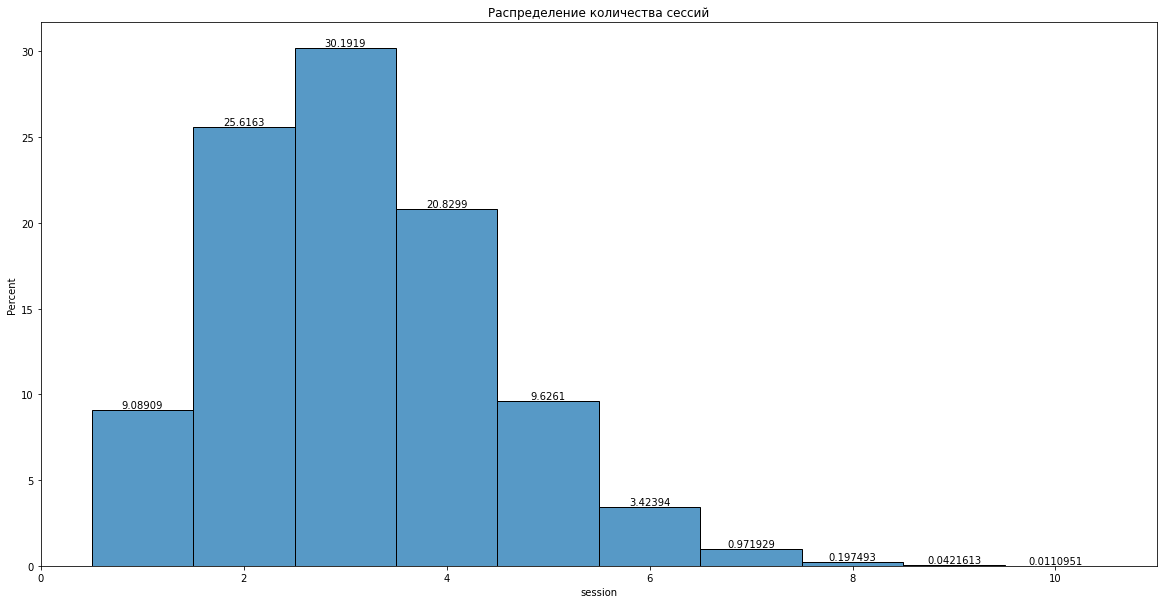

In [170]:
number_of_sessions0=pd.DataFrame(non_tested_events.groupby('user_id')['session'].max()).reset_index()
pylab.figure(figsize(20, 10))
plt.title('Распределение количества сессий')
ax=sns.histplot(number_of_sessions0['session'], discrete=True, stat='percent')
ax.bar_label (ax.containers [ 0 ])

Среднее количество сессий:

In [171]:
number_of_sessions0['session'].mean()

3.1176522800399424

### recommender_system group A

In [172]:
recommender_system_events_a['before']=recommender_system_events_a.groupby('user_id')['event_dt'].shift(1)
recommender_system_events_a['before']=recommender_system_events_a['before'].fillna(recommender_system_events_a['event_dt'])
recommender_system_events_a=recommender_system_events_a.sort_values(by=['user_id', 'event_dt']).reset_index()
recommender_system_events_a

/var/folders/m_/pktzsp9j7d10cx63t_w9_6pr0000gn/T/ipykernel_63074/3780343060.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommender_system_events_a['before']=recommender_system_events_a.groupby('user_id')['event_dt'].shift(1)
/var/folders/m_/pktzsp9j7d10cx63t_w9_6pr0000gn/T/ipykernel_63074/3780343060.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommender_system_events_a['before']=recommender_system_events_a['before'].fillna(recommender_system_events_a['event_dt'])


,index,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,before
0,15088,0010A1C096941592,2020-12-17 21:07:27,login,NaN,2020-12-17,EU,Android,A,recommender_system_test,2020-12-17 21:07:27
1,15089,0010A1C096941592,2020-12-17 21:07:27,product_page,NaN,2020-12-17,EU,Android,A,recommender_system_test,2020-12-17 21:07:27
2,15090,0010A1C096941592,2020-12-17 21:07:27,purchase,4.99,2020-12-17,EU,Android,A,recommender_system_test,2020-12-17 21:07:27
3,15091,0010A1C096941592,2020-12-19 04:34:37,purchase,4.99,2020-12-17,EU,Android,A,recommender_system_test,2020-12-17 21:07:27
4,15092,0010A1C096941592,2020-12-19 04:34:37,login,NaN,2020-12-17,EU,Android,A,recommender_system_test,2020-12-19 04:34:37
...,...,...,...,...,...,...,...,...,...,...,...
18622,6461,FFAE9489C76F352B,2020-12-13 18:46:06,product_page,NaN,2020-12-13,EU,Mac,A,recommender_system_test,2020-12-13 18:46:05
18623,6462,FFAE9489C76F352B,2020-12-15 20:14:51,login,NaN,2020-12-13,EU,Mac,A,recommender_system_test,2020-12-13 18:46:06
18624,6463,FFAE9489C76F352B,2020-12-15 20:14:55,product_page,NaN,2020-12-13,EU,Mac,A,recommender_system_test,2020-12-15 20:14:51
18625,6464,FFAE9489C76F352B,2020-12-19 11:32:50,login,NaN,2020-12-13,EU,Mac,A,recommender_system_test,2020-12-15 20:14:55


In [173]:
session=[1]*18627
for i in range(1,len(recommender_system_events_a)):
    if recommender_system_events_a['user_id'][i]==recommender_system_events_a['user_id'][i-1]:
        if (recommender_system_events_a['event_dt'][i]-recommender_system_events_a['before'][i]).total_seconds()>60:
            session[i]=session[i-1]+1
        else:
            session[i]=session[i-1]
recommender_system_events_a['session']=session
recommender_system_events_a

,index,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,before,session
0,15088,0010A1C096941592,2020-12-17 21:07:27,login,NaN,2020-12-17,EU,Android,A,recommender_system_test,2020-12-17 21:07:27,1
1,15089,0010A1C096941592,2020-12-17 21:07:27,product_page,NaN,2020-12-17,EU,Android,A,recommender_system_test,2020-12-17 21:07:27,1
2,15090,0010A1C096941592,2020-12-17 21:07:27,purchase,4.99,2020-12-17,EU,Android,A,recommender_system_test,2020-12-17 21:07:27,1
3,15091,0010A1C096941592,2020-12-19 04:34:37,purchase,4.99,2020-12-17,EU,Android,A,recommender_system_test,2020-12-17 21:07:27,2
4,15092,0010A1C096941592,2020-12-19 04:34:37,login,NaN,2020-12-17,EU,Android,A,recommender_system_test,2020-12-19 04:34:37,2
...,...,...,...,...,...,...,...,...,...,...,...,...
18622,6461,FFAE9489C76F352B,2020-12-13 18:46:06,product_page,NaN,2020-12-13,EU,Mac,A,recommender_system_test,2020-12-13 18:46:05,1
18623,6462,FFAE9489C76F352B,2020-12-15 20:14:51,login,NaN,2020-12-13,EU,Mac,A,recommender_system_test,2020-12-13 18:46:06,2
18624,6463,FFAE9489C76F352B,2020-12-15 20:14:55,product_page,NaN,2020-12-13,EU,Mac,A,recommender_system_test,2020-12-15 20:14:51,2
18625,6464,FFAE9489C76F352B,2020-12-19 11:32:50,login,NaN,2020-12-13,EU,Mac,A,recommender_system_test,2020-12-15 20:14:55,3


[Text(0, 0, '8.48198'),
 Text(0, 0, '27.6301'),
 Text(0, 0, '32.1806'),
 Text(0, 0, '20.5315'),
 Text(0, 0, '8.55479'),
 Text(0, 0, '2.36622'),
 Text(0, 0, '0.254823')]

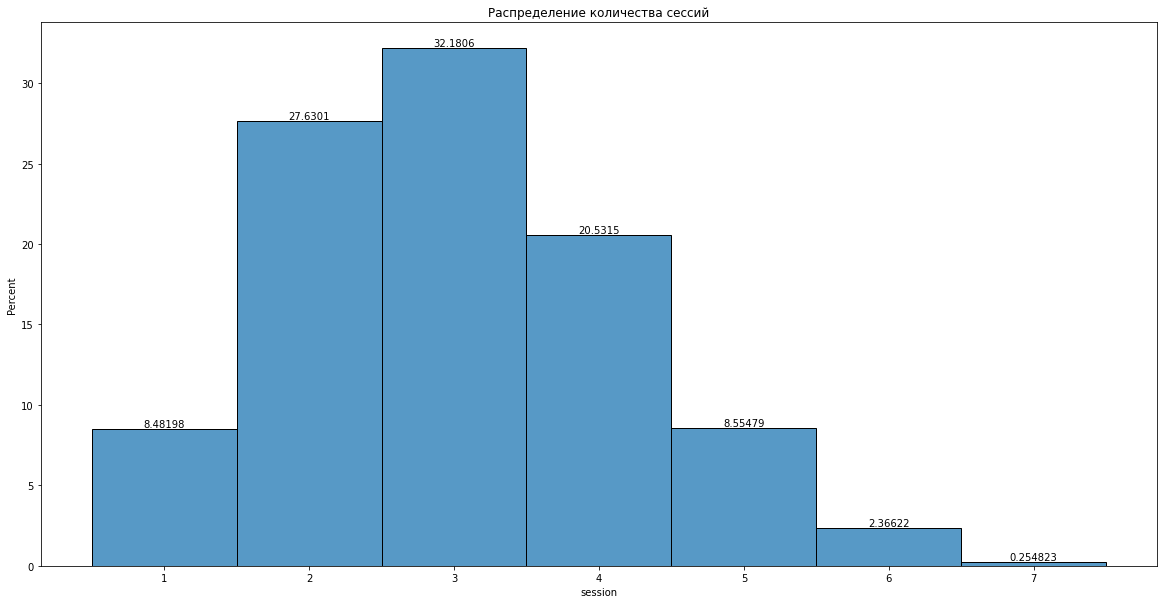

In [174]:
number_of_sessions1=pd.DataFrame(recommender_system_events_a.groupby('user_id')['session'].max()).reset_index()
pylab.figure(figsize(20, 10))
plt.title('Распределение количества сессий')
ax=sns.histplot(number_of_sessions1['session'], discrete=True, stat='percent')
ax.bar_label (ax.containers [ 0 ])

Среднее количество сессий:

In [175]:
number_of_sessions1['session'].mean()

3.0116490717145976

### recommender_system group B

In [176]:
recommender_system_events_b['before']=recommender_system_events_b.groupby('user_id')['event_dt'].shift(1)
recommender_system_events_b['before']=recommender_system_events_b['before'].fillna(recommender_system_events_b['event_dt'])
recommender_system_events_b=recommender_system_events_b.sort_values(by=['user_id', 'event_dt']).reset_index()
recommender_system_events_b

/var/folders/m_/pktzsp9j7d10cx63t_w9_6pr0000gn/T/ipykernel_63074/2630335388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommender_system_events_b['before']=recommender_system_events_b.groupby('user_id')['event_dt'].shift(1)
/var/folders/m_/pktzsp9j7d10cx63t_w9_6pr0000gn/T/ipykernel_63074/2630335388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommender_system_events_b['before']=recommender_system_events_b['before'].fillna(recommender_system_events_b['event_dt'])


,index,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,before
0,20173,001064FEAAB631A1,2020-12-20 14:43:27,login,NaN,2020-12-20,EU,Android,B,recommender_system_test,2020-12-20 14:43:27
1,20174,001064FEAAB631A1,2020-12-20 14:43:28,product_page,NaN,2020-12-20,EU,Android,B,recommender_system_test,2020-12-20 14:43:27
2,20175,001064FEAAB631A1,2020-12-21 03:19:15,login,NaN,2020-12-20,EU,Android,B,recommender_system_test,2020-12-20 14:43:28
3,20176,001064FEAAB631A1,2020-12-21 03:19:17,product_page,NaN,2020-12-20,EU,Android,B,recommender_system_test,2020-12-21 03:19:15
4,20177,001064FEAAB631A1,2020-12-26 15:55:17,login,NaN,2020-12-20,EU,Android,B,recommender_system_test,2020-12-21 03:19:17
...,...,...,...,...,...,...,...,...,...,...,...
5277,12242,FFF28D02B1EACBE1,2020-12-21 15:20:10,product_cart,NaN,2020-12-16,EU,PC,B,recommender_system_test,2020-12-21 15:20:08
5278,12243,FFF28D02B1EACBE1,2020-12-21 15:20:10,product_page,NaN,2020-12-16,EU,PC,B,recommender_system_test,2020-12-21 15:20:10
5279,12244,FFF28D02B1EACBE1,2020-12-24 00:51:04,login,NaN,2020-12-16,EU,PC,B,recommender_system_test,2020-12-21 15:20:10
5280,12245,FFF28D02B1EACBE1,2020-12-24 00:51:06,product_cart,NaN,2020-12-16,EU,PC,B,recommender_system_test,2020-12-24 00:51:04


In [177]:
session=[1]*5282
for i in range(1,len(recommender_system_events_b)):
    if recommender_system_events_b['user_id'][i]==recommender_system_events_b['user_id'][i-1]:
        if (recommender_system_events_b['event_dt'][i]-recommender_system_events_b['before'][i]).total_seconds()>60:
            session[i]=session[i-1]+1
        else:
            session[i]=session[i-1]
recommender_system_events_b['session']=session
recommender_system_events_b

,index,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,before,session
0,20173,001064FEAAB631A1,2020-12-20 14:43:27,login,NaN,2020-12-20,EU,Android,B,recommender_system_test,2020-12-20 14:43:27,1
1,20174,001064FEAAB631A1,2020-12-20 14:43:28,product_page,NaN,2020-12-20,EU,Android,B,recommender_system_test,2020-12-20 14:43:27,1
2,20175,001064FEAAB631A1,2020-12-21 03:19:15,login,NaN,2020-12-20,EU,Android,B,recommender_system_test,2020-12-20 14:43:28,2
3,20176,001064FEAAB631A1,2020-12-21 03:19:17,product_page,NaN,2020-12-20,EU,Android,B,recommender_system_test,2020-12-21 03:19:15,2
4,20177,001064FEAAB631A1,2020-12-26 15:55:17,login,NaN,2020-12-20,EU,Android,B,recommender_system_test,2020-12-21 03:19:17,3
...,...,...,...,...,...,...,...,...,...,...,...,...
5277,12242,FFF28D02B1EACBE1,2020-12-21 15:20:10,product_cart,NaN,2020-12-16,EU,PC,B,recommender_system_test,2020-12-21 15:20:08,2
5278,12243,FFF28D02B1EACBE1,2020-12-21 15:20:10,product_page,NaN,2020-12-16,EU,PC,B,recommender_system_test,2020-12-21 15:20:10,2
5279,12244,FFF28D02B1EACBE1,2020-12-24 00:51:04,login,NaN,2020-12-16,EU,PC,B,recommender_system_test,2020-12-21 15:20:10,3
5280,12245,FFF28D02B1EACBE1,2020-12-24 00:51:06,product_cart,NaN,2020-12-16,EU,PC,B,recommender_system_test,2020-12-24 00:51:04,3


[Text(0, 0, '15.5172'),
 Text(0, 0, '30.819'),
 Text(0, 0, '28.6638'),
 Text(0, 0, '15.3017'),
 Text(0, 0, '6.25'),
 Text(0, 0, '2.58621'),
 Text(0, 0, '0.646552'),
 Text(0, 0, '0.215517')]

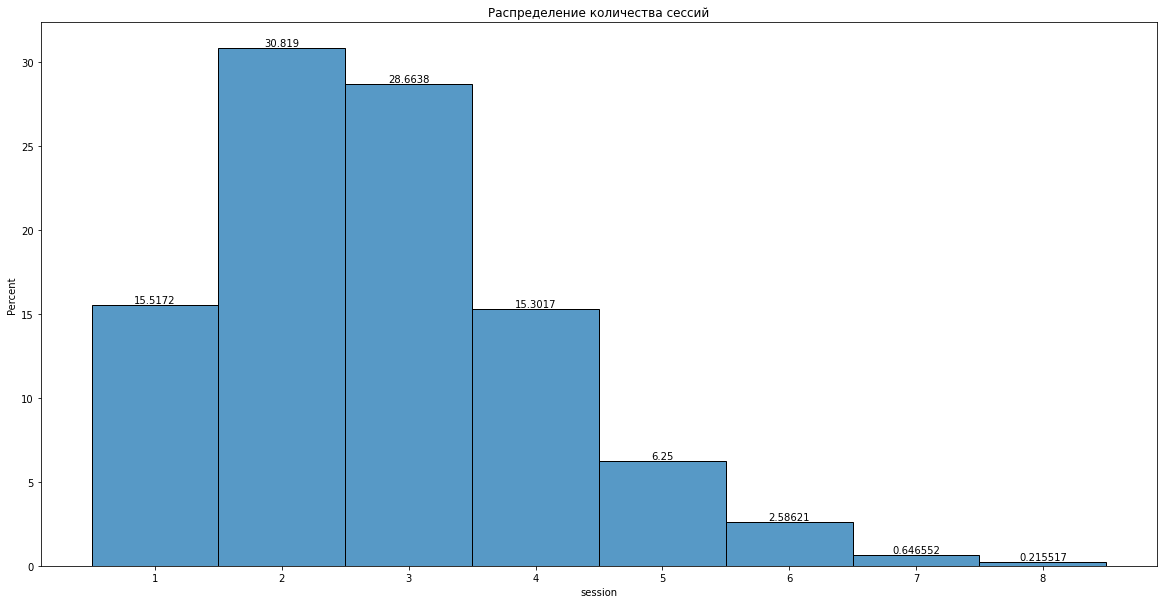

In [178]:
number_of_sessions2=pd.DataFrame(recommender_system_events_b.groupby('user_id')['session'].max()).reset_index()
pylab.figure(figsize(20, 10))
plt.title('Распределение количества сессий')
ax=sns.histplot(number_of_sessions2['session'], discrete=True, stat='percent')
ax.bar_label (ax.containers [ 0 ])

Среднее количество сессий:

In [179]:
number_of_sessions2['session'].mean()

2.773706896551724

**Вывод**: При проведении теста среднее количество сессий для recommender_system group A (3.01) больше среднего количества сессий recommender_system group B (2.77)

### interface_eu group A

In [180]:
interface_eu_events_a['before']=interface_eu_events_a.groupby('user_id')['event_dt'].shift(1)
interface_eu_events_a['before']=interface_eu_events_a['before'].fillna(interface_eu_events_a['event_dt'])
interface_eu_events_a=interface_eu_events_a.sort_values(by=['user_id', 'event_dt']).reset_index()
interface_eu_events_a

/var/folders/m_/pktzsp9j7d10cx63t_w9_6pr0000gn/T/ipykernel_63074/1296987466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interface_eu_events_a['before']=interface_eu_events_a.groupby('user_id')['event_dt'].shift(1)
/var/folders/m_/pktzsp9j7d10cx63t_w9_6pr0000gn/T/ipykernel_63074/1296987466.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interface_eu_events_a['before']=interface_eu_events_a['before'].fillna(interface_eu_events_a['event_dt'])


,index,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,before
0,1532,0002CE61FF2C4011,2020-12-07 04:37:36,login,NaN,2020-12-07,EU,Mac,A,interface_eu_test,2020-12-07 04:37:36
1,1533,0002CE61FF2C4011,2020-12-07 04:37:37,product_cart,NaN,2020-12-07,EU,Mac,A,interface_eu_test,2020-12-07 04:37:36
2,1534,0002CE61FF2C4011,2020-12-07 04:37:42,product_page,NaN,2020-12-07,EU,Mac,A,interface_eu_test,2020-12-07 04:37:37
3,1535,0002CE61FF2C4011,2020-12-08 22:14:18,login,NaN,2020-12-07,EU,Mac,A,interface_eu_test,2020-12-07 04:37:42
4,1536,0002CE61FF2C4011,2020-12-08 22:14:19,product_page,NaN,2020-12-07,EU,Mac,A,interface_eu_test,2020-12-08 22:14:18
...,...,...,...,...,...,...,...,...,...,...,...
40073,47675,FFF28D02B1EACBE1,2020-12-21 15:20:10,product_cart,NaN,2020-12-16,EU,PC,A,interface_eu_test,2020-12-21 15:20:08
40074,47676,FFF28D02B1EACBE1,2020-12-21 15:20:10,product_page,NaN,2020-12-16,EU,PC,A,interface_eu_test,2020-12-21 15:20:10
40075,47677,FFF28D02B1EACBE1,2020-12-24 00:51:04,login,NaN,2020-12-16,EU,PC,A,interface_eu_test,2020-12-21 15:20:10
40076,47678,FFF28D02B1EACBE1,2020-12-24 00:51:06,product_cart,NaN,2020-12-16,EU,PC,A,interface_eu_test,2020-12-24 00:51:04


In [181]:
session=[1]*40078
for i in range(1,len(interface_eu_events_a)):
    if interface_eu_events_a['user_id'][i]==interface_eu_events_a['user_id'][i-1]:
        if (interface_eu_events_a['event_dt'][i]-interface_eu_events_a['before'][i]).total_seconds()>60:
            session[i]=session[i-1]+1
        else:
            session[i]=session[i-1]
interface_eu_events_a['session']=session
interface_eu_events_a

,index,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,before,session
0,1532,0002CE61FF2C4011,2020-12-07 04:37:36,login,NaN,2020-12-07,EU,Mac,A,interface_eu_test,2020-12-07 04:37:36,1
1,1533,0002CE61FF2C4011,2020-12-07 04:37:37,product_cart,NaN,2020-12-07,EU,Mac,A,interface_eu_test,2020-12-07 04:37:36,1
2,1534,0002CE61FF2C4011,2020-12-07 04:37:42,product_page,NaN,2020-12-07,EU,Mac,A,interface_eu_test,2020-12-07 04:37:37,1
3,1535,0002CE61FF2C4011,2020-12-08 22:14:18,login,NaN,2020-12-07,EU,Mac,A,interface_eu_test,2020-12-07 04:37:42,2
4,1536,0002CE61FF2C4011,2020-12-08 22:14:19,product_page,NaN,2020-12-07,EU,Mac,A,interface_eu_test,2020-12-08 22:14:18,2
...,...,...,...,...,...,...,...,...,...,...,...,...
40073,47675,FFF28D02B1EACBE1,2020-12-21 15:20:10,product_cart,NaN,2020-12-16,EU,PC,A,interface_eu_test,2020-12-21 15:20:08,2
40074,47676,FFF28D02B1EACBE1,2020-12-21 15:20:10,product_page,NaN,2020-12-16,EU,PC,A,interface_eu_test,2020-12-21 15:20:10,2
40075,47677,FFF28D02B1EACBE1,2020-12-24 00:51:04,login,NaN,2020-12-16,EU,PC,A,interface_eu_test,2020-12-21 15:20:10,3
40076,47678,FFF28D02B1EACBE1,2020-12-24 00:51:06,product_cart,NaN,2020-12-16,EU,PC,A,interface_eu_test,2020-12-24 00:51:04,3


[Text(0, 0, '8.74337'),
 Text(0, 0, '25.6997'),
 Text(0, 0, '29.5592'),
 Text(0, 0, '21.3646'),
 Text(0, 0, '10.0055'),
 Text(0, 0, '3.51198'),
 Text(0, 0, '0.896287'),
 Text(0, 0, '0.164624'),
 Text(0, 0, '0.0548747')]

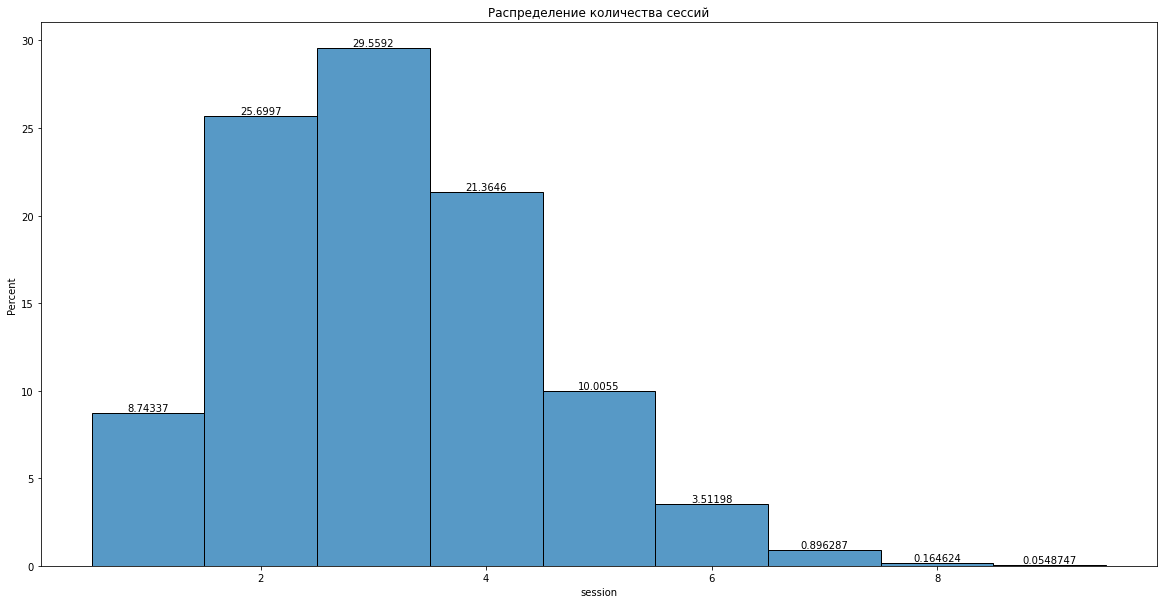

In [182]:
number_of_sessions3=pd.DataFrame(interface_eu_events_a.groupby('user_id')['session'].max()).reset_index()
pylab.figure(figsize(20, 10))
plt.title('Распределение количества сессий')
ax=sns.histplot(number_of_sessions3['session'], discrete=True, stat='percent')
ax.bar_label (ax.containers [ 0 ])

Среднее количество сессий:

In [183]:
number_of_sessions3['session'].mean()

3.1346259374428387

### interface_eu group B

In [184]:
interface_eu_events_b['before']=interface_eu_events_b.groupby('user_id')['event_dt'].shift(1)
interface_eu_events_b['before']=interface_eu_events_b['before'].fillna(interface_eu_events_b['event_dt'])
interface_eu_events_b=interface_eu_events_b.sort_values(by=['user_id', 'event_dt']).reset_index()
interface_eu_events_b

/var/folders/m_/pktzsp9j7d10cx63t_w9_6pr0000gn/T/ipykernel_63074/1253040735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interface_eu_events_b['before']=interface_eu_events_b.groupby('user_id')['event_dt'].shift(1)
/var/folders/m_/pktzsp9j7d10cx63t_w9_6pr0000gn/T/ipykernel_63074/1253040735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interface_eu_events_b['before']=interface_eu_events_b['before'].fillna(interface_eu_events_b['event_dt'])


,index,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,before
0,64420,001064FEAAB631A1,2020-12-20 14:43:27,login,NaN,2020-12-20,EU,Android,B,interface_eu_test,2020-12-20 14:43:27
1,64421,001064FEAAB631A1,2020-12-20 14:43:28,product_page,NaN,2020-12-20,EU,Android,B,interface_eu_test,2020-12-20 14:43:27
2,64422,001064FEAAB631A1,2020-12-21 03:19:15,login,NaN,2020-12-20,EU,Android,B,interface_eu_test,2020-12-20 14:43:28
3,64423,001064FEAAB631A1,2020-12-21 03:19:17,product_page,NaN,2020-12-20,EU,Android,B,interface_eu_test,2020-12-21 03:19:15
4,64424,001064FEAAB631A1,2020-12-26 15:55:17,login,NaN,2020-12-20,EU,Android,B,interface_eu_test,2020-12-21 03:19:17
...,...,...,...,...,...,...,...,...,...,...,...
38846,34742,FFEFC0E55C1CCD4F,2020-12-20 22:11:36,login,NaN,2020-12-13,EU,PC,B,interface_eu_test,2020-12-17 18:04:40
38847,34743,FFEFC0E55C1CCD4F,2020-12-28 00:25:08,login,NaN,2020-12-13,EU,PC,B,interface_eu_test,2020-12-20 22:11:36
38848,33247,FFF58BC33966EB51,2020-12-13 17:55:19,login,NaN,2020-12-13,EU,Android,B,interface_eu_test,2020-12-13 17:55:19
38849,33248,FFF58BC33966EB51,2020-12-15 04:48:35,login,NaN,2020-12-13,EU,Android,B,interface_eu_test,2020-12-13 17:55:19


In [185]:
session=[1]*38851
for i in range(1,len(interface_eu_events_b)):
    if interface_eu_events_b['user_id'][i]==interface_eu_events_b['user_id'][i-1]:
        if (interface_eu_events_b['event_dt'][i]-interface_eu_events_b['before'][i]).total_seconds()>60:
            session[i]=session[i-1]+1
        else:
            session[i]=session[i-1]
interface_eu_events_b['session']=session
interface_eu_events_b

,index,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,before,session
0,64420,001064FEAAB631A1,2020-12-20 14:43:27,login,NaN,2020-12-20,EU,Android,B,interface_eu_test,2020-12-20 14:43:27,1
1,64421,001064FEAAB631A1,2020-12-20 14:43:28,product_page,NaN,2020-12-20,EU,Android,B,interface_eu_test,2020-12-20 14:43:27,1
2,64422,001064FEAAB631A1,2020-12-21 03:19:15,login,NaN,2020-12-20,EU,Android,B,interface_eu_test,2020-12-20 14:43:28,2
3,64423,001064FEAAB631A1,2020-12-21 03:19:17,product_page,NaN,2020-12-20,EU,Android,B,interface_eu_test,2020-12-21 03:19:15,2
4,64424,001064FEAAB631A1,2020-12-26 15:55:17,login,NaN,2020-12-20,EU,Android,B,interface_eu_test,2020-12-21 03:19:17,3
...,...,...,...,...,...,...,...,...,...,...,...,...
38846,34742,FFEFC0E55C1CCD4F,2020-12-20 22:11:36,login,NaN,2020-12-13,EU,PC,B,interface_eu_test,2020-12-17 18:04:40,3
38847,34743,FFEFC0E55C1CCD4F,2020-12-28 00:25:08,login,NaN,2020-12-13,EU,PC,B,interface_eu_test,2020-12-20 22:11:36,4
38848,33247,FFF58BC33966EB51,2020-12-13 17:55:19,login,NaN,2020-12-13,EU,Android,B,interface_eu_test,2020-12-13 17:55:19,1
38849,33248,FFF58BC33966EB51,2020-12-15 04:48:35,login,NaN,2020-12-13,EU,Android,B,interface_eu_test,2020-12-13 17:55:19,2


[Text(0, 0, '9.15846'),
 Text(0, 0, '25.3948'),
 Text(0, 0, '30.5777'),
 Text(0, 0, '20.4533'),
 Text(0, 0, '10.0687'),
 Text(0, 0, '3.25098'),
 Text(0, 0, '0.835965'),
 Text(0, 0, '0.204347'),
 Text(0, 0, '0.055731')]

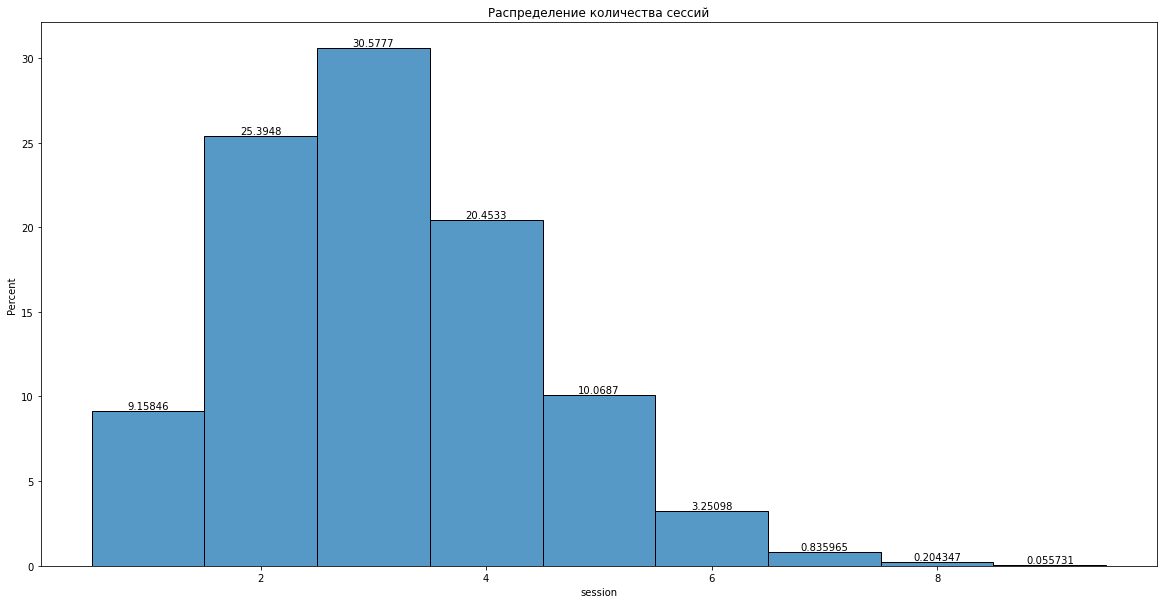

In [186]:
number_of_sessions4=pd.DataFrame(interface_eu_events_b.groupby('user_id')['session'].max()).reset_index()
pylab.figure(figsize(20, 10))
plt.title('Распределение количества сессий')
ax=sns.histplot(number_of_sessions4['session'], discrete=True, stat='percent')
ax.bar_label (ax.containers [ 0 ])

Среднее количество сессий:

In [187]:
number_of_sessions4['session'].mean()

3.1133197101987737

**Вывод**: При проведении теста среднее количество сессий для interface_eu group A (3.13) больше среднего количества сессий interface_eu group B (3.11)

## Среднее количество действий за сессию 

На основе посчитанного количества сессий для каждого пользователя вычислим среднее количество действий за одну сессию для каждого пользователя:

### all users

In [188]:
number_of_actions=pd.DataFrame(events.groupby(['user_id','session'])['event_dt'].count()).reset_index()
number_of_actions

,user_id,session,event_dt
0,0001710F4DDB1D1B,1,3
1,0001710F4DDB1D1B,2,3
2,000199F1887AE5E6,1,4
3,000199F1887AE5E6,2,4
4,000199F1887AE5E6,3,4
...,...,...,...
182627,FFFAB034A09DCC28,1,2
182628,FFFAB034A09DCC28,2,2
182629,FFFFE36C0F6E92DF,1,3
182630,FFFFE36C0F6E92DF,2,3


Среднее количество действий за сессию:

In [189]:
number_of_actions['event_dt'].mean()

2.320299837925446

### non-tested users

In [190]:
number_of_actions0=pd.DataFrame(non_tested_events.groupby(['user_id','session'])['event_dt'].count()).reset_index()
number_of_actions0

,user_id,session,event_dt
0,0001710F4DDB1D1B,1,3
1,0001710F4DDB1D1B,2,3
2,000199F1887AE5E6,1,4
3,000199F1887AE5E6,2,4
4,000199F1887AE5E6,3,4
...,...,...,...
140492,FFFAB034A09DCC28,1,2
140493,FFFAB034A09DCC28,2,2
140494,FFFFE36C0F6E92DF,1,3
140495,FFFFE36C0F6E92DF,2,3


Среднее количество действий за сессию:

In [191]:
number_of_actions0['event_dt'].mean()

2.3248752642405175

### recommender_system group A

In [192]:
number_of_actions1=pd.DataFrame(recommender_system_events_a.groupby(['user_id','session'])['event_dt'].count()).reset_index()
number_of_actions1

,user_id,session,event_dt
0,0010A1C096941592,1,3
1,0010A1C096941592,2,3
2,0010A1C096941592,3,3
3,0010A1C096941592,4,3
4,00341D8401F0F665,1,1
...,...,...,...
8268,FF825C1D791989B5,3,2
8269,FF825C1D791989B5,4,2
8270,FFAE9489C76F352B,1,2
8271,FFAE9489C76F352B,2,2


Среднее количество действий за сессию:

In [193]:
number_of_actions1['event_dt'].mean()

2.251541157983803

### recommender_system group B

In [194]:
number_of_actions2=pd.DataFrame(recommender_system_events_b.groupby(['user_id','session'])['event_dt'].count()).reset_index()
number_of_actions2

,user_id,session,event_dt
0,001064FEAAB631A1,1,2
1,001064FEAAB631A1,2,2
2,001064FEAAB631A1,3,2
3,005E096DBD379BCF,1,2
4,005E096DBD379BCF,2,2
...,...,...,...
2569,FEA0C585A53E7027,1,3
2570,FF8CF7057415EB29,1,2
2571,FFF28D02B1EACBE1,1,3
2572,FFF28D02B1EACBE1,2,3


Среднее количество действий за сессию:

In [195]:
number_of_actions2['event_dt'].mean()

2.052059052059052

**Вывод**: При проведении теста среднее количество действий за сессию для recommender_system group A (2.25) больше среднего количества действий за сессию recommender_system group B (2.05)

### interface_eu group A

In [196]:
number_of_actions3=pd.DataFrame(interface_eu_events_a.groupby(['user_id','session'])['event_dt'].count()).reset_index()
number_of_actions3

,user_id,session,event_dt
0,0002CE61FF2C4011,1,3
1,0002CE61FF2C4011,2,3
2,0002CE61FF2C4011,3,3
3,0002CE61FF2C4011,4,3
4,002412F1EB3F6E38,1,2
...,...,...,...
17132,FFE600EEC4BA7685,1,3
17133,FFE600EEC4BA7685,2,3
17134,FFF28D02B1EACBE1,1,3
17135,FFF28D02B1EACBE1,2,3


Среднее количество действий за сессию:

In [197]:
number_of_actions3['event_dt'].mean()

2.3386823831475754

### interface_eu group B

In [198]:
number_of_actions4=pd.DataFrame(interface_eu_events_b.groupby(['user_id','session'])['event_dt'].count()).reset_index()
number_of_actions4

,user_id,session,event_dt
0,001064FEAAB631A1,1,2
1,001064FEAAB631A1,2,2
2,001064FEAAB631A1,3,2
3,001E72F50D1C48FA,1,2
4,001E72F50D1C48FA,2,2
...,...,...,...
16754,FFEFC0E55C1CCD4F,3,1
16755,FFEFC0E55C1CCD4F,4,1
16756,FFF58BC33966EB51,1,1
16757,FFF58BC33966EB51,2,1


Среднее количество действий за сессию:

In [199]:
number_of_actions4['event_dt'].mean()

2.3182170773912523

**Вывод**: При проведении теста среднее количество действий за сессию для interface_eu group A (2.34) больше среднего количества действий за сессию interface_eu group B (2.32)

## Среднее время между сессиями

Посчитаем среднее время между сессиями для каждого пользователя:

In [200]:
f=pd.DataFrame(events.groupby(['user_id','session']).agg({'event_dt':['min','max']}))
f

event_dt                    
                                         min                 max
user_id          session                                        
0001710F4DDB1D1B 1       2020-12-14 20:20:40 2020-12-14 20:20:42
                 2       2020-12-15 17:34:22 2020-12-15 17:34:25
000199F1887AE5E6 1       2020-12-14 09:56:09 2020-12-14 09:56:11
                 2       2020-12-15 07:22:56 2020-12-15 07:22:56
                 3       2020-12-20 06:36:35 2020-12-20 06:36:36
...                                      ...                 ...
FFFAB034A09DCC28 1       2020-12-18 12:00:53 2020-12-18 12:00:55
                 2       2020-12-21 01:46:44 2020-12-21 01:46:45
FFFFE36C0F6E92DF 1       2020-12-22 11:38:57 2020-12-22 11:38:57
                 2       2020-12-23 05:09:13 2020-12-23 05:09:15
                 3       2020-12-26 09:25:03 2020-12-26 09:25:04

[182632 rows x 2 columns]

### all users

In [201]:
time_between_sessions=[0]*423761
for i in range(1,len(events)):
    if events['session'][i]!=events['session'][i-1]:
        if events['session'][i]!=1:
            time_between_sessions[i]=(events['event_dt'][i]-events['before'][i]).total_seconds()/86400
events['days_between_sessions']=time_between_sessions
events

,index,user_id,event_dt,event_name,details,before,session,days_between_sessions
0,287825,0001710F4DDB1D1B,2020-12-14 20:20:40,login,NaN,2020-12-14 20:20:40,1,0.000000
1,151268,0001710F4DDB1D1B,2020-12-14 20:20:41,product_page,NaN,2020-12-14 20:20:40,1,0.000000
2,75594,0001710F4DDB1D1B,2020-12-14 20:20:42,product_cart,NaN,2020-12-14 20:20:41,1,0.000000
3,298142,0001710F4DDB1D1B,2020-12-15 17:34:22,login,NaN,2020-12-14 20:20:42,2,0.884491
4,158103,0001710F4DDB1D1B,2020-12-15 17:34:23,product_page,NaN,2020-12-15 17:34:22,2,0.000000
...,...,...,...,...,...,...,...,...
423756,387380,FFFFE36C0F6E92DF,2020-12-23 05:09:13,login,NaN,2020-12-23 05:09:13,2,0.000000
423757,108384,FFFFE36C0F6E92DF,2020-12-23 05:09:15,product_cart,NaN,2020-12-23 05:09:13,2,0.000000
423758,405434,FFFFE36C0F6E92DF,2020-12-26 09:25:03,login,NaN,2020-12-23 05:09:15,3,3.177639
423759,229174,FFFFE36C0F6E92DF,2020-12-26 09:25:04,product_page,NaN,2020-12-26 09:25:03,3,0.000000


In [202]:
average_between_sessions=pd.DataFrame(events.groupby('user_id')['days_between_sessions'].sum()).reset_index()
average_between_sessions['days_between_sessions']=average_between_sessions['days_between_sessions']/(number_of_sessions['session']-1)
average_between_sessions

,user_id,days_between_sessions
0,0001710F4DDB1D1B,0.884491
1,000199F1887AE5E6,2.225737
2,0002499E372175C7,2.021916
3,0002CE61FF2C4011,2.779934
4,000456437D0EFFE1,11.409850
...,...,...
58698,FFF7A7BAF44FE9B4,3.009896
58699,FFF8FDBE2FE99C91,0.969086
58700,FFF91B6C5431F375,0.809059
58701,FFFAB034A09DCC28,2.573484


Среднее время между сессиями в днях:

In [203]:
average_between_sessions['days_between_sessions'].mean()

3.298673856338953

### non-tested users

In [204]:
time_between_sessions=[0]*326638
for i in range(1,len(non_tested_events)):
    if non_tested_events['session'][i]!=non_tested_events['session'][i-1]:
        if non_tested_events['session'][i]!=1:
            time_between_sessions[i]=(non_tested_events['event_dt'][i]-non_tested_events['before'][i]).total_seconds()/86400
non_tested_events['days_between_sessions']=time_between_sessions
non_tested_events

,index,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,before,session,days_between_sessions
0,172926,0001710F4DDB1D1B,2020-12-14 20:20:40,login,NaN,2020-12-14,EU,Android,non_tested,non_tested,2020-12-14 20:20:40,1,0.000000
1,172927,0001710F4DDB1D1B,2020-12-14 20:20:41,product_page,NaN,2020-12-14,EU,Android,non_tested,non_tested,2020-12-14 20:20:40,1,0.000000
2,172928,0001710F4DDB1D1B,2020-12-14 20:20:42,product_cart,NaN,2020-12-14,EU,Android,non_tested,non_tested,2020-12-14 20:20:41,1,0.000000
3,172929,0001710F4DDB1D1B,2020-12-15 17:34:22,login,NaN,2020-12-14,EU,Android,non_tested,non_tested,2020-12-14 20:20:42,2,0.884491
4,172930,0001710F4DDB1D1B,2020-12-15 17:34:23,product_page,NaN,2020-12-14,EU,Android,non_tested,non_tested,2020-12-15 17:34:22,2,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
326633,309761,FFFFE36C0F6E92DF,2020-12-23 05:09:13,login,NaN,2020-12-22,N.America,Mac,non_tested,non_tested,2020-12-23 05:09:13,2,0.000000
326634,309762,FFFFE36C0F6E92DF,2020-12-23 05:09:15,product_cart,NaN,2020-12-22,N.America,Mac,non_tested,non_tested,2020-12-23 05:09:13,2,0.000000
326635,309763,FFFFE36C0F6E92DF,2020-12-26 09:25:03,login,NaN,2020-12-22,N.America,Mac,non_tested,non_tested,2020-12-23 05:09:15,3,3.177639
326636,309764,FFFFE36C0F6E92DF,2020-12-26 09:25:04,product_page,NaN,2020-12-22,N.America,Mac,non_tested,non_tested,2020-12-26 09:25:03,3,0.000000


In [205]:
average_between_sessions0=pd.DataFrame(non_tested_events.groupby('user_id')['days_between_sessions'].sum()).reset_index()
average_between_sessions0['days_between_sessions']=average_between_sessions0['days_between_sessions']/(number_of_sessions0['session']-1)
average_between_sessions0

,user_id,days_between_sessions
0,0001710F4DDB1D1B,0.884491
1,000199F1887AE5E6,2.225737
2,0002499E372175C7,2.021916
3,000456437D0EFFE1,11.409850
4,0004DAF30B04CCF1,2.400136
...,...,...
45060,FFF7A7BAF44FE9B4,3.009896
45061,FFF8FDBE2FE99C91,0.969086
45062,FFF91B6C5431F375,0.809059
45063,FFFAB034A09DCC28,2.573484


Среднее время между сессиями в днях:

In [206]:
average_between_sessions0['days_between_sessions'].mean()

3.3050593264458117

### recommender_system group A

In [207]:
time_between_sessions=[0]*18627
for i in range(1,len(recommender_system_events_a)):
    if recommender_system_events_a['session'][i]!=recommender_system_events_a['session'][i-1]:
        if recommender_system_events_a['session'][i]!=1:
            time_between_sessions[i]=(recommender_system_events_a['event_dt'][i]-recommender_system_events_a['before'][i]).total_seconds()/86400
recommender_system_events_a['days_between_sessions']=time_between_sessions
recommender_system_events_a

,index,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,before,session,days_between_sessions
0,15088,0010A1C096941592,2020-12-17 21:07:27,login,NaN,2020-12-17,EU,Android,A,recommender_system_test,2020-12-17 21:07:27,1,0.000000
1,15089,0010A1C096941592,2020-12-17 21:07:27,product_page,NaN,2020-12-17,EU,Android,A,recommender_system_test,2020-12-17 21:07:27,1,0.000000
2,15090,0010A1C096941592,2020-12-17 21:07:27,purchase,4.99,2020-12-17,EU,Android,A,recommender_system_test,2020-12-17 21:07:27,1,0.000000
3,15091,0010A1C096941592,2020-12-19 04:34:37,purchase,4.99,2020-12-17,EU,Android,A,recommender_system_test,2020-12-17 21:07:27,2,1.310532
4,15092,0010A1C096941592,2020-12-19 04:34:37,login,NaN,2020-12-17,EU,Android,A,recommender_system_test,2020-12-19 04:34:37,2,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18622,6461,FFAE9489C76F352B,2020-12-13 18:46:06,product_page,NaN,2020-12-13,EU,Mac,A,recommender_system_test,2020-12-13 18:46:05,1,0.000000
18623,6462,FFAE9489C76F352B,2020-12-15 20:14:51,login,NaN,2020-12-13,EU,Mac,A,recommender_system_test,2020-12-13 18:46:06,2,2.061632
18624,6463,FFAE9489C76F352B,2020-12-15 20:14:55,product_page,NaN,2020-12-13,EU,Mac,A,recommender_system_test,2020-12-15 20:14:51,2,0.000000
18625,6464,FFAE9489C76F352B,2020-12-19 11:32:50,login,NaN,2020-12-13,EU,Mac,A,recommender_system_test,2020-12-15 20:14:55,3,3.637442


In [208]:
average_between_sessions1=pd.DataFrame(recommender_system_events_a.groupby('user_id')['days_between_sessions'].sum()).reset_index()
average_between_sessions1['days_between_sessions']=average_between_sessions1['days_between_sessions']/(number_of_sessions1['session']-1)
average_between_sessions1

,user_id,days_between_sessions
0,0010A1C096941592,1.871451
1,00341D8401F0F665,3.042488
2,003DF44D7589BBD4,2.314155
3,00505E15A9D81546,1.882636
4,006E3E4E232CE760,3.568391
...,...,...
2742,FF44696E39039D29,2.180336
2743,FF5A1CD38F5DD996,1.824152
2744,FF5B24BCE4387F86,4.015590
2745,FF825C1D791989B5,2.434977


Среднее время между сессиями в днях:

In [209]:
average_between_sessions1['days_between_sessions'].mean()

3.2153630049040105

### recommender_system group B

In [210]:
time_between_sessions=[0]*5282
for i in range(1,len(recommender_system_events_b)):
    if recommender_system_events_b['session'][i]!=recommender_system_events_b['session'][i-1]:
        if recommender_system_events_b['session'][i]!=1:
            time_between_sessions[i]=(recommender_system_events_b['event_dt'][i]-recommender_system_events_b['before'][i]).total_seconds()/86400
recommender_system_events_b['days_between_sessions']=time_between_sessions
recommender_system_events_b

,index,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,before,session,days_between_sessions
0,20173,001064FEAAB631A1,2020-12-20 14:43:27,login,NaN,2020-12-20,EU,Android,B,recommender_system_test,2020-12-20 14:43:27,1,0.000000
1,20174,001064FEAAB631A1,2020-12-20 14:43:28,product_page,NaN,2020-12-20,EU,Android,B,recommender_system_test,2020-12-20 14:43:27,1,0.000000
2,20175,001064FEAAB631A1,2020-12-21 03:19:15,login,NaN,2020-12-20,EU,Android,B,recommender_system_test,2020-12-20 14:43:28,2,0.524850
3,20176,001064FEAAB631A1,2020-12-21 03:19:17,product_page,NaN,2020-12-20,EU,Android,B,recommender_system_test,2020-12-21 03:19:15,2,0.000000
4,20177,001064FEAAB631A1,2020-12-26 15:55:17,login,NaN,2020-12-20,EU,Android,B,recommender_system_test,2020-12-21 03:19:17,3,5.525000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,12242,FFF28D02B1EACBE1,2020-12-21 15:20:10,product_cart,NaN,2020-12-16,EU,PC,B,recommender_system_test,2020-12-21 15:20:08,2,0.000000
5278,12243,FFF28D02B1EACBE1,2020-12-21 15:20:10,product_page,NaN,2020-12-16,EU,PC,B,recommender_system_test,2020-12-21 15:20:10,2,0.000000
5279,12244,FFF28D02B1EACBE1,2020-12-24 00:51:04,login,NaN,2020-12-16,EU,PC,B,recommender_system_test,2020-12-21 15:20:10,3,2.396458
5280,12245,FFF28D02B1EACBE1,2020-12-24 00:51:06,product_cart,NaN,2020-12-16,EU,PC,B,recommender_system_test,2020-12-24 00:51:04,3,0.000000


In [211]:
average_between_sessions2=pd.DataFrame(recommender_system_events_b.groupby('user_id')['days_between_sessions'].sum()).reset_index()
average_between_sessions2['days_between_sessions']=average_between_sessions2['days_between_sessions']/(number_of_sessions2['session']-1)
average_between_sessions2

,user_id,days_between_sessions
0,001064FEAAB631A1,3.024925
1,005E096DBD379BCF,6.097118
2,015D1E3BB893349D,1.122390
3,015FF3EC72C1F4F6,NaN
4,01B0B891CA513468,1.902654
...,...,...
923,FE76759FE6BF8C68,3.422332
924,FE8F9858BBE502D9,NaN
925,FEA0C585A53E7027,NaN
926,FF8CF7057415EB29,NaN


Среднее время между сессиями в днях:

In [212]:
average_between_sessions2['days_between_sessions'].mean()

3.7619041849585395

**Вывод**: При проведении теста среднее количество дней между сессиями для recommender_system group A (3.215) меньше среднего количества дней между сессиями recommender_system group B (3.76)

### interface_eu group A

In [213]:
time_between_sessions=[0]*40078
for i in range(1,len(interface_eu_events_a)):
    if interface_eu_events_a['session'][i]!=interface_eu_events_a['session'][i-1]:
        if interface_eu_events_a['session'][i]!=1:
            time_between_sessions[i]=(interface_eu_events_a['event_dt'][i]-interface_eu_events_a['before'][i]).total_seconds()/86400
interface_eu_events_a['days_between_sessions']=time_between_sessions
interface_eu_events_a

,index,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,before,session,days_between_sessions
0,1532,0002CE61FF2C4011,2020-12-07 04:37:36,login,NaN,2020-12-07,EU,Mac,A,interface_eu_test,2020-12-07 04:37:36,1,0.000000
1,1533,0002CE61FF2C4011,2020-12-07 04:37:37,product_cart,NaN,2020-12-07,EU,Mac,A,interface_eu_test,2020-12-07 04:37:36,1,0.000000
2,1534,0002CE61FF2C4011,2020-12-07 04:37:42,product_page,NaN,2020-12-07,EU,Mac,A,interface_eu_test,2020-12-07 04:37:37,1,0.000000
3,1535,0002CE61FF2C4011,2020-12-08 22:14:18,login,NaN,2020-12-07,EU,Mac,A,interface_eu_test,2020-12-07 04:37:42,2,1.733750
4,1536,0002CE61FF2C4011,2020-12-08 22:14:19,product_page,NaN,2020-12-07,EU,Mac,A,interface_eu_test,2020-12-08 22:14:18,2,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40073,47675,FFF28D02B1EACBE1,2020-12-21 15:20:10,product_cart,NaN,2020-12-16,EU,PC,A,interface_eu_test,2020-12-21 15:20:08,2,0.000000
40074,47676,FFF28D02B1EACBE1,2020-12-21 15:20:10,product_page,NaN,2020-12-16,EU,PC,A,interface_eu_test,2020-12-21 15:20:10,2,0.000000
40075,47677,FFF28D02B1EACBE1,2020-12-24 00:51:04,login,NaN,2020-12-16,EU,PC,A,interface_eu_test,2020-12-21 15:20:10,3,2.396458
40076,47678,FFF28D02B1EACBE1,2020-12-24 00:51:06,product_cart,NaN,2020-12-16,EU,PC,A,interface_eu_test,2020-12-24 00:51:04,3,0.000000


In [214]:
average_between_sessions3=pd.DataFrame(interface_eu_events_a.groupby('user_id')['days_between_sessions'].sum()).reset_index()
average_between_sessions3['days_between_sessions']=average_between_sessions3['days_between_sessions']/(number_of_sessions3['session']-1)
average_between_sessions3

,user_id,days_between_sessions
0,0002CE61FF2C4011,2.779934
1,002412F1EB3F6E38,5.330706
2,002540BE89C930FB,2.812558
3,003346BB64227D0C,3.626476
4,00341D8401F0F665,3.042488
...,...,...
5462,FFC676CB3E0A60B8,0.362187
5463,FFDA3BD9A090A179,2.863125
5464,FFDC1BEFD27A66D5,4.209884
5465,FFE600EEC4BA7685,6.035579


Среднее время между сессиями в днях:

In [215]:
average_between_sessions3['days_between_sessions'].mean()

3.269897988407943

### interface_eu group B

In [216]:
time_between_sessions=[0]*38851
for i in range(1,len(interface_eu_events_b)):
    if interface_eu_events_b['session'][i]!=interface_eu_events_b['session'][i-1]:
        if interface_eu_events_b['session'][i]!=1:
            time_between_sessions[i]=(interface_eu_events_b['event_dt'][i]-interface_eu_events_b['before'][i]).total_seconds()/86400
interface_eu_events_b['days_between_sessions']=time_between_sessions
interface_eu_events_b

,index,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,before,session,days_between_sessions
0,64420,001064FEAAB631A1,2020-12-20 14:43:27,login,NaN,2020-12-20,EU,Android,B,interface_eu_test,2020-12-20 14:43:27,1,0.000000
1,64421,001064FEAAB631A1,2020-12-20 14:43:28,product_page,NaN,2020-12-20,EU,Android,B,interface_eu_test,2020-12-20 14:43:27,1,0.000000
2,64422,001064FEAAB631A1,2020-12-21 03:19:15,login,NaN,2020-12-20,EU,Android,B,interface_eu_test,2020-12-20 14:43:28,2,0.524850
3,64423,001064FEAAB631A1,2020-12-21 03:19:17,product_page,NaN,2020-12-20,EU,Android,B,interface_eu_test,2020-12-21 03:19:15,2,0.000000
4,64424,001064FEAAB631A1,2020-12-26 15:55:17,login,NaN,2020-12-20,EU,Android,B,interface_eu_test,2020-12-21 03:19:17,3,5.525000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38846,34742,FFEFC0E55C1CCD4F,2020-12-20 22:11:36,login,NaN,2020-12-13,EU,PC,B,interface_eu_test,2020-12-17 18:04:40,3,3.171481
38847,34743,FFEFC0E55C1CCD4F,2020-12-28 00:25:08,login,NaN,2020-12-13,EU,PC,B,interface_eu_test,2020-12-20 22:11:36,4,7.092731
38848,33247,FFF58BC33966EB51,2020-12-13 17:55:19,login,NaN,2020-12-13,EU,Android,B,interface_eu_test,2020-12-13 17:55:19,1,0.000000
38849,33248,FFF58BC33966EB51,2020-12-15 04:48:35,login,NaN,2020-12-13,EU,Android,B,interface_eu_test,2020-12-13 17:55:19,2,1.453657


In [217]:
average_between_sessions4=pd.DataFrame(interface_eu_events_b.groupby('user_id')['days_between_sessions'].sum()).reset_index()
average_between_sessions4['days_between_sessions']=average_between_sessions4['days_between_sessions']/(number_of_sessions4['session']-1)
average_between_sessions4

,user_id,days_between_sessions
0,001064FEAAB631A1,3.024925
1,001E72F50D1C48FA,5.137367
2,0031F1B5E9FBF708,1.754572
3,0036BE15EE4D319D,3.402940
4,003F86A34B575D27,1.709896
...,...,...
5378,FFE40BDB7364E966,2.633183
5379,FFE5B14BD55C1C5C,NaN
5380,FFE7FC140521F5F6,2.148356
5381,FFEFC0E55C1CCD4F,4.674252


Среднее время между сессиями в днях:

In [218]:
average_between_sessions4['days_between_sessions'].mean()

3.2649988549144893

**Вывод**: При проведении теста среднее количество дней между сессиями для interface_eu group A (3.27) больше среднего количества дней между сессиями interface_eu group B (3.26)

## Rolling retention

Посчитаем rolling retention сайта для каждого дня, то есть зафиксируем для каждого дня(точки отсчета) пользователей, совершивших хотя бы одно действие(базовых пользователей n-ого дня). А затем для каждого последующего от точки отсчета дня посчитаем долю пользователей из базовых пользователей n-ого дня, которая все еще пользуется сайтом, то есть их последнее действие было либо в этот день, либо позже этого дня:

### all users

In [219]:
g=pd.DataFrame(events.groupby('user_id').agg({'event_dt':['min','max']})).reset_index()
g.columns=['user_id','created_at','end_time']
g['created_at']=g['created_at'].apply(lambda x:x.date())
g['end_time']=g['end_time'].apply(lambda x:x.date())
g

,user_id,created_at,end_time
0,0001710F4DDB1D1B,2020-12-14,2020-12-15
1,000199F1887AE5E6,2020-12-14,2020-12-21
2,0002499E372175C7,2020-12-22,2020-12-26
3,0002CE61FF2C4011,2020-12-07,2020-12-15
4,000456437D0EFFE1,2020-12-15,2020-12-26
...,...,...,...
58698,FFF7A7BAF44FE9B4,2020-12-19,2020-12-22
58699,FFF8FDBE2FE99C91,2020-12-20,2020-12-23
58700,FFF91B6C5431F375,2020-12-14,2020-12-17
58701,FFFAB034A09DCC28,2020-12-18,2020-12-21


In [220]:
from calculate_retention import CalculateRetention
retention_data = CalculateRetention(g,'daily')
z = retention_data.get_raw_retention()
cohort_sizes = z.iloc[:,0]
retention = z.divide(cohort_sizes, axis=0)

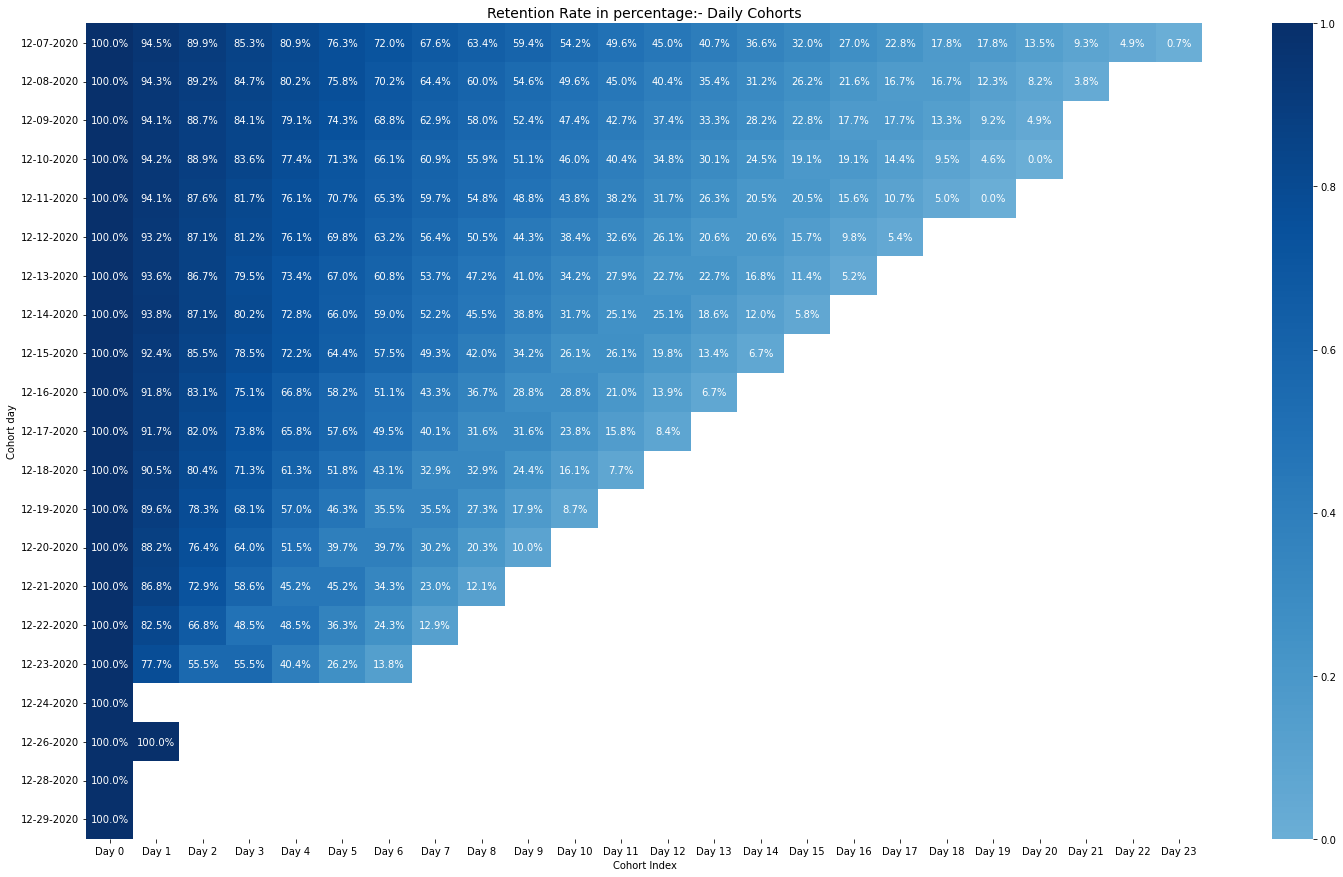

In [221]:
plt.figure(figsize=(25, 15))
plt.title('Retention Rate in percentage:- Daily Cohorts', fontsize = 14)
sns.heatmap(retention, cmap='Blues', fmt= '.1%', center=0, annot=True, vmin = 0.0 , vmax = 1)
plt.ylabel('Cohort day')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()

### non-tested users

In [222]:
g0=pd.DataFrame(non_tested_events.groupby('user_id').agg({'event_dt':['min','max']})).reset_index()
g0.columns=['user_id','created_at','end_time']
g0['created_at']=g0['created_at'].apply(lambda x:x.date())
g0['end_time']=g0['end_time'].apply(lambda x:x.date())
g0

,user_id,created_at,end_time
0,0001710F4DDB1D1B,2020-12-14,2020-12-15
1,000199F1887AE5E6,2020-12-14,2020-12-21
2,0002499E372175C7,2020-12-22,2020-12-26
3,000456437D0EFFE1,2020-12-15,2020-12-26
4,0004DAF30B04CCF1,2020-12-07,2020-12-16
...,...,...,...
45060,FFF7A7BAF44FE9B4,2020-12-19,2020-12-22
45061,FFF8FDBE2FE99C91,2020-12-20,2020-12-23
45062,FFF91B6C5431F375,2020-12-14,2020-12-17
45063,FFFAB034A09DCC28,2020-12-18,2020-12-21


In [223]:
from calculate_retention import CalculateRetention
retention_data = CalculateRetention(g0,'daily')
z = retention_data.get_raw_retention()
cohort_sizes = z.iloc[:,0]
retention0 = z.divide(cohort_sizes, axis=0)

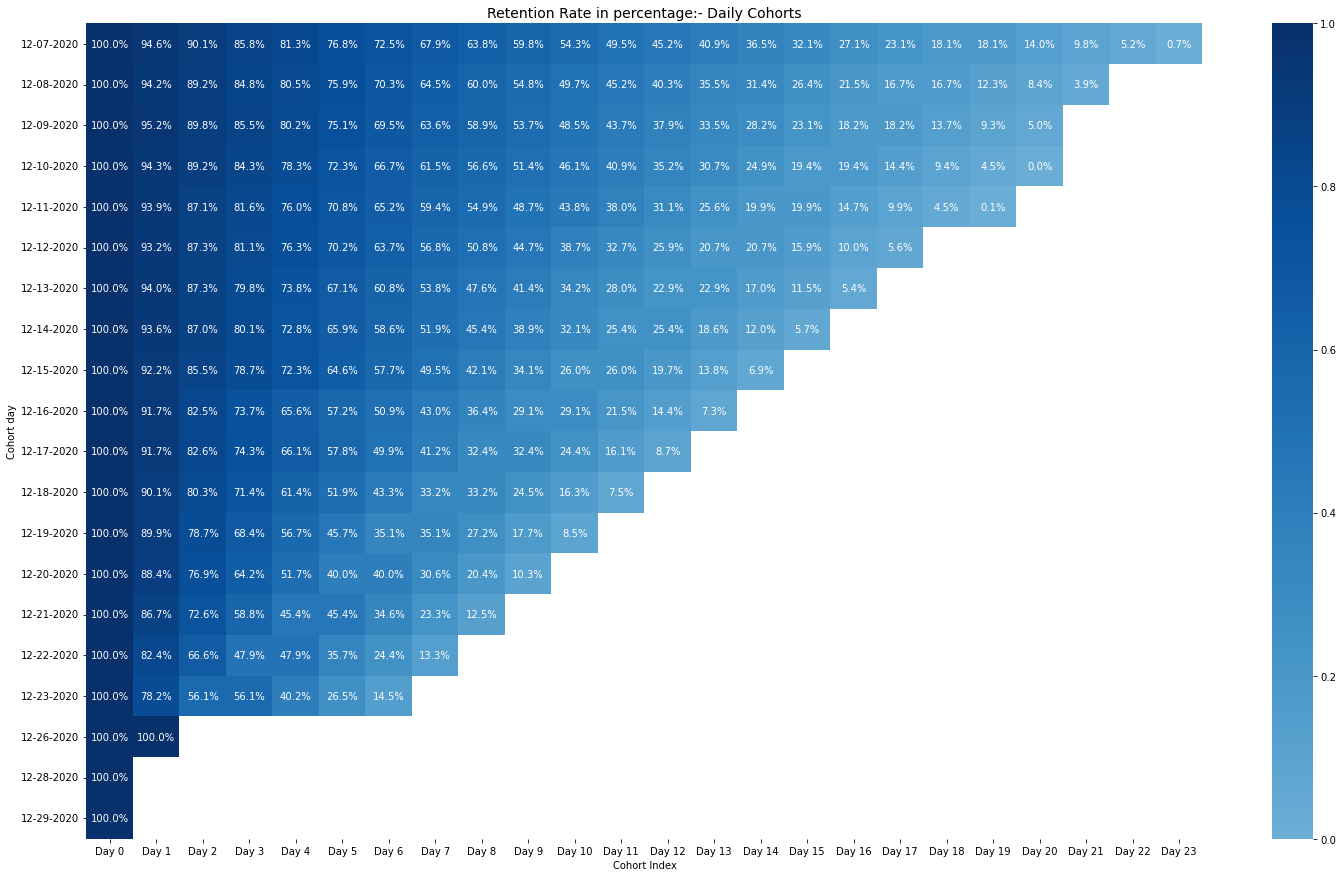

In [224]:
plt.figure(figsize=(25, 15))
plt.title('Retention Rate in percentage:- Daily Cohorts', fontsize = 14)
sns.heatmap(retention0, cmap='Blues', fmt= '.1%', center=0, annot=True, vmin = 0.0 , vmax = 1)
plt.ylabel('Cohort day')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()

### recommender_system group A

In [225]:
g1=pd.DataFrame(recommender_system_events_a.groupby('user_id').agg({'event_dt':['min','max']})).reset_index()
g1.columns=['user_id','created_at','end_time']
g1['created_at']=g1['created_at'].apply(lambda x:x.date())
g1['end_time']=g1['end_time'].apply(lambda x:x.date())
g1

,user_id,created_at,end_time
0,0010A1C096941592,2020-12-17,2020-12-23
1,00341D8401F0F665,2020-12-21,2020-12-24
2,003DF44D7589BBD4,2020-12-17,2020-12-26
3,00505E15A9D81546,2020-12-14,2020-12-22
4,006E3E4E232CE760,2020-12-17,2020-12-24
...,...,...,...
2742,FF44696E39039D29,2020-12-21,2020-12-23
2743,FF5A1CD38F5DD996,2020-12-21,2020-12-29
2744,FF5B24BCE4387F86,2020-12-21,2020-12-29
2745,FF825C1D791989B5,2020-12-19,2020-12-27


In [226]:
retention_data = CalculateRetention(g1,'daily')
z = retention_data.get_raw_retention()
cohort_sizes = z.iloc[:,0]
retention1 = z.divide(cohort_sizes, axis=0)

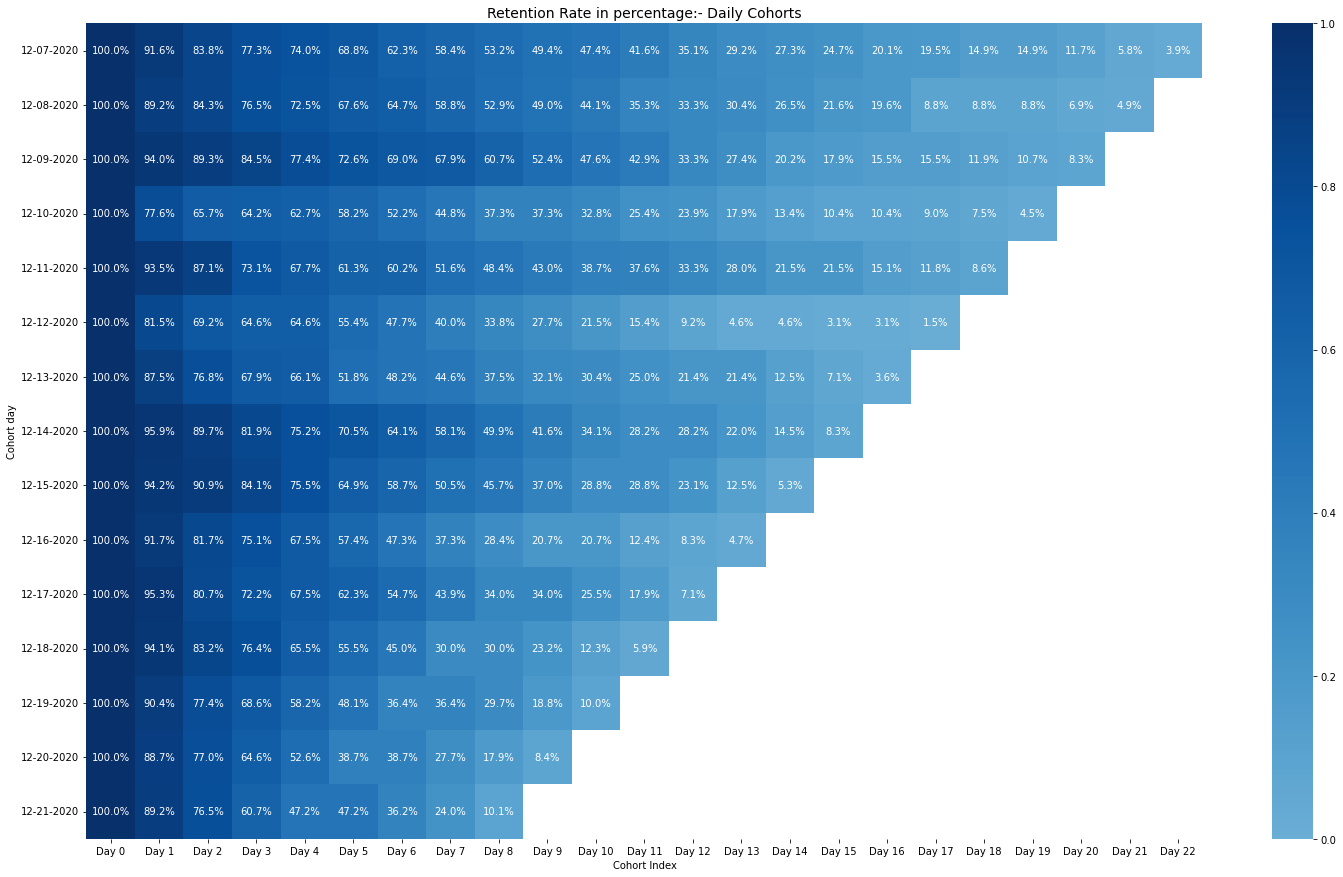

In [227]:
plt.figure(figsize=(25, 15))

plt.title('Retention Rate in percentage:- Daily Cohorts', fontsize = 14)

sns.heatmap(retention1, cmap='Blues', fmt= '.1%', center=0, annot=True, vmin = 0.0 , vmax = 1)
plt.ylabel('Cohort day')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()

### recommender_system group B

In [228]:
g2=pd.DataFrame(recommender_system_events_b.groupby('user_id').agg({'event_dt':['min','max']})).reset_index()
g2.columns=['user_id','created_at','end_time']
g2['created_at']=g2['created_at'].apply(lambda x:x.date())
g2['end_time']=g2['end_time'].apply(lambda x:x.date())
g2

,user_id,created_at,end_time
0,001064FEAAB631A1,2020-12-20,2020-12-26
1,005E096DBD379BCF,2020-12-21,2020-12-27
2,015D1E3BB893349D,2020-12-16,2020-12-19
3,015FF3EC72C1F4F6,2020-12-20,2020-12-20
4,01B0B891CA513468,2020-12-16,2020-12-22
...,...,...,...
923,FE76759FE6BF8C68,2020-12-09,2020-12-23
924,FE8F9858BBE502D9,2020-12-16,2020-12-16
925,FEA0C585A53E7027,2020-12-08,2020-12-08
926,FF8CF7057415EB29,2020-12-21,2020-12-21


In [229]:
retention_data = CalculateRetention(g2,'daily')
z = retention_data.get_raw_retention()
cohort_sizes = z.iloc[:,0]
retention2 = z.divide(cohort_sizes, axis=0)

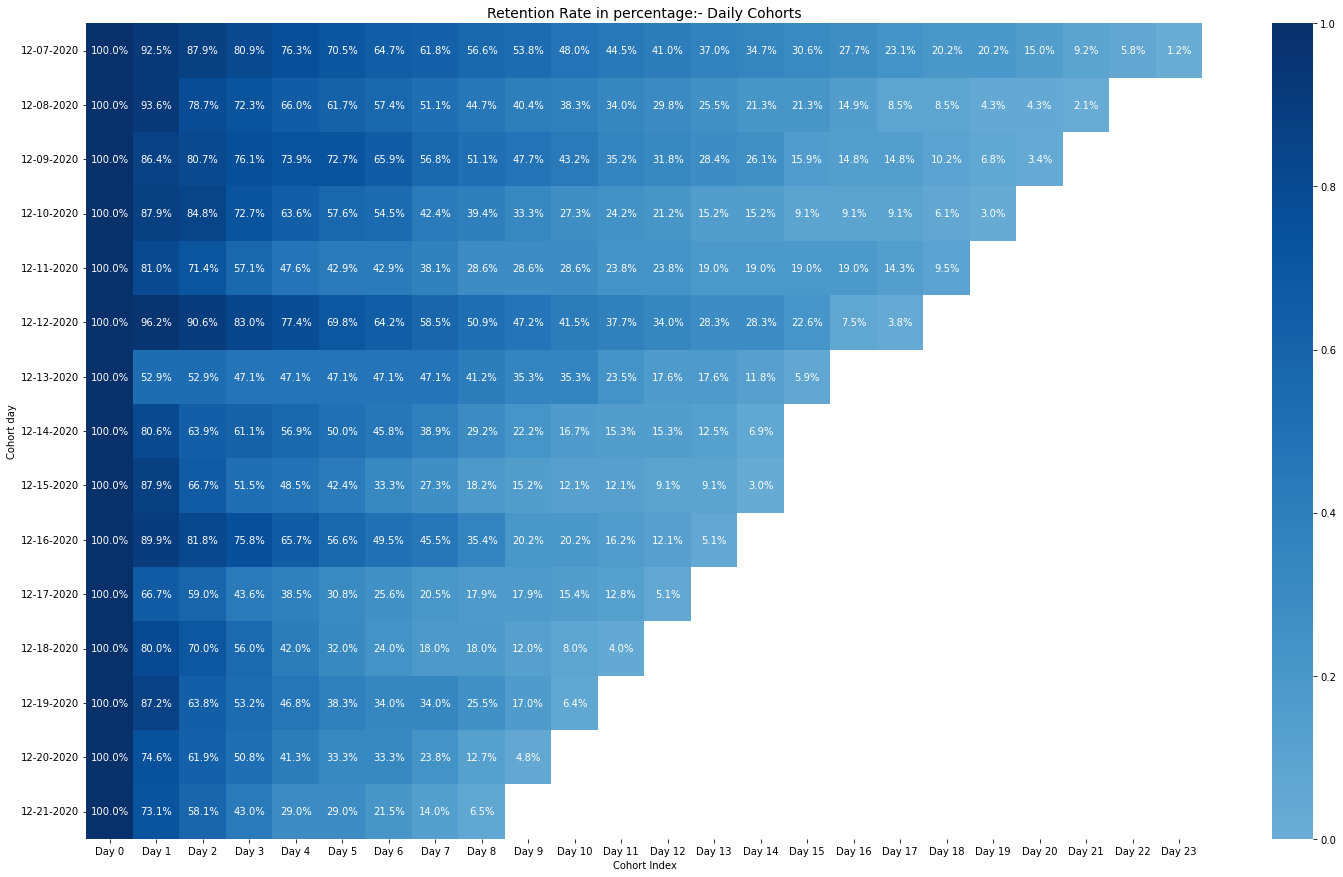

In [230]:
plt.figure(figsize=(25, 15))

plt.title('Retention Rate in percentage:- Daily Cohorts', fontsize = 14)

sns.heatmap(retention2, cmap='Blues', fmt= '.1%', center=0, annot=True, vmin = 0.0 , vmax = 1)
plt.ylabel('Cohort day')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()

Сравнение rolling retention для recommender_system group A и recommender_system group B:

In [231]:
retention1['Day 23']=[NaN]*15

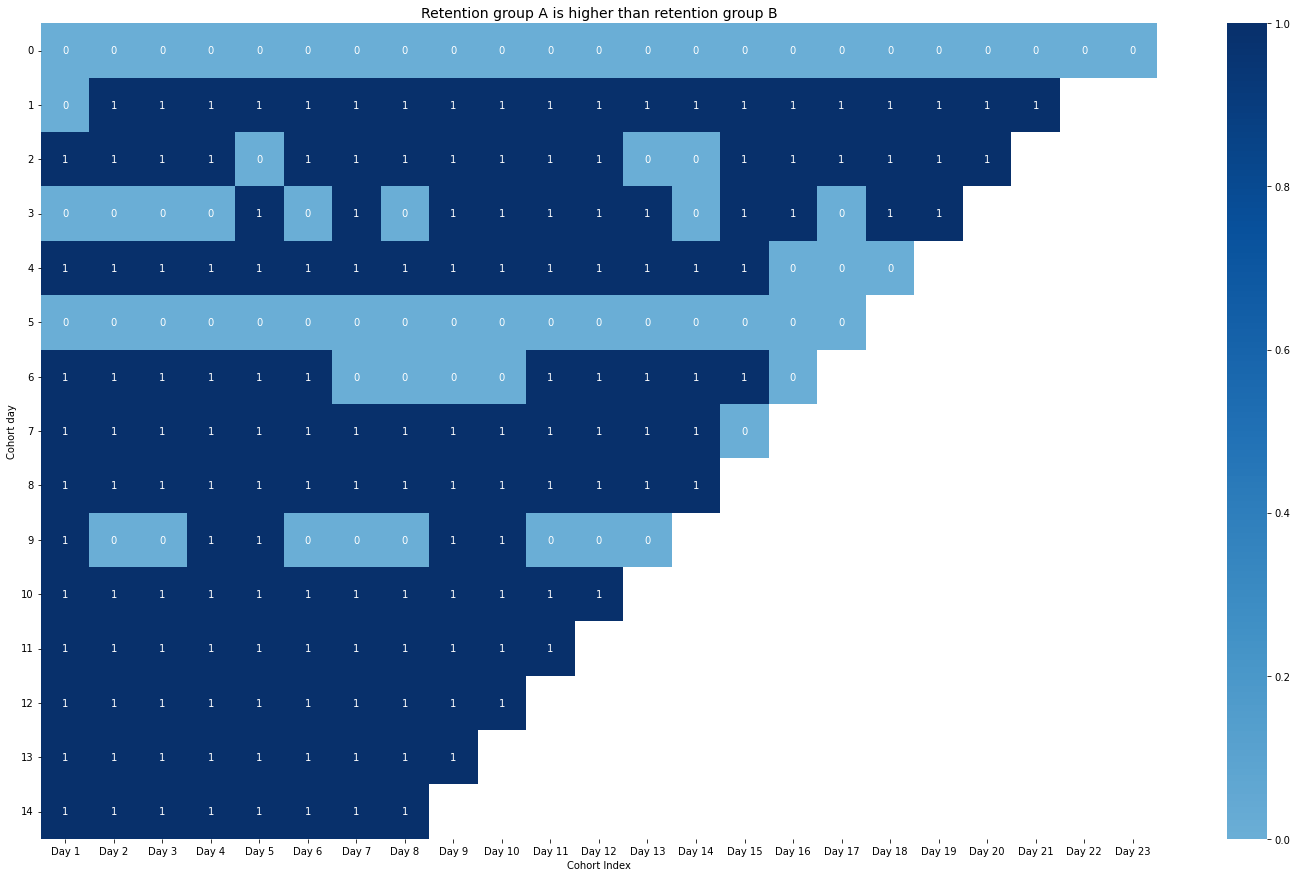

In [232]:
k=[np.float64(np.nan)]*15
difference=pd.DataFrame({'Day 1':k, 'Day 2':k, 'Day 3':k,
                         'Day 4':k,'Day 5':k,'Day 6': k,
                         'Day 7':k,'Day 8':k,'Day 9': k,
                         'Day 10': k,'Day 11':k, 'Day 12':k,
                         'Day 13':k, 'Day 14':k, 'Day 15':k, 'Day 16':k,
                         'Day 17':k,'Day 18':k, 'Day 19':k, 'Day 20':k,
                         'Day 21':k, 'Day 22':k, 'Day 23':k})
for i in range(len(retention1.columns)-1):
    for j in range(len(retention1)):
        if (np.isnan(retention1[f'Day {i+1}'][j]) and np.isnan(retention2[f'Day {i+1}'][j])):
            difference[f'Day {i+1}'][j]=np.float64(np.nan)
        else:
            difference[f'Day {i+1}'][j]=int(retention1[f'Day {i+1}'][j]>retention2[f'Day {i+1}'][j])
plt.figure(figsize=(25, 15))

plt.title('Retention group A is higher than retention group B', fontsize = 14)

sns.heatmap(difference, cmap='Blues', center=0, annot=True)
plt.ylabel('Cohort day')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()

### interface_eu group A

In [233]:
g3=pd.DataFrame(interface_eu_events_a.groupby('user_id').agg({'event_dt':['min','max']})).reset_index()
g3.columns=['user_id','created_at','end_time']
g3['created_at']=g3['created_at'].apply(lambda x:x.date())
g3['end_time']=g3['end_time'].apply(lambda x:x.date())
g3

,user_id,created_at,end_time
0,0002CE61FF2C4011,2020-12-07,2020-12-15
1,002412F1EB3F6E38,2020-12-09,2020-12-20
2,002540BE89C930FB,2020-12-08,2020-12-14
3,003346BB64227D0C,2020-12-17,2020-12-24
4,00341D8401F0F665,2020-12-21,2020-12-24
...,...,...,...
5462,FFC676CB3E0A60B8,2020-12-22,2020-12-23
5463,FFDA3BD9A090A179,2020-12-13,2020-12-15
5464,FFDC1BEFD27A66D5,2020-12-10,2020-12-14
5465,FFE600EEC4BA7685,2020-12-13,2020-12-19


In [234]:
retention_data = CalculateRetention(g3,'daily')
z = retention_data.get_raw_retention()
cohort_sizes = z.iloc[:,0]
retention3 = z.divide(cohort_sizes, axis=0)

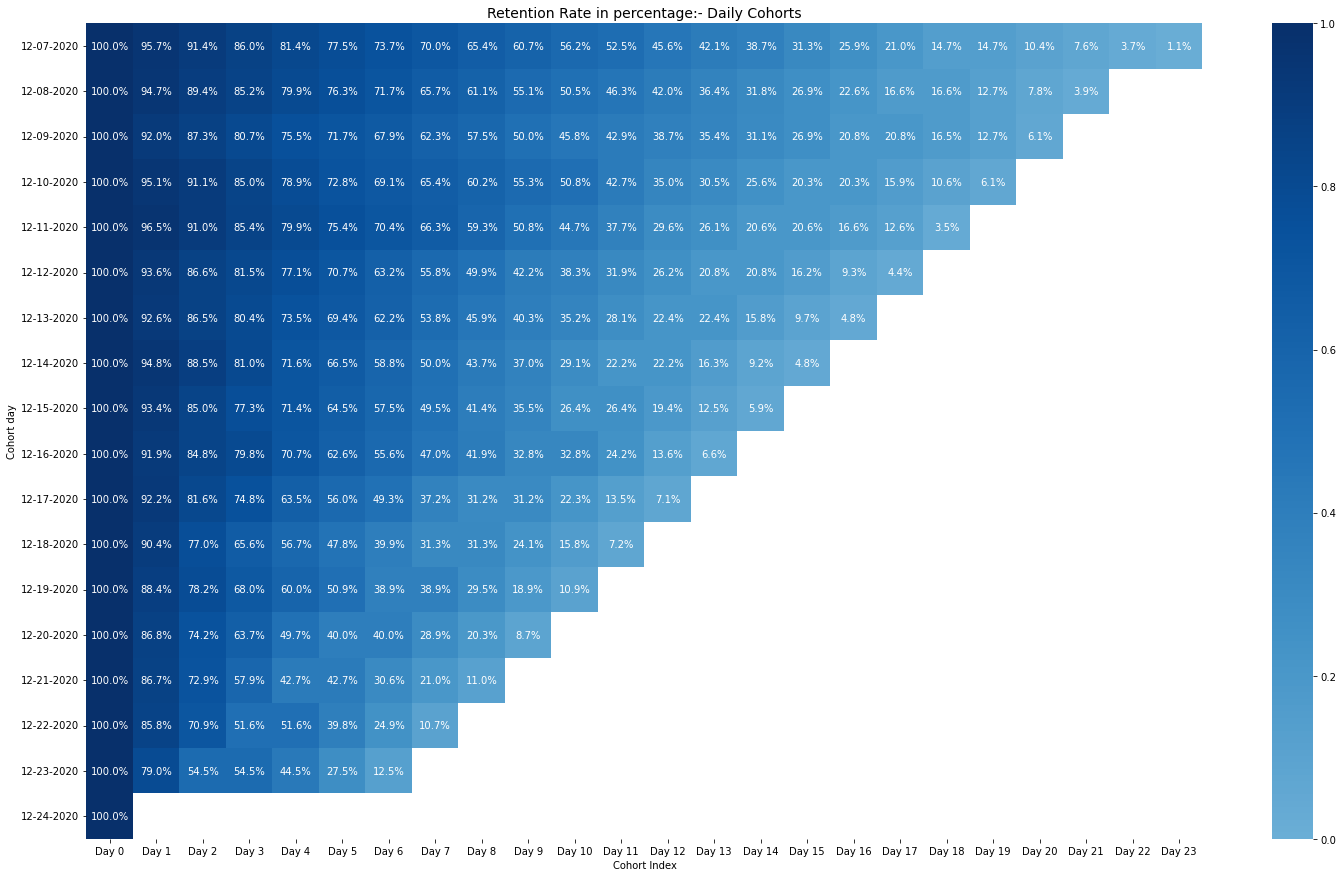

In [235]:
plt.figure(figsize=(25, 15))

plt.title('Retention Rate in percentage:- Daily Cohorts', fontsize = 14)

sns.heatmap(retention3, cmap='Blues', fmt= '.1%', center=0, annot=True, vmin = 0.0 , vmax = 1)
plt.ylabel('Cohort day')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()

### interface_eu group B

In [236]:
g4=pd.DataFrame(interface_eu_events_b.groupby('user_id').agg({'event_dt':['min','max']})).reset_index()
g4.columns=['user_id','created_at','end_time']
g4['created_at']=g4['created_at'].apply(lambda x:x.date())
g4['end_time']=g4['end_time'].apply(lambda x:x.date())
g4

,user_id,created_at,end_time
0,001064FEAAB631A1,2020-12-20,2020-12-26
1,001E72F50D1C48FA,2020-12-17,2020-12-27
2,0031F1B5E9FBF708,2020-12-14,2020-12-15
3,0036BE15EE4D319D,2020-12-21,2020-12-24
4,003F86A34B575D27,2020-12-22,2020-12-24
...,...,...,...
5378,FFE40BDB7364E966,2020-12-22,2020-12-27
5379,FFE5B14BD55C1C5C,2020-12-19,2020-12-19
5380,FFE7FC140521F5F6,2020-12-23,2020-12-29
5381,FFEFC0E55C1CCD4F,2020-12-13,2020-12-28


In [237]:
retention_data = CalculateRetention(g4,'daily')
z = retention_data.get_raw_retention()
cohort_sizes = z.iloc[:,0]
retention4 = z.divide(cohort_sizes, axis=0)

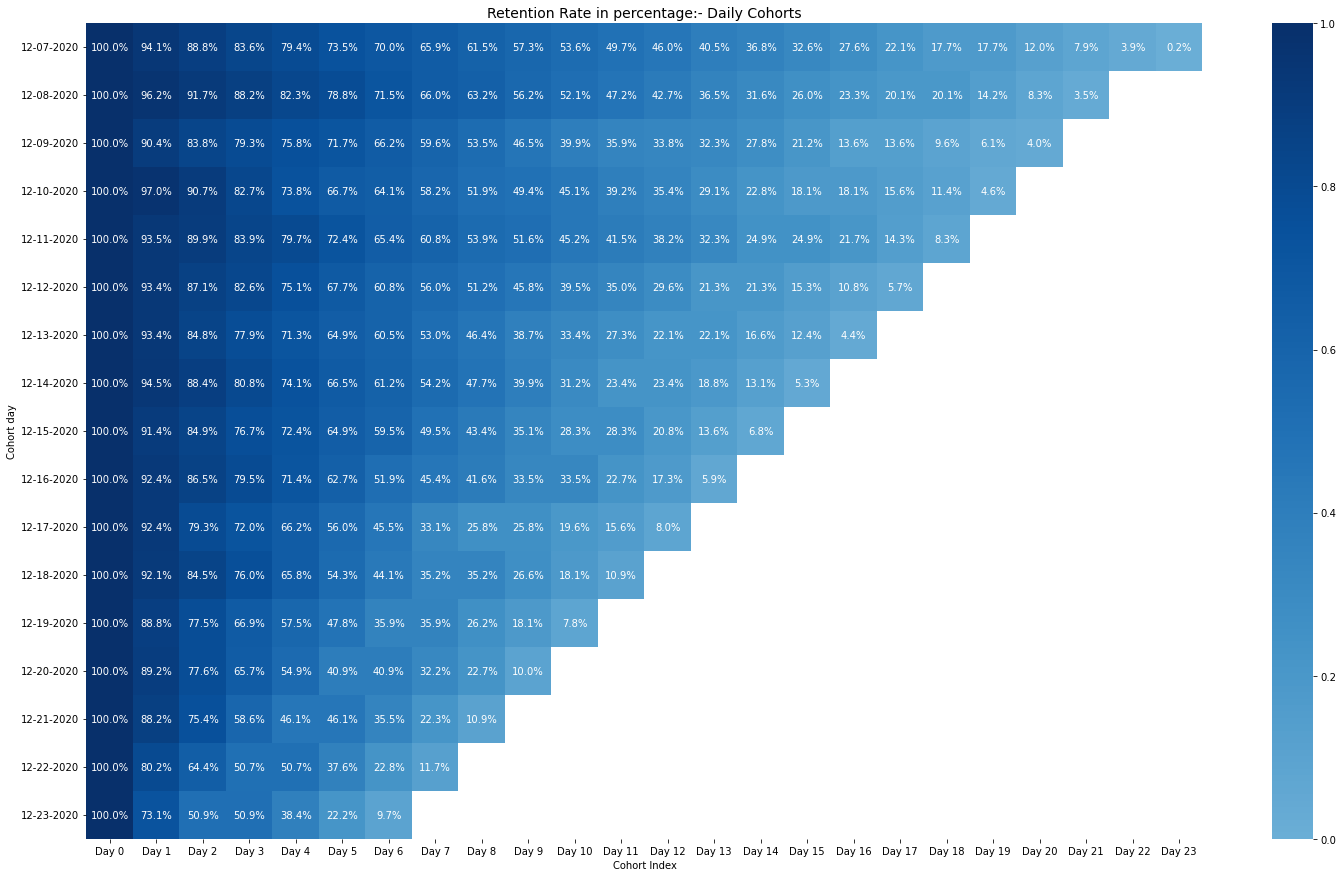

In [238]:
plt.figure(figsize=(25, 15))

plt.title('Retention Rate in percentage:- Daily Cohorts', fontsize = 14)

sns.heatmap(retention4, cmap='Blues', fmt= '.1%', center=0, annot=True, vmin = 0.0 , vmax = 1)
plt.ylabel('Cohort day')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()

Сравнение rolling retention для interface_eu group A и interface_eu group B:

In [239]:
retention4.loc['12-24-2020'] = [NaN]*24

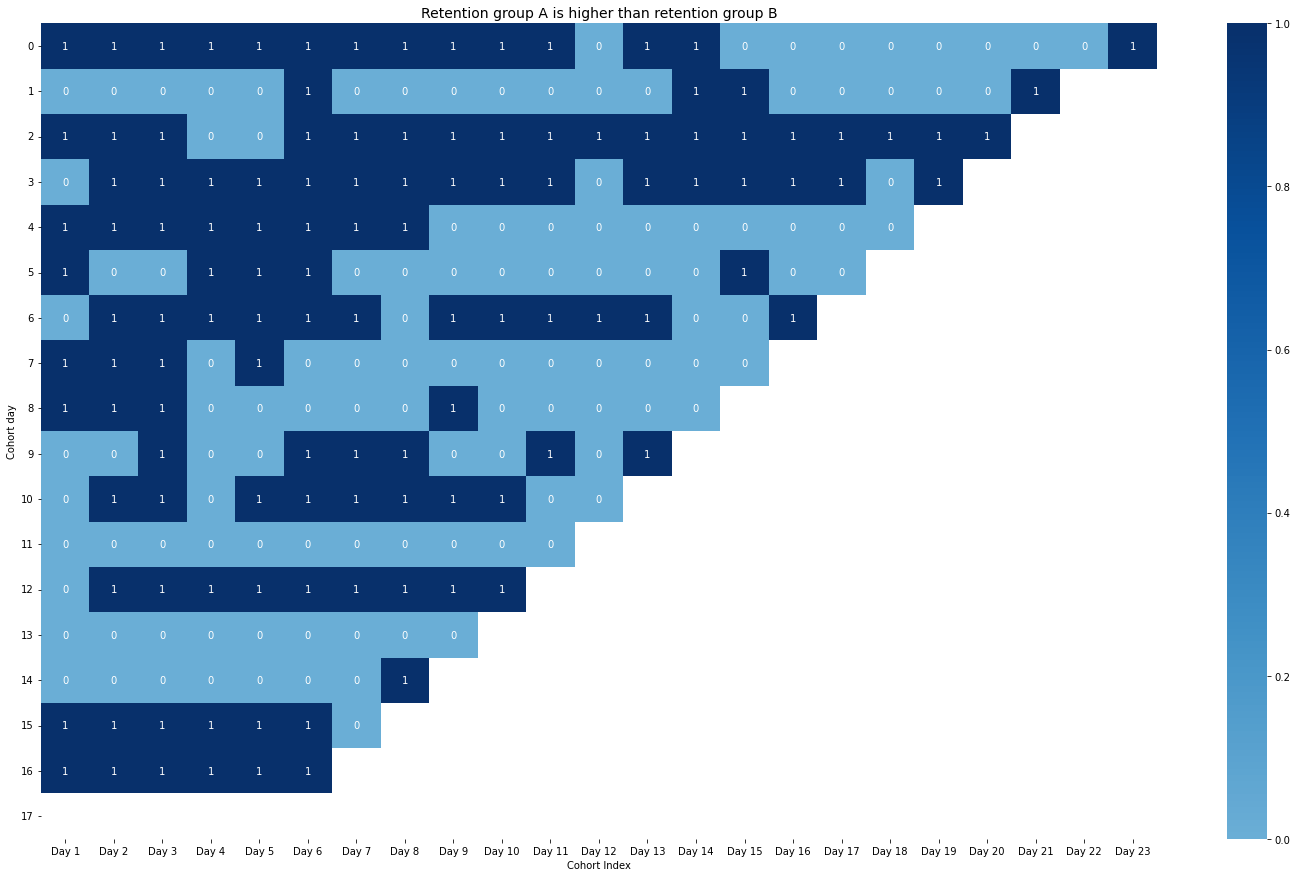

In [240]:
k=[np.float64(np.nan)]*18
difference=pd.DataFrame({'Day 1':k, 'Day 2':k, 'Day 3':k,
                         'Day 4':k,'Day 5':k,'Day 6': k,
                         'Day 7':k,'Day 8':k,'Day 9': k,
                         'Day 10': k,'Day 11':k, 'Day 12':k,
                         'Day 13':k, 'Day 14':k, 'Day 15':k, 'Day 16':k,
                         'Day 17':k,'Day 18':k, 'Day 19':k, 'Day 20':k,
                         'Day 21':k, 'Day 22':k, 'Day 23':k})
for i in range(len(retention3.columns)-1):
    for j in range(len(retention3)):
        if (np.isnan(retention3[f'Day {i+1}'][j]) and np.isnan(retention4[f'Day {i+1}'][j])):
            difference[f'Day {i+1}'][j]=np.float64(np.nan)
        else:
            difference[f'Day {i+1}'][j]=int(retention3[f'Day {i+1}'][j]>retention4[f'Day {i+1}'][j])
plt.figure(figsize=(25, 15))

plt.title('Retention group A is higher than retention group B', fontsize = 14)

sns.heatmap(difference, cmap='Blues', center=0, annot=True)
plt.ylabel('Cohort day')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()

## Среднее количество "дней жизни"

Посчитаем количество "дней жизни" каждого пользователя, то есть разницу между первым и последним действием на сайте, не считая подписку:

### all users

[Text(0, 0, '9.12219'),
 Text(0, 0, '9.13412'),
 Text(0, 0, '8.26704'),
 Text(0, 0, '7.78665'),
 Text(0, 0, '7.0269'),
 Text(0, 0, '7.17169'),
 Text(0, 0, '7.58735'),
 Text(0, 0, '6.65213'),
 Text(0, 0, '6.40512'),
 Text(0, 0, '5.33193'),
 Text(0, 0, '4.36945'),
 Text(0, 0, '3.48193'),
 Text(0, 0, '3.14805'),
 Text(0, 0, '2.86016'),
 Text(0, 0, '2.70855'),
 Text(0, 0, '2.36956'),
 Text(0, 0, '1.67453'),
 Text(0, 0, '1.3662'),
 Text(0, 0, '0.807454'),
 Text(0, 0, '0.955658'),
 Text(0, 0, '0.766571'),
 Text(0, 0, '0.586001'),
 Text(0, 0, '0.362843'),
 Text(0, 0, '0.0579187')]

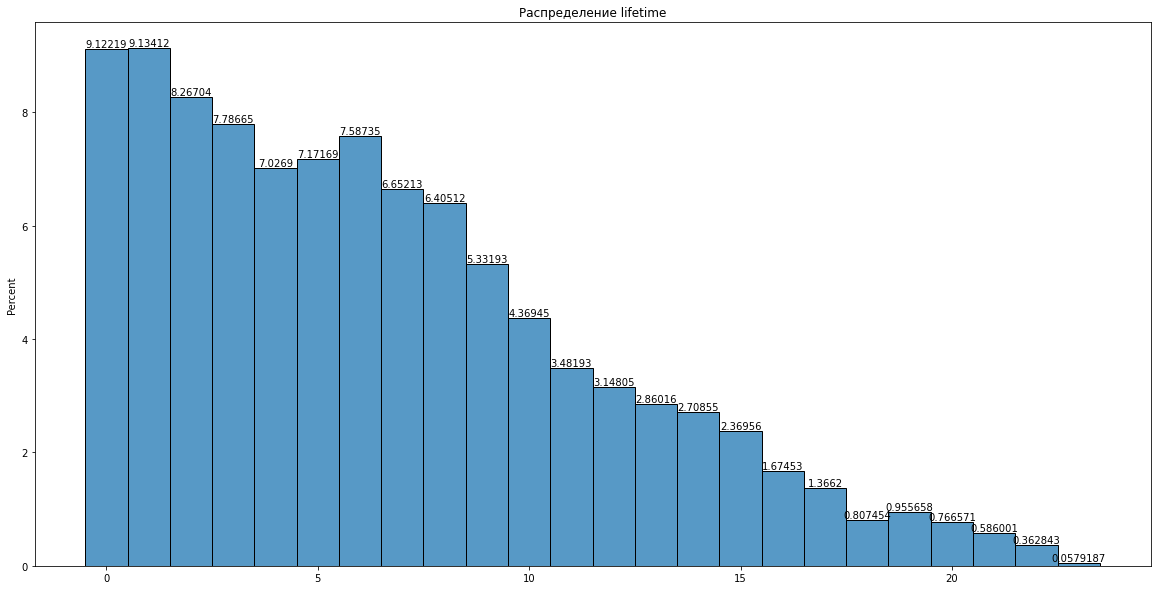

In [241]:
lifetime=(g['end_time']-g['created_at']).apply(lambda x: x.days)
pylab.figure(figsize(20, 10))
plt.title('Распределение lifetime')
ax=sns.histplot(lifetime, discrete=True, stat='percent')
ax.bar_label (ax.containers [ 0 ])

Среднее количество "дней жизни" пользователя:

In [242]:
lifetime.mean()

6.543907466398651

### non-tested users

[Text(0, 0, '9.08909'),
 Text(0, 0, '9.0669'),
 Text(0, 0, '8.21924'),
 Text(0, 0, '7.78431'),
 Text(0, 0, '7.04982'),
 Text(0, 0, '7.13414'),
 Text(0, 0, '7.55797'),
 Text(0, 0, '6.63264'),
 Text(0, 0, '6.35526'),
 Text(0, 0, '5.39887'),
 Text(0, 0, '4.37812'),
 Text(0, 0, '3.51048'),
 Text(0, 0, '3.11994'),
 Text(0, 0, '2.90469'),
 Text(0, 0, '2.71386'),
 Text(0, 0, '2.40541'),
 Text(0, 0, '1.7153'),
 Text(0, 0, '1.3891'),
 Text(0, 0, '0.805503'),
 Text(0, 0, '0.934206'),
 Text(0, 0, '0.774437'),
 Text(0, 0, '0.61023'),
 Text(0, 0, '0.390547'),
 Text(0, 0, '0.0599135')]

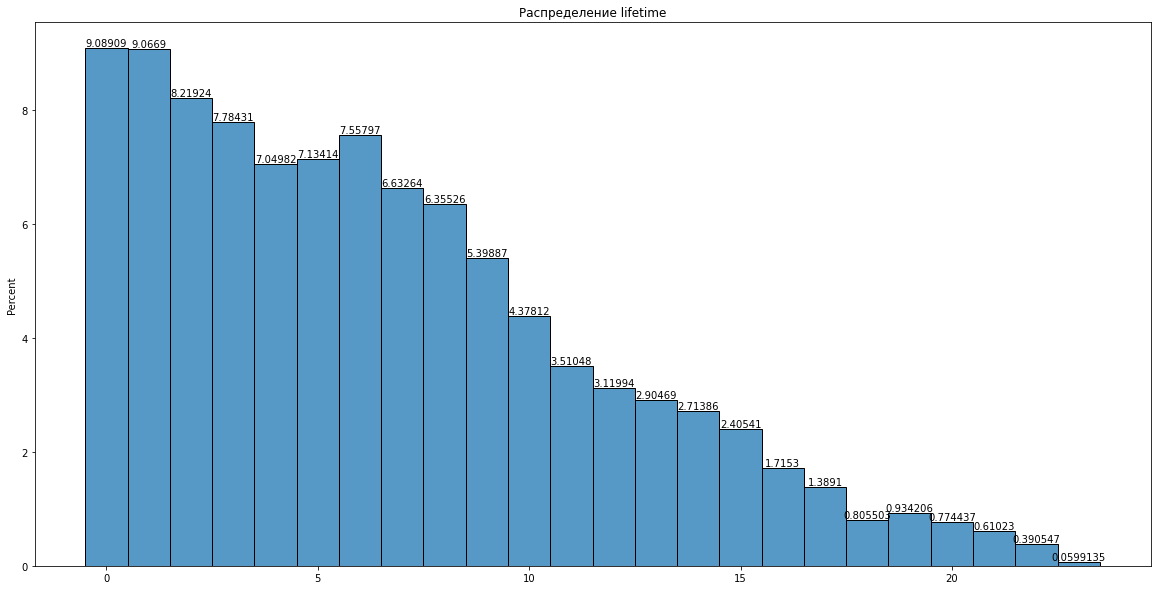

In [243]:
lifetime0=(g0['end_time']-g0['created_at']).apply(lambda x: x.days)
pylab.figure(figsize(20, 10))
plt.title('Распределение lifetime')
ax=sns.histplot(lifetime0, discrete=True, stat='percent')
ax.bar_label (ax.containers [ 0 ])

Среднее количество "дней жизни" пользователя:

In [244]:
lifetime0.mean()

6.571907245090425

### recommender_system group A

[Text(0, 0, '8.48198'),
 Text(0, 0, '9.7561'),
 Text(0, 0, '9.21005'),
 Text(0, 0, '8.26356'),
 Text(0, 0, '6.98944'),
 Text(0, 0, '7.13506'),
 Text(0, 0, '8.26356'),
 Text(0, 0, '7.82672'),
 Text(0, 0, '7.31707'),
 Text(0, 0, '5.67892'),
 Text(0, 0, '4.58682'),
 Text(0, 0, '3.13069'),
 Text(0, 0, '3.49472'),
 Text(0, 0, '2.87586'),
 Text(0, 0, '1.89297'),
 Text(0, 0, '1.85657'),
 Text(0, 0, '0.691664'),
 Text(0, 0, '0.54605'),
 Text(0, 0, '0.400437'),
 Text(0, 0, '0.43684'),
 Text(0, 0, '0.65526'),
 Text(0, 0, '0.291227'),
 Text(0, 0, '0.21842')]

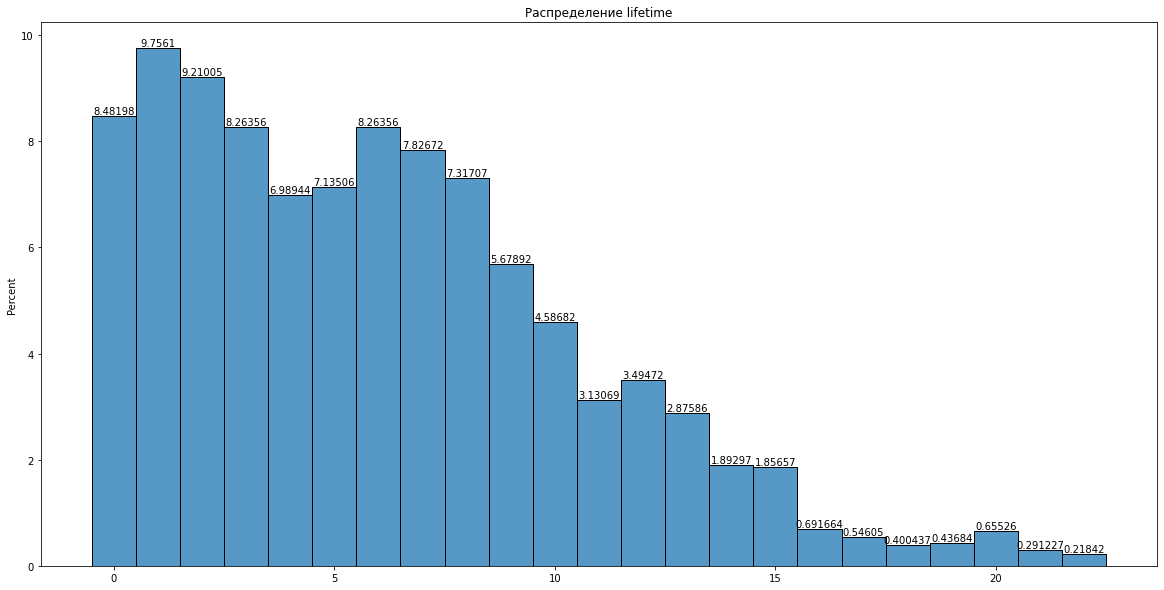

In [245]:
lifetime1=(g1['end_time']-g1['created_at']).apply(lambda x: x.days)
pylab.figure(figsize(20, 10))
plt.title('Распределение lifetime')
ax=sns.histplot(lifetime1, discrete=True, stat='percent')
ax.bar_label (ax.containers [ 0 ])

Среднее количество "дней жизни" пользователя:

In [246]:
lifetime1.mean()

6.044776119402985

### recommender_system group B

[Text(0, 0, '15.5172'),
 Text(0, 0, '10.1293'),
 Text(0, 0, '8.94397'),
 Text(0, 0, '7.11207'),
 Text(0, 0, '5.71121'),
 Text(0, 0, '5.38793'),
 Text(0, 0, '5.71121'),
 Text(0, 0, '6.89655'),
 Text(0, 0, '5.81897'),
 Text(0, 0, '3.87931'),
 Text(0, 0, '3.44828'),
 Text(0, 0, '2.69397'),
 Text(0, 0, '3.125'),
 Text(0, 0, '2.15517'),
 Text(0, 0, '3.01724'),
 Text(0, 0, '1.93966'),
 Text(0, 0, '1.50862'),
 Text(0, 0, '1.40086'),
 Text(0, 0, '0.862069'),
 Text(0, 0, '1.40086'),
 Text(0, 0, '1.50862'),
 Text(0, 0, '0.75431'),
 Text(0, 0, '0.862069'),
 Text(0, 0, '0.215517')]

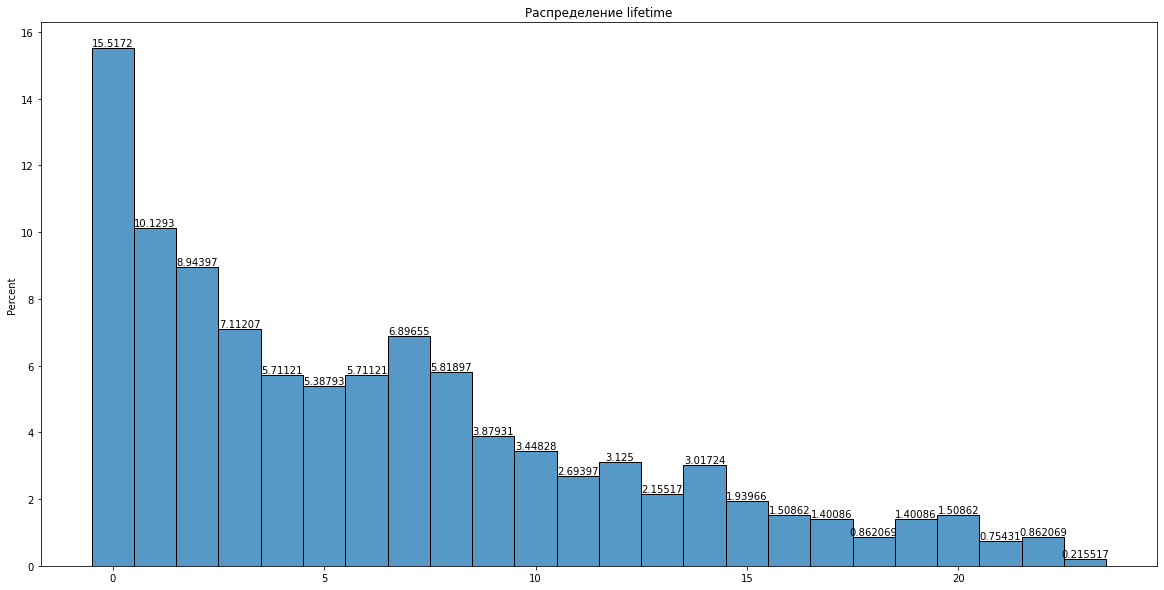

In [247]:
lifetime2=(g2['end_time']-g2['created_at']).apply(lambda x: x.days)
pylab.figure(figsize(20, 10))
plt.title('Распределение lifetime')
ax=sns.histplot(lifetime2, discrete=True, stat='percent')
ax.bar_label (ax.containers [ 0 ])

Среднее количество "дней жизни" пользователя:

In [248]:
lifetime2.mean()

6.241379310344827

**Вывод**: При проведении теста среднее количество "дней жизни" пользователя для recommender_system group A (6.04) меньше среднего количества "дней жизни" пользователя recommender_system group B (6.24)

### interface_eu group A

[Text(0, 0, '8.74337'),
 Text(0, 0, '9.20066'),
 Text(0, 0, '8.28608'),
 Text(0, 0, '8.04829'),
 Text(0, 0, '6.21913'),
 Text(0, 0, '7.40808'),
 Text(0, 0, '7.90196'),
 Text(0, 0, '6.47521'),
 Text(0, 0, '6.62155'),
 Text(0, 0, '4.95701'),
 Text(0, 0, '4.66435'),
 Text(0, 0, '3.85952'),
 Text(0, 0, '2.96323'),
 Text(0, 0, '2.83519'),
 Text(0, 0, '2.76203'),
 Text(0, 0, '2.35961'),
 Text(0, 0, '1.77428'),
 Text(0, 0, '1.57307'),
 Text(0, 0, '0.676788'),
 Text(0, 0, '1.15237'),
 Text(0, 0, '0.676788'),
 Text(0, 0, '0.530455'),
 Text(0, 0, '0.219499'),
 Text(0, 0, '0.0914578')]

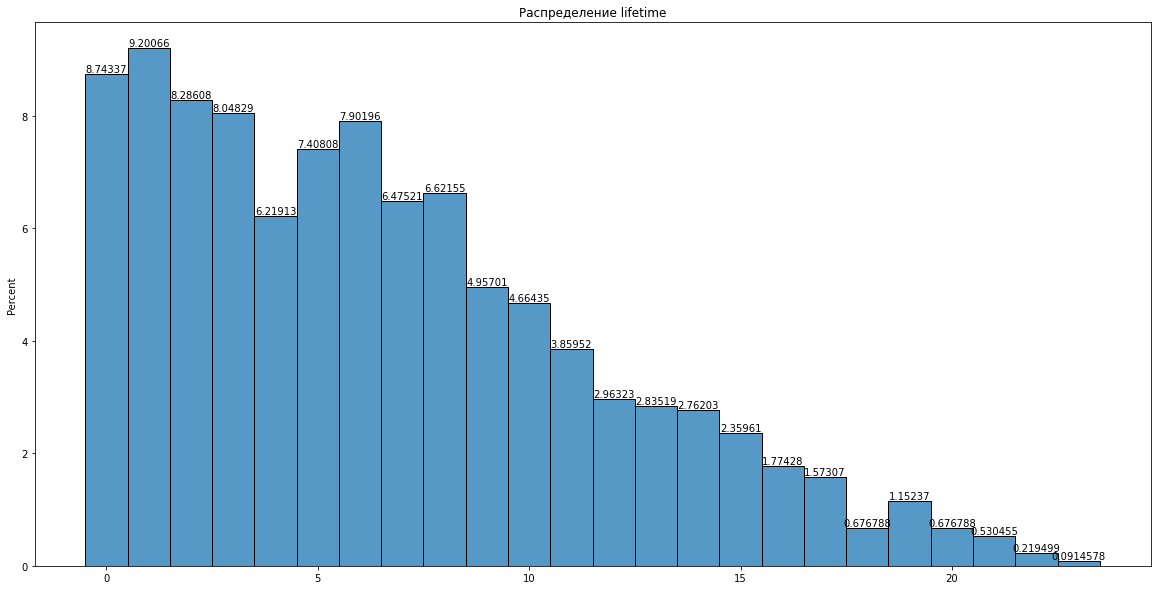

In [249]:
lifetime3=(g3['end_time']-g3['created_at']).apply(lambda x: x.days)
pylab.figure(figsize(20, 10))
plt.title('Распределение lifetime')
ax=sns.histplot(lifetime3, discrete=True, stat='percent')
ax.bar_label (ax.containers [ 0 ])

Среднее количество "дней жизни" пользователя:

In [250]:
lifetime3.mean()

6.585513078470825

### interface_eu group B

[Text(0, 0, '9.15846'),
 Text(0, 0, '9.08415'),
 Text(0, 0, '8.30392'),
 Text(0, 0, '7.35649'),
 Text(0, 0, '7.80234'),
 Text(0, 0, '7.35649'),
 Text(0, 0, '7.61657'),
 Text(0, 0, '6.52053'),
 Text(0, 0, '6.42764'),
 Text(0, 0, '5.20156'),
 Text(0, 0, '3.97548'),
 Text(0, 0, '3.19524'),
 Text(0, 0, '3.4739'),
 Text(0, 0, '2.7494'),
 Text(0, 0, '2.78655'),
 Text(0, 0, '2.26639'),
 Text(0, 0, '1.65335'),
 Text(0, 0, '1.30039'),
 Text(0, 0, '1.07747'),
 Text(0, 0, '1.07747'),
 Text(0, 0, '0.761657'),
 Text(0, 0, '0.520156'),
 Text(0, 0, '0.315809'),
 Text(0, 0, '0.018577')]

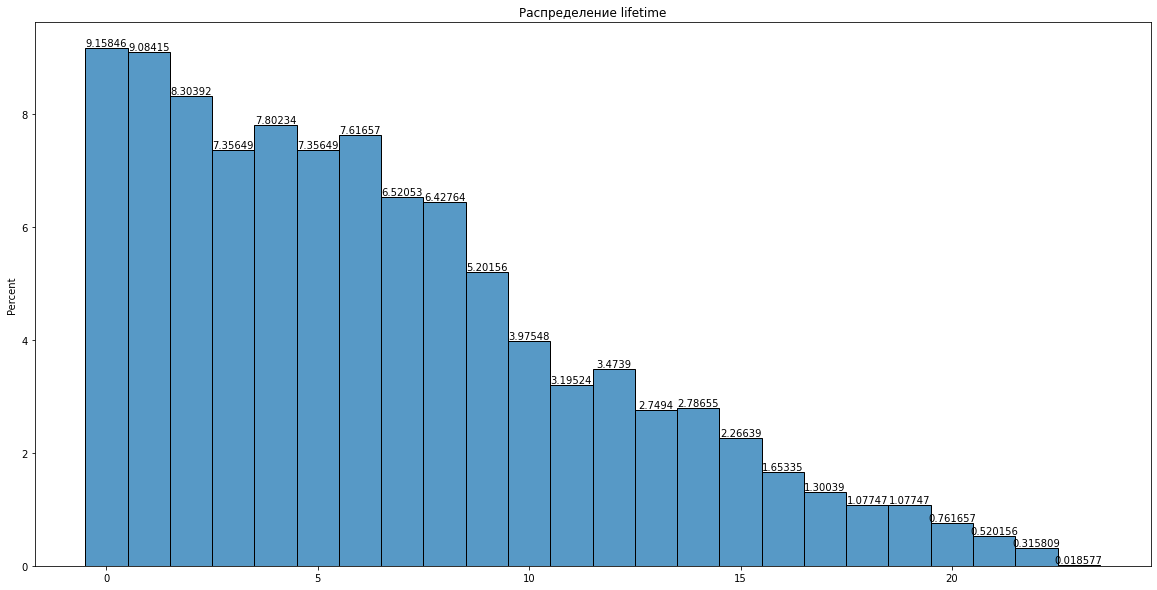

In [251]:
lifetime4=(g4['end_time']-g4['created_at']).apply(lambda x: x.days)
pylab.figure(figsize(20, 10))
plt.title('Распределение lifetime')
ax=sns.histplot(lifetime4, discrete=True, stat='percent')
ax.bar_label (ax.containers [ 0 ])

Среднее количество "дней жизни" пользователя:

In [252]:
lifetime4.mean()

6.5262864573657815

**Вывод**: При проведении теста среднее количество "дней жизни" пользователя для interface_eu group A (6.59) больше среднего количества "дней жизни" пользователя interface_eu group B (6.53)

# A-B-test

Так как у нас нет информации относительно этапов планирования А-Б-тестов, то мы не знаем ни целевую метрику, по которой проводились тесты, ни MDE, обозначенный перед началом тестирования. Так как размер выборок достаточно небольшой по сравнению с количеством пользователей, не участвующих в тестировании, скорее всего целевая метрика-конверсия из подписки в продажу. Если целевая метрика-конверсия в продажу, то необходимо убедиться, что метрики ARPPU и ARPU статистически не уменьшаются для группы A по сравнению с группой B.

Примем уровень значимости alpha=0.05 и мощность критерия за 1-beta=0.95:

In [253]:
alpha=0.05
beta=0.05

## Конверсия в покупку

Так как конверсия в покупку имеет распределение Бернулли, то будем использовать z-тест для пропорций для тестирования гипотез:

Посчитаем статистики z_alpha и z_width_rec:

In [254]:
z_alpha = st.norm.ppf(1-alpha)
z_alpha

1.6448536269514722

In [255]:
z_width_rec = st.norm.ppf(1-beta)
z_width_rec

1.6448536269514722

In [256]:
z_half_alpha=st.norm.ppf(1-alpha/2)
z_half_alpha

1.959963984540054

### recommender_system_test

Конверсия в покупку для recommender_system group A:

In [257]:
p1=len(paying_revenue1)/2747
p1

0.3174372042227885

Дисперсия конверсии в покупку для recommender_system group A:

In [258]:
var1=p1*(1-p1)
var1

0.21667082559800818

Конверсия в покупку для recommender_system group B:

In [259]:
p2=len(paying_revenue2)/928
p2

0.27586206896551724

Дисперсия конверсии в покупку для recommender_system group B:

In [260]:
var2=p2*(1-p2)
var2

0.19976218787158145

**Тестируем одностороннюю гипотезу**

    Ho: p1-p2=0
    H1: p1-p2>0

Рассчитаем наблюдаемую статистику Z_obs1 для разницы конверсий:

In [261]:
z_obs1=(p1-p2)/(var1/2747+var2/928)**(1/2)
z_obs1

2.424148793107256

**Вывод:** Так как z_obs1>z_alpha, то гипотеза Ho отвергается на 5% уровне значимости. Зафиксирована статистически значимая разница разности конверсий от 0.

In [262]:
z_obs1<z_alpha


False

Теперь для того чтобы тест оказался зеленым необходимо зафиксировать статистически значимую разницу разности конверсий от MDE.

**Тестируем одностороннюю гипотезу**

    Ho: p1-p2-MDE=0
    H1: p1-p2-MDE>0

Обычно MDE определяется на основе затрат на проведение А-Б теста и затраты маркетинга. И на основе MDE высчитывается мощность критерия теста. Однако здесь у нас нет информации относительно MDE. Поэтому рассчитаем MDE, приняв мощность критерия на 95% уровне:

In [263]:
MDE1=(z_alpha+z_width_rec)*(var1/2747+var2/928)**(1/2)
MDE1

0.056419814009242585

Рассчитаем наблюдаемую статистику для разности конверсий и MDE:

In [264]:
z_obs2=((p1-p2)-MDE1)/(var1/2747+var2/928)**(1/2)
z_obs2

-0.8655584607956883

**Вывод:** Так как z_obs2<z_alpha, то гипотеза Ho не отвергается на 5% уровне значимости. Не зафиксирована статистически значимая разница разности конверсий от MDE.

In [265]:
z_obs2<z_alpha

True

**Результат теста:
Зафиксирована статистически значимая разница разности конверсий от 0. Не зафиксирована статистически значимая разница разности конверсий от MDE. Тест серый, нужно посмотреть на метрики ARPPU и ARPU. Если нет статистической разницы между группами, то желательно перезапустить тест с большей выборкой. Если же есть статистически значимая отрицательная разница, то следует отказаться от внедрения варианта A.**

### interface_eu_test

Конверсия в покупку для interface_eu group A:

In [266]:
p3=len(paying_revenue3)/5467
p3

0.35321017011157857

Дисперсия конверсии в покупку для interface_eu group A:

In [267]:
var3=p3*(1-p3)
var3


0.22845274584132827

Конверсия в покупку для interface_eu group B:

In [268]:
p4=len(paying_revenue4)/5383
p4

0.3310421697937953

Дисперсия конверсии в покупку для interface_eu group B:

In [269]:
var4=p4*(1-p4)
var4

0.2214532516120113

**Тестируем одностороннюю гипотезу**

    Ho: p3-p4=0
    H1: p3-p4>0

Рассчитаем наблюдаемую статистику Z_obs3 для разницы конверсий:

In [270]:
z_obs3=(p3-p4)/(var3/5467+var4/5383)**(1/2)
z_obs3

2.4343254501757046

**Вывод:** Так как z_obs3>z_alpha, то гипотеза Ho отвергается на 5% уровне значимости. Зафиксирована статистически значимая разница разности конверсий от 0.

In [271]:
z_obs3<z_alpha

False

Теперь для того чтобы тест оказался зеленым необходимо зафиксировать статистически значимую разницу разности конверсий от MDE.

**Тестируем одностороннюю гипотезу**

    Ho: p3-p4-MDE=0
    H1: p3-p4-MDE>0

Рассчитаем MDE по аналогии с предыдущим тестом:

In [272]:
MDE2=(z_alpha+z_width_rec)*(var3/5467+var4/5383)**(1/2)
MDE2

0.02995746992033079

Рассчитаем наблюдаемую статистику для разности конверсий и MDE:

In [273]:
z_obs4=((p3-p4)-MDE2)/(var3/5467+var4/5383)**(1/2)
z_obs4

-0.8553818037272397

**Вывод:** Так как z_obs4<z_alpha, то гипотеза Ho не отвергается на 5% уровне значимости. Не зафиксирована статистически значимая разница разности конверсий от MDE.

In [274]:
z_obs4<z_alpha

True

**Результат теста:
Зафиксирована статистически значимая разница разности конверсий от 0. Не зафиксирована статистически значимая разница разности конверсий от MDE. Тест серый, нужно посмотреть на метрики ARPPU и ARPU. Если нет статистической разницы между группами, то желательно перезапустить тест с большей выборкой. Если же есть статистически значимая отрицательная разница, то следует отказаться от внедрения варианта A.**

## ARPPU

На основе теста Колмогорова-Смирнова, мы видим, что распределение выручки пользователей каждой из 4 групп не является нормальным.
Поэтому мы не можем использовать t-test для проверки гипотез. Поэтому будем использовать bootstrap, так как у нас есть более 100 наблюдений в каждой группе:

In [275]:
from scipy.stats import kstest
kstest(paying_revenue1['details'], 'norm', 
       args=(paying_revenue1['details'].mean(),
             paying_revenue1['details'].std(ddof=1)))

KstestResult(statistic=0.3222694320252245, pvalue=4.357352586233237e-81, statistic_location=34.96, statistic_sign=1)

In [276]:
kstest(paying_revenue2['details'], 'norm', 
       args=(paying_revenue2['details'].mean(),
             paying_revenue2['details'].std(ddof=1)))

KstestResult(statistic=0.34842351567473123, pvalue=2.8026488594959525e-28, statistic_location=34.95, statistic_sign=1)

In [277]:
kstest(paying_revenue3['details'], 'norm', 
       args=(paying_revenue3['details'].mean(),
             paying_revenue3['details'].std(ddof=1)))

KstestResult(statistic=0.31485457802794603, pvalue=1.2164487450877544e-170, statistic_location=34.96, statistic_sign=1)

In [278]:
kstest(paying_revenue4['details'], 'norm', 
       args=(paying_revenue4['details'].mean(),
             paying_revenue4['details'].std(ddof=1)))

KstestResult(statistic=0.32854402751112405, pvalue=7.822364190573267e-172, statistic_location=34.96, statistic_sign=1)

Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа: строить график распределения для разности средних бутстрапированных выборок, считать 95%-процентный доверительный интервал для разности бутстрапированных средних (ARPPU), считать p-value для двусторонней гипотезы о равенстве средних:

In [279]:
from scipy.stats import norm
def get_bootstrap(
    data_column_1, 
    data_column_2, 
    boot_it = 100000, 
    statistic = np.mean, 
    bootstrap_conf_level = 0.95,
    r_state1=65,
    r_state2=66,
    MDE=0
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    samples_1=st.bootstrap((data_column_1,), statistic, n_resamples=boot_it, random_state=r_state1).bootstrap_distribution
    samples_2=st.bootstrap((data_column_2,), statistic, n_resamples=boot_it, random_state=r_state2).bootstrap_distribution
    boot_data= samples_1-samples_2-MDE
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if (bar.get_x() <= quants.iloc[0][0]) or (bar.get_x() >= quants.iloc[1][0]):
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('blue')
            bar.set_edgecolor('black')
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

### recommender_system_test

**Тестируем двустороннюю гипотезу:**

    Ho: ARPPU1-ARPPU2=0
    H1: ARPPU1-ARPPU2<>0

In [280]:
data1=paying_revenue1['details']
data2=paying_revenue2['details']

Распределение разности средних бутстрапированных выборок (синяя область-95%-процентный доверительный интервал):

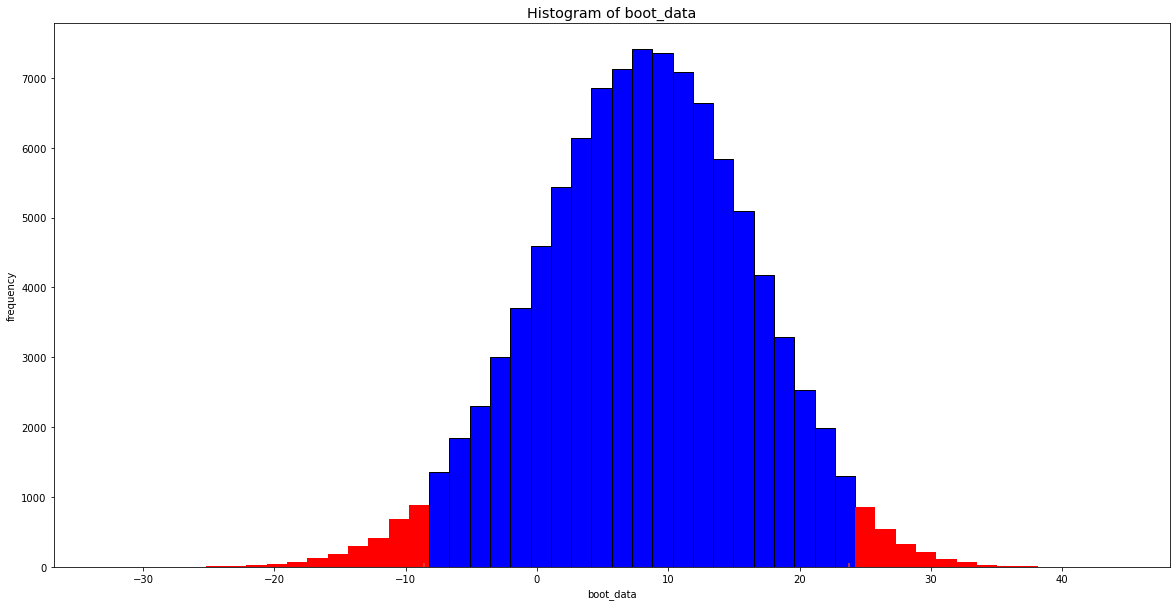

In [281]:
booted_data1 = get_bootstrap(data1, data2)

95%-процентный доверительный интервал для разности средних:

In [282]:
booted_data1['quants']

,0
0.025,-8.598909
0.975,23.797138


p-value:

In [283]:
booted_data1['p_value']

0.3286925170055549

In [284]:
booted_data1['p_value']>alpha

True

**Вывод:** Так как p-value>alpha, то гипотеза Ho не отвергается на 5% уровне значимости. Не зафиксирована статистически значимая разница разности ARPPU от 0.

### interface_eu_test

**Тестируем двустороннюю гипотезу:**

    Ho: ARPPU1-ARPPU2=0
    H1: ARPPU1-ARPPU2<>0

In [285]:
data3=paying_revenue3['details']
data4=paying_revenue4['details']

Распределение разности средних бутстрапированных выборок (синяя область-95%-процентный доверительный интервал):

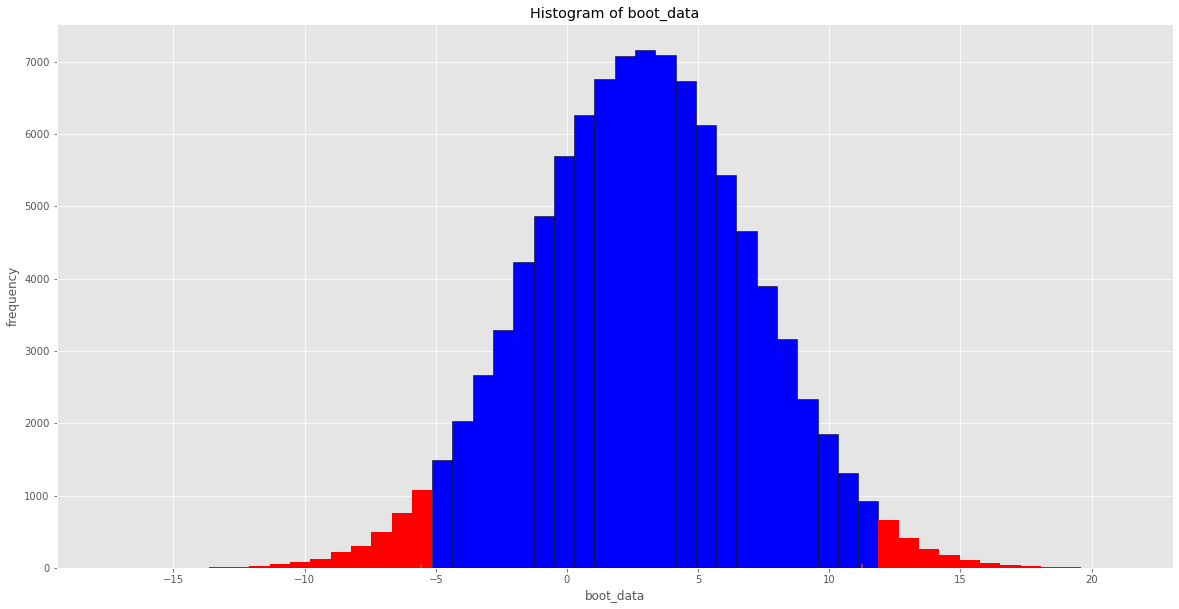

In [286]:
booted_data2 = get_bootstrap(data3, data4)

95%-процентный доверительный интервал для разности средних:

In [287]:
booted_data2['quants']

,0
0.025,-5.569399
0.975,11.245250


p-value:

In [288]:
booted_data2['p_value']

0.5066484407333929

In [289]:
booted_data2['p_value']>alpha

True

**Вывод:** Так как p-value>alpha, то гипотеза Ho не отвергается на 5% уровне значимости. Не зафиксирована статистически значимая разница разности ARPPU от 0.

## ARPU

На основе теста Колмогорова-Смирнова, мы видим, что распределение выручки пользователей каждой из 4 групп не является нормальным.
Поэтому мы не можем использовать t-test для проверки гипотез. Поэтому будем использовать bootstrap, так как у нас есть более 100 наблюдений в каждой группе:

In [290]:
from scipy.stats import kstest
kstest(revenue1['details'], 'norm', 
       args=(revenue1['details'].mean(),
             revenue1['details'].std(ddof=1)))

KstestResult(statistic=0.3874234505136389, pvalue=0.0, statistic_location=0.0, statistic_sign=-1)

In [291]:
kstest(revenue2['details'], 'norm', 
       args=(revenue2['details'].mean(),
             revenue2['details'].std(ddof=1)))

KstestResult(statistic=0.4023890107523038, pvalue=3.509154743909613e-136, statistic_location=0.0, statistic_sign=-1)

In [292]:
kstest(revenue3['details'], 'norm', 
       args=(revenue3['details'].mean(),
             revenue3['details'].std(ddof=1)))

KstestResult(statistic=0.37856758946295394, pvalue=0.0, statistic_location=0.0, statistic_sign=-1)

In [293]:
kstest(revenue4['details'], 'norm', 
       args=(revenue4['details'].mean(),
             revenue4['details'].std(ddof=1)))

KstestResult(statistic=0.3835971068000589, pvalue=0.0, statistic_location=0.0, statistic_sign=-1)

### recommender_system_test

**Тестируем двустороннюю гипотезу:**

    Ho: ARPU1-ARPU2=0
    H1: ARPU1-ARPU2<>0

In [294]:
data1=revenue1['details']
data2=revenue2['details']

Распределение разности средних бутстрапированных выборок (синяя область-95%-процентный доверительный интервал):

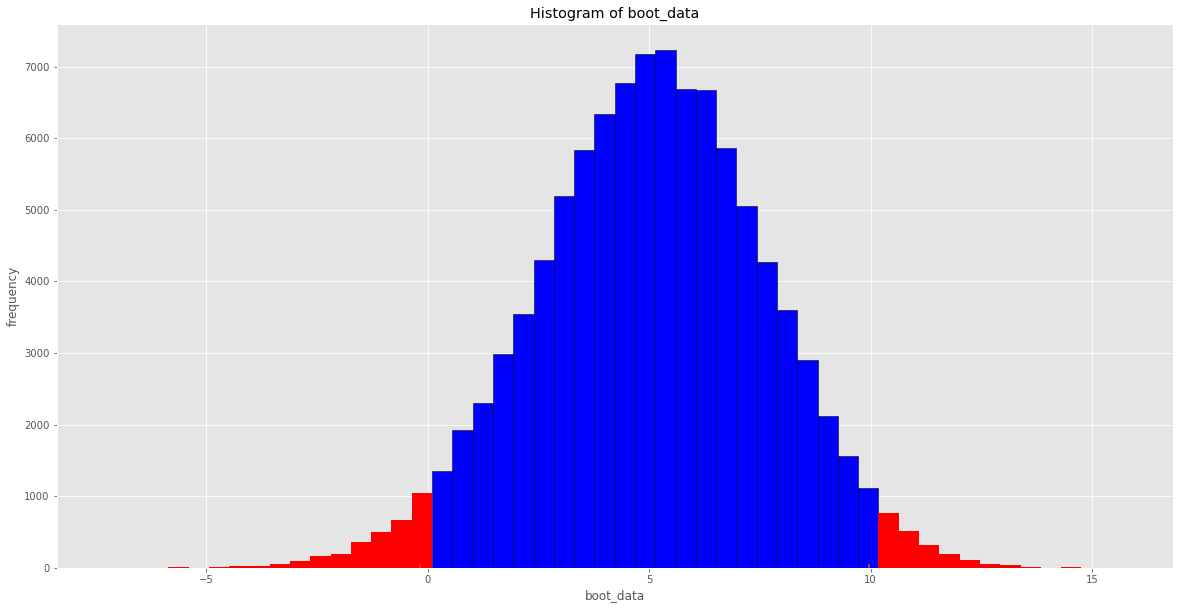

In [295]:
booted_data1 = get_bootstrap(data1, data2)

95%-процентный доверительный интервал для разности средних:

In [296]:
booted_data1['quants']

,0
0.025,-0.170654
0.975,9.955398


p-value:

In [297]:
booted_data1['p_value']

0.05122283738316393

In [298]:
booted_data1['p_value']>alpha

True

**Вывод:** Так как p-value>alpha, то гипотеза Ho не отвергается на 5% уровне значимости. Не зафиксирована статистически значимая разница разности ARPU от 0.

### interface_eu_test

**Тестируем двустороннюю гипотезу:**

    Ho: ARPU1-ARPU2=0
    H1: ARPU1-ARPU2<>0

In [299]:
data3=revenue3['details']
data4=revenue4['details']

Распределение разности средних бутстрапированных выборок (синяя область-95%-процентный доверительный интервал):

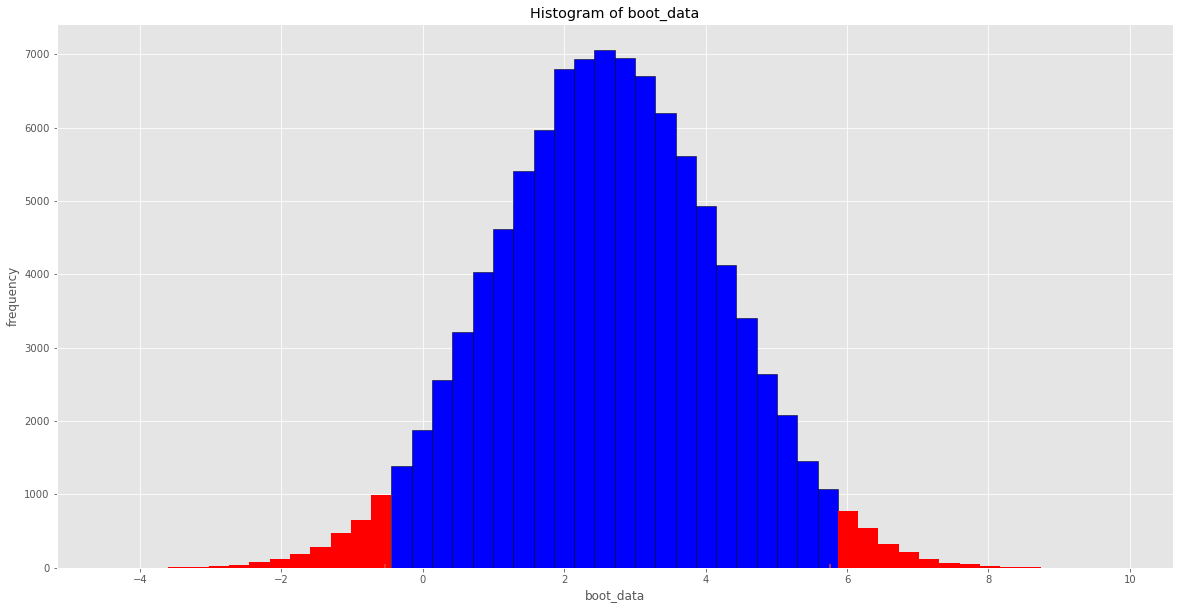

In [300]:
booted_data2 = get_bootstrap(data3, data4)

95%-процентный доверительный интервал для разности средних:

In [301]:
booted_data2['quants']

,0
0.025,-0.535740
0.975,5.760643


p-value:

In [302]:
booted_data2['p_value']

0.10457066866345546

In [303]:
booted_data2['p_value']>alpha

True

**Вывод:** Так как p-value>alpha, то гипотеза Ho не отвергается на 5% уровне значимости. Не зафиксирована статистически значимая разница разности ARPU от 0.

## Результаты А-Б-тестирования

### recommender_system_test

**Результат теста:
Зафиксирована статистически значимая разница разности конверсий от 0. Не зафиксирована статистически значимая разница разности конверсий от MDE. Не зафиксирована статистически значимая разница ARPPU от 0. Не зафиксирована статистически значимая разница разности ARPU от 0. Тест серый, желательно перезапустить тест с большей выборкой, так как есть возможность это сделать (можно увеличить выборку минимум в 4 раза, так как доля нетестируемых пользователей - 75%). Если же проведение а-б-теста затратно по времени и ресурсам, то стоит отказаться от внедрения изменений.**

### interface_eu_test

**Результат теста:
Зафиксирована статистически значимая разница разности конверсий от 0. Не зафиксирована статистически значимая разница разности конверсий от MDE. Не зафиксирована статистически значимая разница ARPPU от 0. Не зафиксирована статистически значимая разница разности ARPU от 0. Тест серый, желательно перезапустить тест с большей выборкой, так как есть возможность это сделать (можно увеличить выборку минимум в 4 раза, так как доля нетестируемых пользователей - 75%). Если же проведение а-б-теста затратно по времени и ресурсам, то стоит отказаться от внедрения изменений.**